In [1]:
import numpy as np
if not hasattr(np, 'typeDict'):
    np.typeDict = np.sctypeDict
import tensorflow
import matplotlib


print(tensorflow.__version__)
print(np.__version__)
print(matplotlib.__version__)

2025-03-17 10:49:27.754591: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-17 10:49:27.793662: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 10:49:28.052426: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 10:49:28.054720: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-17 10:49:28.832515: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

2.13.1
1.24.3
3.7.5


## 데이터 정제 및 토큰화
### 데이터 중복 제거

In [2]:
kor_path = "/home/downtown/aiffel/transformer_translate/korean-english-park.train.ko"
eng_path = "/home/downtown/aiffel/transformer_translate/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    # 중복 제거 (병렬 쌍을 유지해야 하므로 zip 사용)
    unique_pairs = set(zip(kor, eng))

    # 리스트로 변환
    cleaned_corpus = list(unique_pairs)

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

### 데이터 전처리 함수

In [3]:
import re

def preprocess_sentence(sentence):
    # 모든 입력을 소문자로 변환
    sentence = sentence.lower()

    # 알파벳, 한글, 문장부호만 남기고 제거 (공백 포함)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣.,!?]", " ", sentence)

    # 문장부호 양옆에 공백 추가
    sentence = re.sub(r"([.,!?])", r" \1 ", sentence)

    # 여러 개의 공백을 하나의 공백으로 변환
    sentence = re.sub(r"\s+", " ", sentence)

    # 문장 앞뒤의 불필요한 공백 제거
    sentence = sentence.strip()

    return sentence

### 데이터 토큰화

In [5]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.

import sentencepiece as spm
import os

def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):

    # 학습 데이터 저장
    temp_file = f"temp_{lang}.txt"
    with open(temp_file, "w", encoding="utf-8") as f:
        for sentence in corpus:
            f.write(sentence + "\n")

    # SentencePiece 모델 학습
    model_prefix = f"tokenizer_{lang}"
    spm.SentencePieceTrainer.Train(
        input=temp_file,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        pad_id=pad_id,
        bos_id=bos_id,
        eos_id=eos_id,
        unk_id=unk_id,
        model_type="bpe"  # Byte Pair Encoding 방식 사용
    )

    # 학습된 모델 로드
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f"{model_prefix}.model")

    # 임시 파일 삭제
    os.remove(temp_file)

    return tokenizer

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [6]:
print(en_tokenizer)  # 모델이 정상 로드되었는지 확인

<sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type 'sentencepiece::SentencePieceProcessor *' at 0x7f713403a480> >


In [7]:
tokens = en_tokenizer.encode("Hello, how are you?", out_type=int)
decoded_sentence = en_tokenizer.decode(tokens)

print("토큰화 결과:", tokens)
print("디코딩 문장:", decoded_sentence)

토큰화 결과: [1, 19971, 3, 9589, 19993, 578, 154, 461, 3, 2]
디코딩 문장:  ⁇ ello, how are you ⁇ 


In [8]:
print(en_tokenizer.get_piece_size())

20000


In [9]:
# 0~4번 인덱스 토큰 확인
for i in range(5):
    print(f"인덱스 {i}: {en_tokenizer.id_to_piece(i)}")

인덱스 0: <pad>
인덱스 1: <s>
인덱스 2: </s>
인덱스 3: <unk>
인덱스 4: ▁t


In [10]:
indexes = [1, 19971, 3, 9590, 19993, 578, 154, 461, 3, 2]
for i in indexes:
    print(f"인덱스 {i}: {en_tokenizer.id_to_piece(i)}")

인덱스 1: <s>
인덱스 19971: ▁
인덱스 3: <unk>
인덱스 9590: heit
인덱스 19993: ,
인덱스 578: ▁how
인덱스 154: ▁are
인덱스 461: ▁you
인덱스 3: <unk>
인덱스 2: </s>


#### 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus와 tgt_corpus를 각각 구축하고, 텐서 enc_train과 dec_train으로 변환

In [11]:
import tensorflow as tf
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    # 한글 문장 토큰화
    src_tokens = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    # 영어 문장 토큰화 (BOS/EOS 포함)
    tgt_tokens = en_tokenizer.EncodeAsIds(eng_corpus[idx])

    # 길이 제한 (50 이하만 저장)
    if len(src_tokens) <= 50 and len(tgt_tokens) <= 50:
        src_corpus.append(src_tokens)
        tgt_corpus.append(tgt_tokens)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post') # ko
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post') # en

  0%|          | 0/78968 [00:00<?, ?it/s]

In [12]:
print(enc_train[:5])
print(dec_train[:5])

[[ 3451   207   541   738   831  9016    66    37  1888   464  4581  6744
    127 10553    56     4     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [ 2089   198  1147   149  5984  2203  6912 18817  1122 18954  4019   402
     10   708 18817  6067  3484   221  6065   652  5467 18851   104 17822
     48    10  6130 18821  8118   147  1414   553   106  7483  1930   624
   7689  1262 18817    10   241   402  7403     0     0     0     0     0
      0     0]
 [ 2113 18831 18836  5417 18868    10     7 18190    74    13 18844   234
  19231 18979     4     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [  417     4   147     4  7197  2001   826  2243 15494   396  5058

In [13]:
print(enc_train.shape)
print(dec_train.shape)

(75513, 50)
(75513, 50)


## 모델 설계

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)


'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.13.1


### Positional Encoding

In [35]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table


### Multi-Head Attention

In [36]:
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

### Position-wise Feed-Forward Network

In [37]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

### Encoder Layer

In [38]:
# Encoder의 레이어 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

### Decoder Layer

In [39]:
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### Encoder/Decoder Class

In [40]:
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [41]:
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### Transformer

In [42]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()

        self.n_layers = n_layers
        self.n_heads = n_heads
        self.d_ff = d_ff
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

### generate_padding_mask

In [43]:
# import numpy as np
# import tensorflow as tf

# def generate_padding_mask(seq):
#     seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
#     return seq[:, tf.newaxis, tf.newaxis, :]

# def generate_causality_mask(seq):
#     # seq의 shape: (batch_size, seq_len)
#     batch_size = tf.shape(seq)[0]
#     seq_len = tf.shape(seq)[1]
#     # 정방 행렬 (seq_len, seq_len) 생성
#     mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
#     # (1, 1, seq_len, seq_len) 모양으로 확장
#     mask = mask[tf.newaxis, tf.newaxis, :, :]
#     # 배치 차원만큼 타일링하여 (batch_size, 1, seq_len, seq_len) 모양으로 변경
#     mask = tf.tile(mask, [batch_size, 1, 1, 1])
#     return mask

# def generate_masks(src, tgt):
#     enc_mask = generate_padding_mask(src)          # (batch, 1, 1, src_len)
#     causality_mask = generate_causality_mask(tgt)     # (batch, 1, tgt_len, tgt_len)
#     dec_enc_mask = generate_padding_mask(src)         # (batch, 1, 1, src_len)
    
#     tf.print("enc_mask shape:", tf.shape(enc_mask))
#     tf.print("causality_mask shape:", tf.shape(causality_mask))
#     tf.print("dec_mask shape:", tf.shape(dec_enc_mask))

#     return enc_mask, causality_mask, dec_enc_mask

In [44]:
# Mask  생성하기
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

## 훈련

In [46]:
transformer = Transformer(
    n_layers = 2,          # Encoder & Decoder Layers
    d_model = 512,         # Embedding 차원
    n_heads = 8,           # Multi-Head Attention에서 Head 수
    d_ff = 2048,           # Feed Forward 네트워크의 Hidden Layer 크기
    src_vocab_size = SRC_VOCAB_SIZE,  # 입력 언어의 Vocabulary 크기
    tgt_vocab_size = TGT_VOCAB_SIZE,  # 출력 언어의 Vocabulary 크기
    pos_len = 100,         # 최대 시퀀스 길이
    dropout = 0.1,         # Dropout 비율
    shared_fc=True,
    shared_emb=True  # Embedding Weight 공유 여부
)


### Learning Rate Schedule

In [47]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        # step, d_model, warmup_steps를 float으로 캐스팅
        step = tf.cast(step, tf.float32)
        d_model = tf.cast(self.d_model, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        
        arg1 = tf.math.pow(step, -0.5)
        arg2 = step * tf.math.pow(warmup_steps, -1.5)
        
        return tf.math.pow(d_model, -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)


Text(0.5, 0, 'Train Step')

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

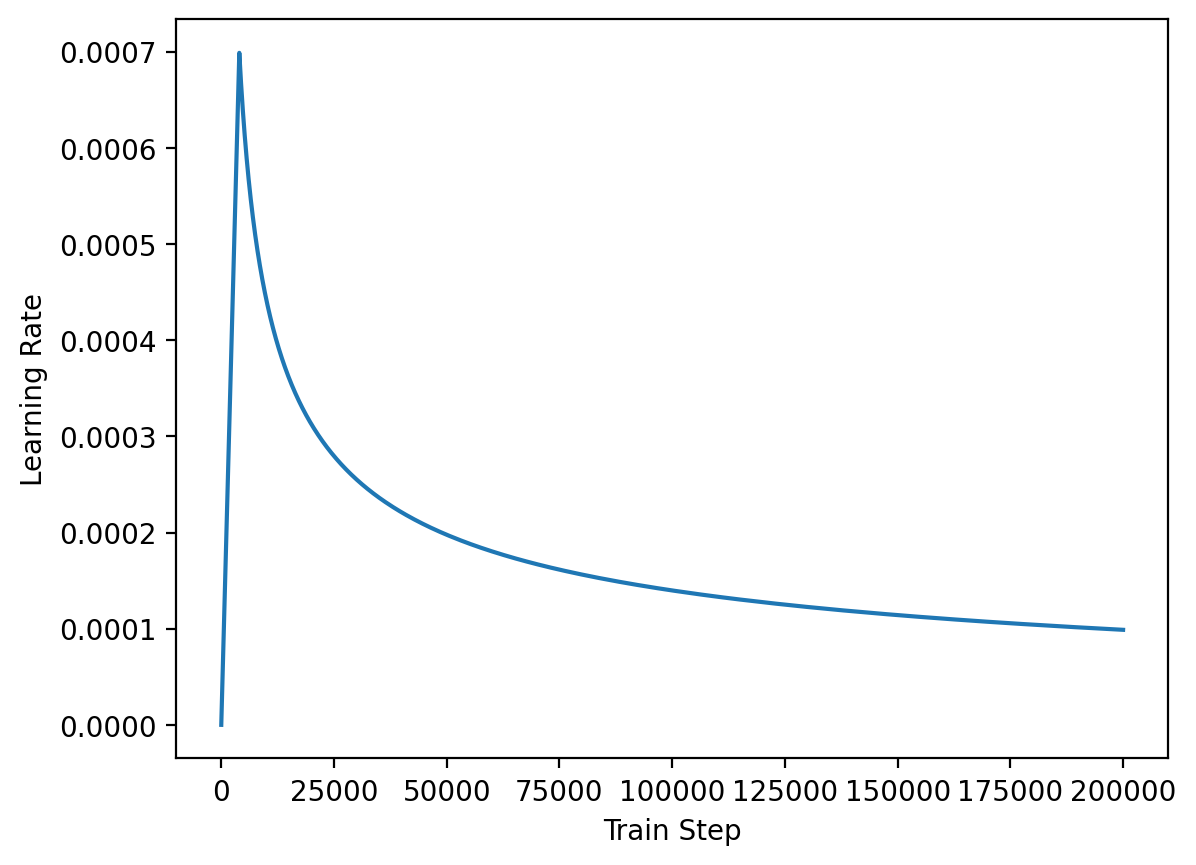

In [48]:
plt.plot(learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Loss function

In [49]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### train_step function

In [68]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, causality_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, causality_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

### 학습 진행

In [51]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [61]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    tf.print("evaluate _input shape:", tf.shape(_input))
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    tf.print("Initial output shape:", tf.shape(output))

    for i in range(dec_train.shape[-1]):
        batch_size = tf.shape(_input)[0]
        enc_padding_mask, combined_mask, dec_padding_mask = \
            generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)
        
        tf.print("Predictions shape:", tf.shape(predictions))

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

#         predicted_id = \
#         tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            # break  # EOS가 나오면 종료
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 1)], axis=1)
        tf.print("Updated output shape:", tf.shape(output))

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [62]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=True):
    # 평가 전에 eager 모드 활성화 (훈련에는 영향 주지 않음)
    # transformer.run_eagerly = True
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [63]:
# 테스트 문장을 이용해 evaluate 함수 실행
# output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(
    "오바마는 대통령이다.", transformer, ko_tokenizer, en_tokenizer)


evaluate _input shape: [1 50]
Initial output shape: [1 1]
Predictions shape: [1 1 20000]
Updated output shape: [1 2]
Predictions shape: [1 2 20000]
Updated output shape: [1 3]
Predictions shape: [1 3 20000]
Updated output shape: [1 4]
Predictions shape: [1 4 20000]
Updated output shape: [1 5]
Predictions shape: [1 5 20000]
Updated output shape: [1 6]
Predictions shape: [1 6 20000]
Updated output shape: [1 7]
Predictions shape: [1 7 20000]
Updated output shape: [1 8]
Predictions shape: [1 8 20000]
Updated output shape: [1 9]
Predictions shape: [1 9 20000]
Updated output shape: [1 10]
Predictions shape: [1 10 20000]
Updated output shape: [1 11]
Predictions shape: [1 11 20000]
Updated output shape: [1 12]
Predictions shape: [1 12 20000]
Updated output shape: [1 13]
Predictions shape: [1 13 20000]
Updated output shape: [1 14]
Predictions shape: [1 14 20000]
Updated output shape: [1 15]
Predictions shape: [1 15 20000]
Updated output shape: [1 16]
Predictions shape: [1 16 20000]
Updated outp

In [64]:
# 테스트 문장을 이용해 evaluate 함수 실행
# output = tf.concat([output, tf.expand_dims([predicted_id], 1)], axis=-1)

pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(
    "오바마는 대통령이다.", transformer, ko_tokenizer, en_tokenizer)


evaluate _input shape: [1 50]
Initial output shape: [1 1]
Predictions shape: [1 1 20000]
Updated output shape: [1 2]
Predictions shape: [1 2 20000]
Updated output shape: [1 3]
Predictions shape: [1 3 20000]
Updated output shape: [1 4]
Predictions shape: [1 4 20000]
Updated output shape: [1 5]
Predictions shape: [1 5 20000]
Updated output shape: [1 6]
Predictions shape: [1 6 20000]
Updated output shape: [1 7]
Predictions shape: [1 7 20000]
Updated output shape: [1 8]
Predictions shape: [1 8 20000]
Updated output shape: [1 9]
Predictions shape: [1 9 20000]
Updated output shape: [1 10]
Predictions shape: [1 10 20000]
Updated output shape: [1 11]
Predictions shape: [1 11 20000]
Updated output shape: [1 12]
Predictions shape: [1 12 20000]
Updated output shape: [1 13]
Predictions shape: [1 13 20000]
Updated output shape: [1 14]
Predictions shape: [1 14 20000]
Updated output shape: [1 15]
Predictions shape: [1 15 20000]
Updated output shape: [1 16]
Predictions shape: [1 16 20000]
Updated outp

In [65]:
# 테스트 문장을 이용해 evaluate 함수 실행
# output = tf.concat([output, tf.expand_dims([predicted_id], 1)], axis=-1)

# 평가 전에 eager 모드 활성화 (평가용)
tf.config.run_functions_eagerly(True)

pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(
    "오바마는 대통령이다.", transformer, ko_tokenizer, en_tokenizer)

evaluate _input shape: [1 50]
Initial output shape: [1 1]
Predictions shape: [1 1 20000]
Updated output shape: [1 2]
Predictions shape: [1 2 20000]
Updated output shape: [1 3]
Predictions shape: [1 3 20000]
Updated output shape: [1 4]
Predictions shape: [1 4 20000]
Updated output shape: [1 5]
Predictions shape: [1 5 20000]
Updated output shape: [1 6]
Predictions shape: [1 6 20000]
Updated output shape: [1 7]
Predictions shape: [1 7 20000]
Updated output shape: [1 8]
Predictions shape: [1 8 20000]
Updated output shape: [1 9]
Predictions shape: [1 9 20000]
Updated output shape: [1 10]
Predictions shape: [1 10 20000]
Updated output shape: [1 11]
Predictions shape: [1 11 20000]
Updated output shape: [1 12]
Predictions shape: [1 12 20000]
Updated output shape: [1 13]
Predictions shape: [1 13 20000]
Updated output shape: [1 14]
Predictions shape: [1 14 20000]
Updated output shape: [1 15]
Predictions shape: [1 15 20000]
Updated output shape: [1 16]
Predictions shape: [1 16 20000]
Updated outp

/tmp/ipykernel_914/1729361234.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1180 [00:00<?, ?it/s]

evaluate _input shape: [1 50]
Initial output shape: [1 1]
Predictions shape: [1 1 20000]
Updated output shape: [1 2]
Predictions shape: [1 2 20000]
Updated output shape: [1 3]
Predictions shape: [1 3 20000]
Updated output shape: [1 4]
Predictions shape: [1 4 20000]
Updated output shape: [1 5]
Predictions shape: [1 5 20000]
Updated output shape: [1 6]
Predictions shape: [1 6 20000]
Updated output shape: [1 7]
Predictions shape: [1 7 20000]
Updated output shape: [1 8]
Predictions shape: [1 8 20000]
Updated output shape: [1 9]
Predictions shape: [1 9 20000]
Input: 오바마는 대통령이다.
Predicted translation: obama is in the obama of illinois .


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Gl

Encoder Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

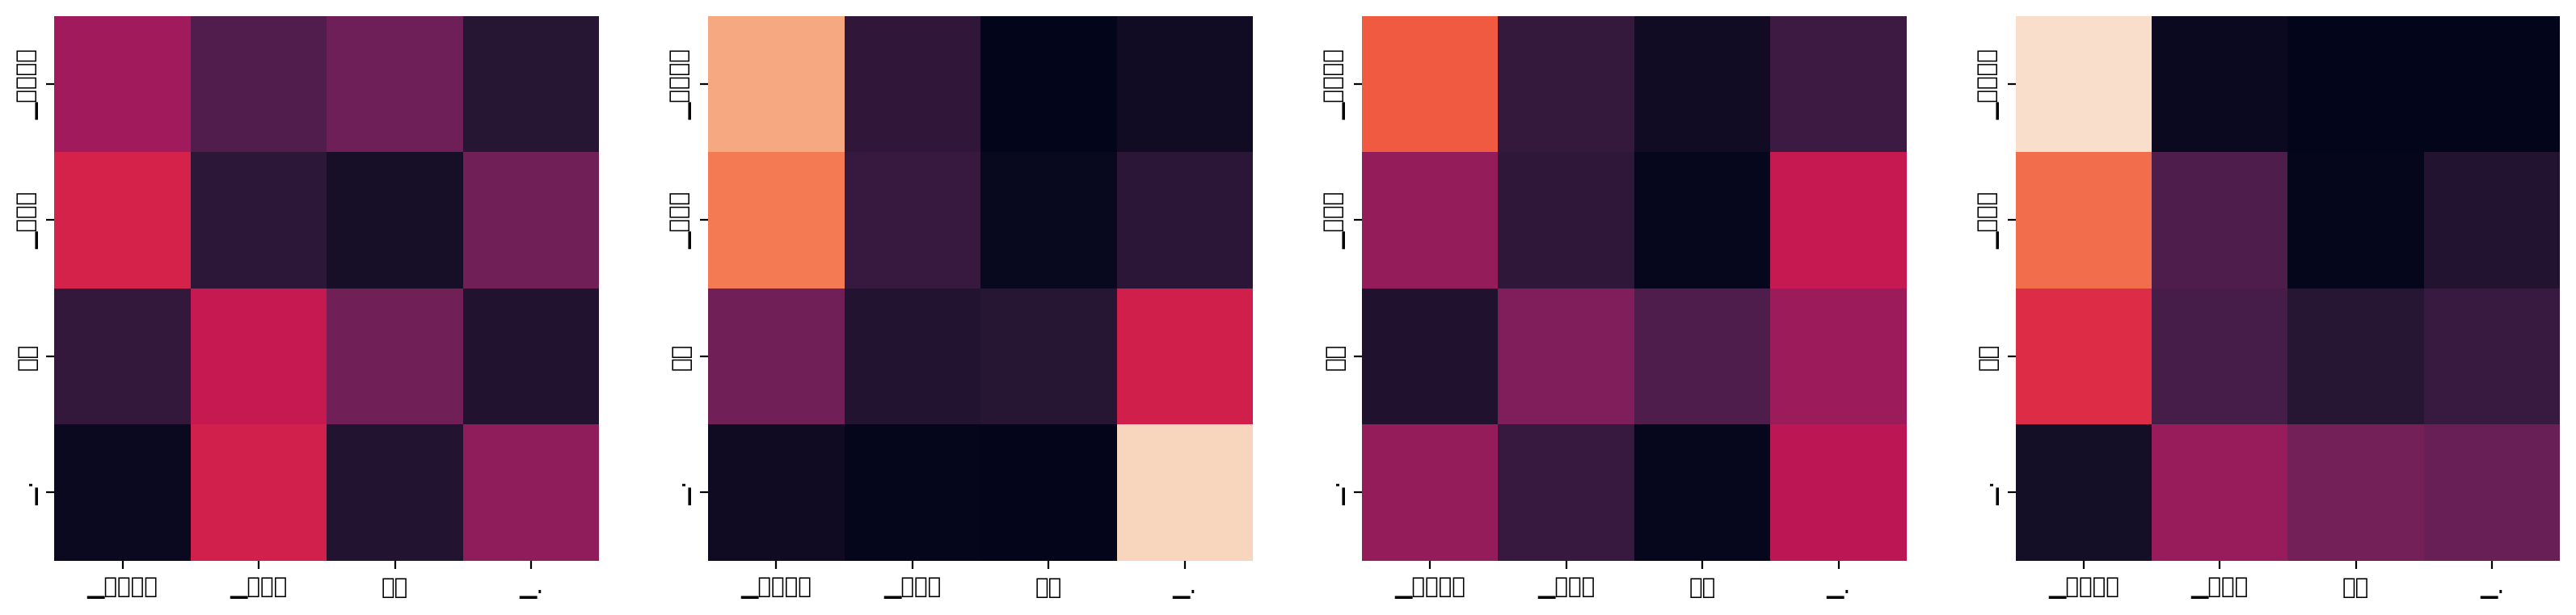

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Gl

Encoder Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

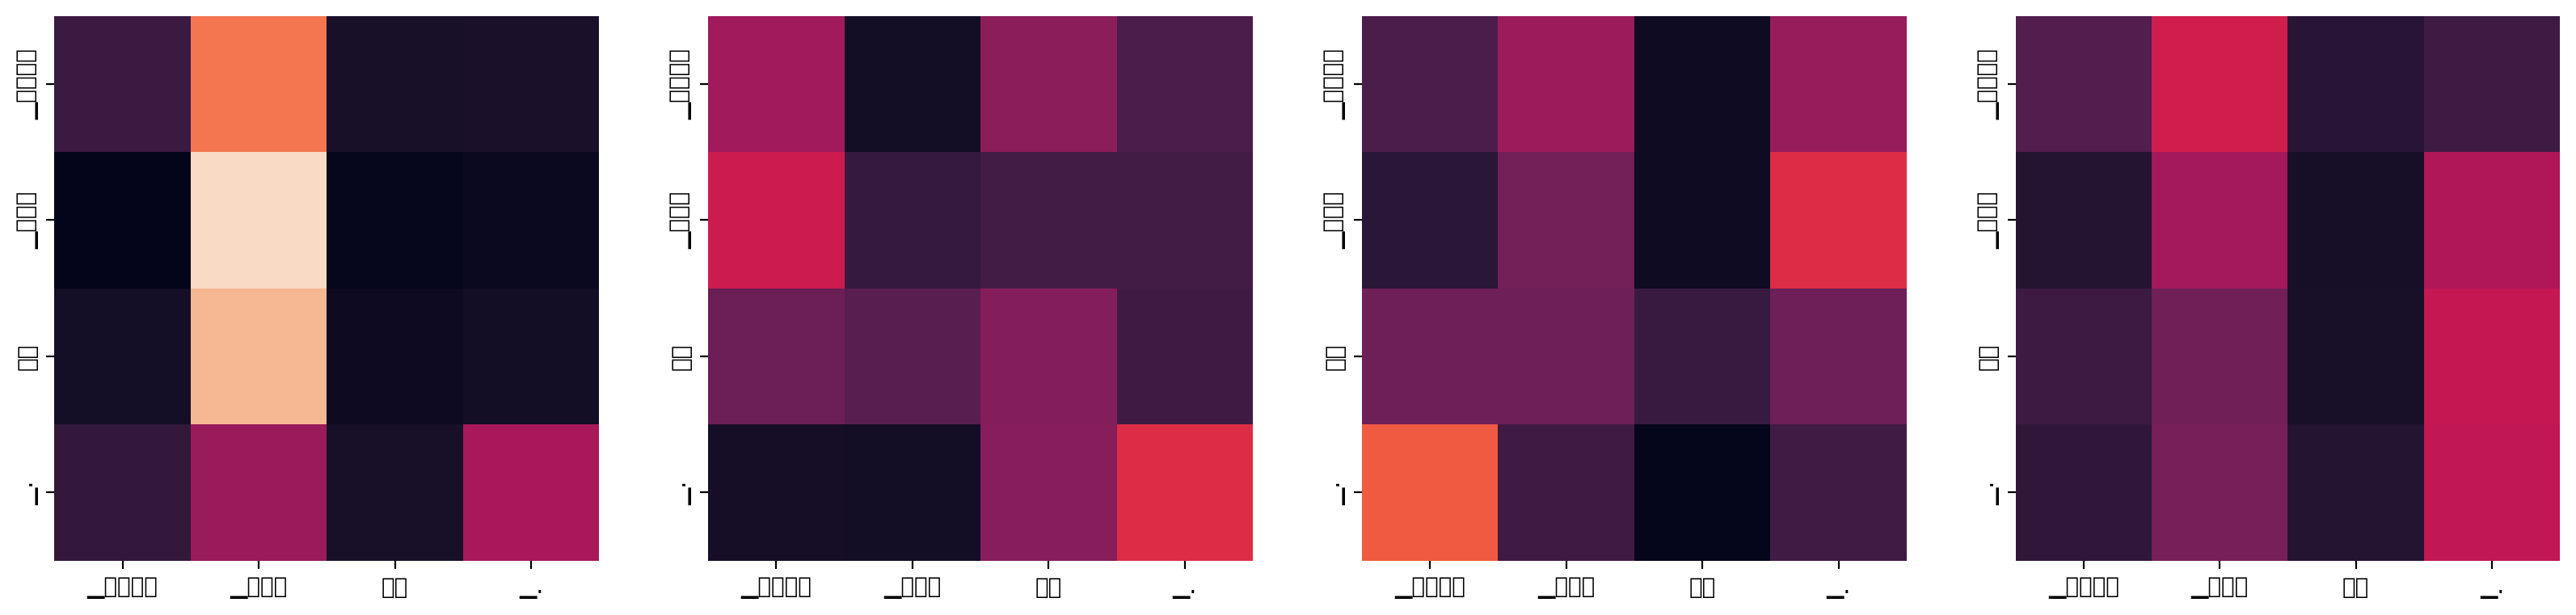

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

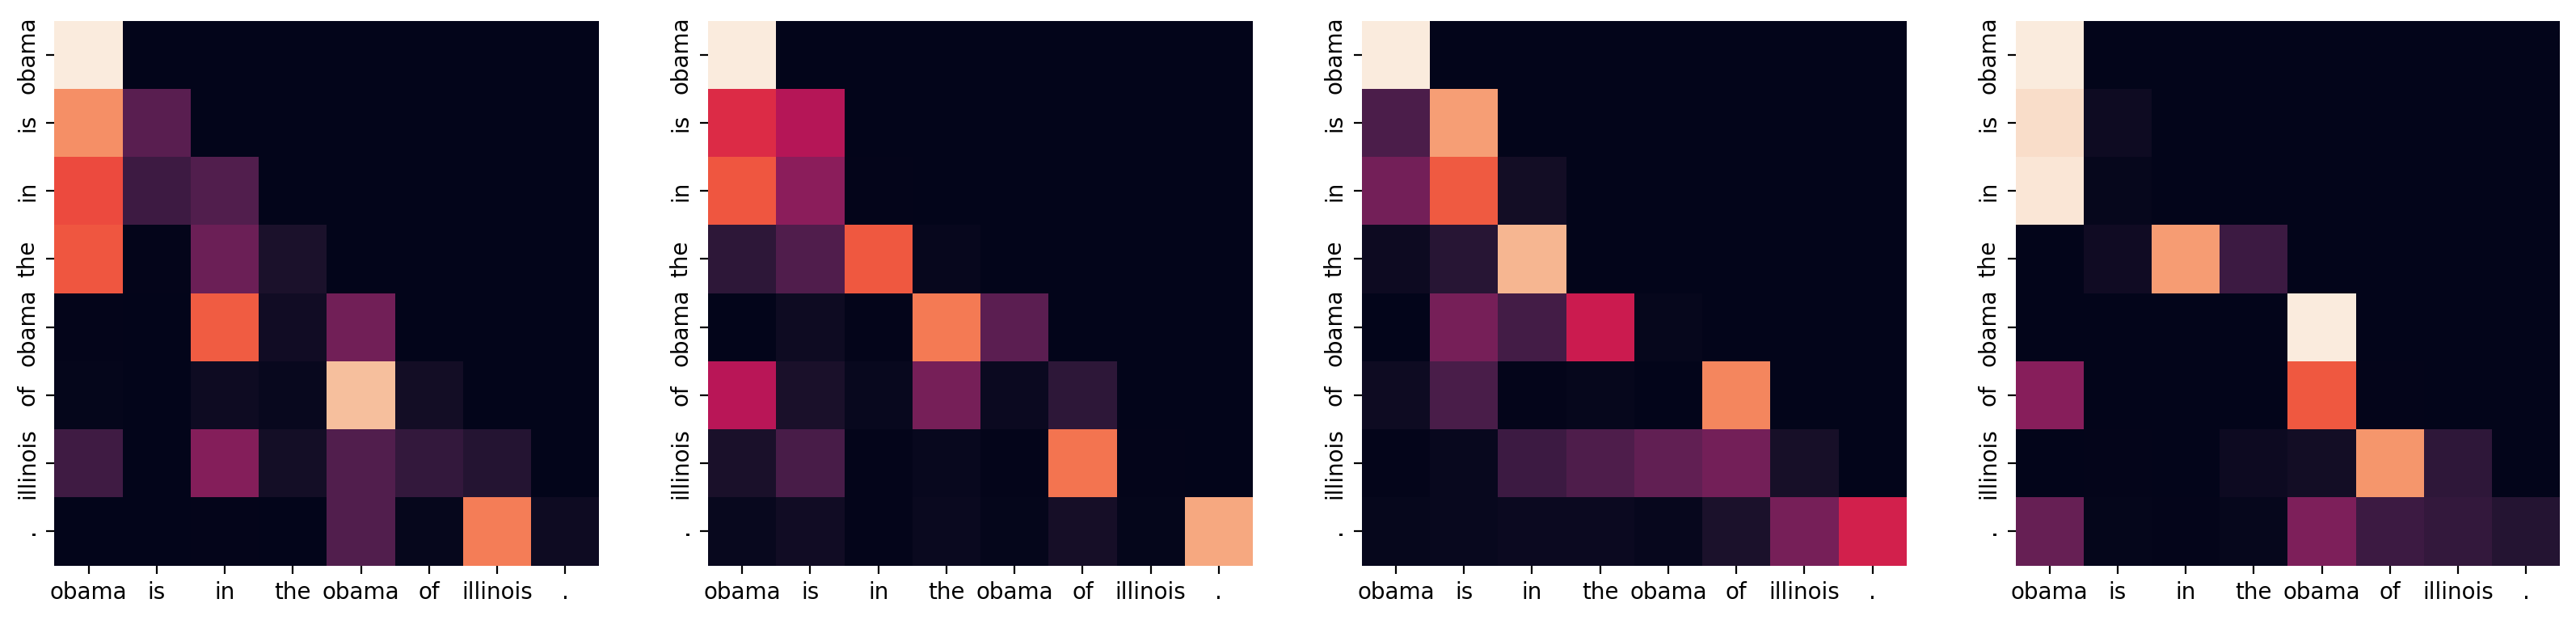

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Gl

Decoder Src Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()

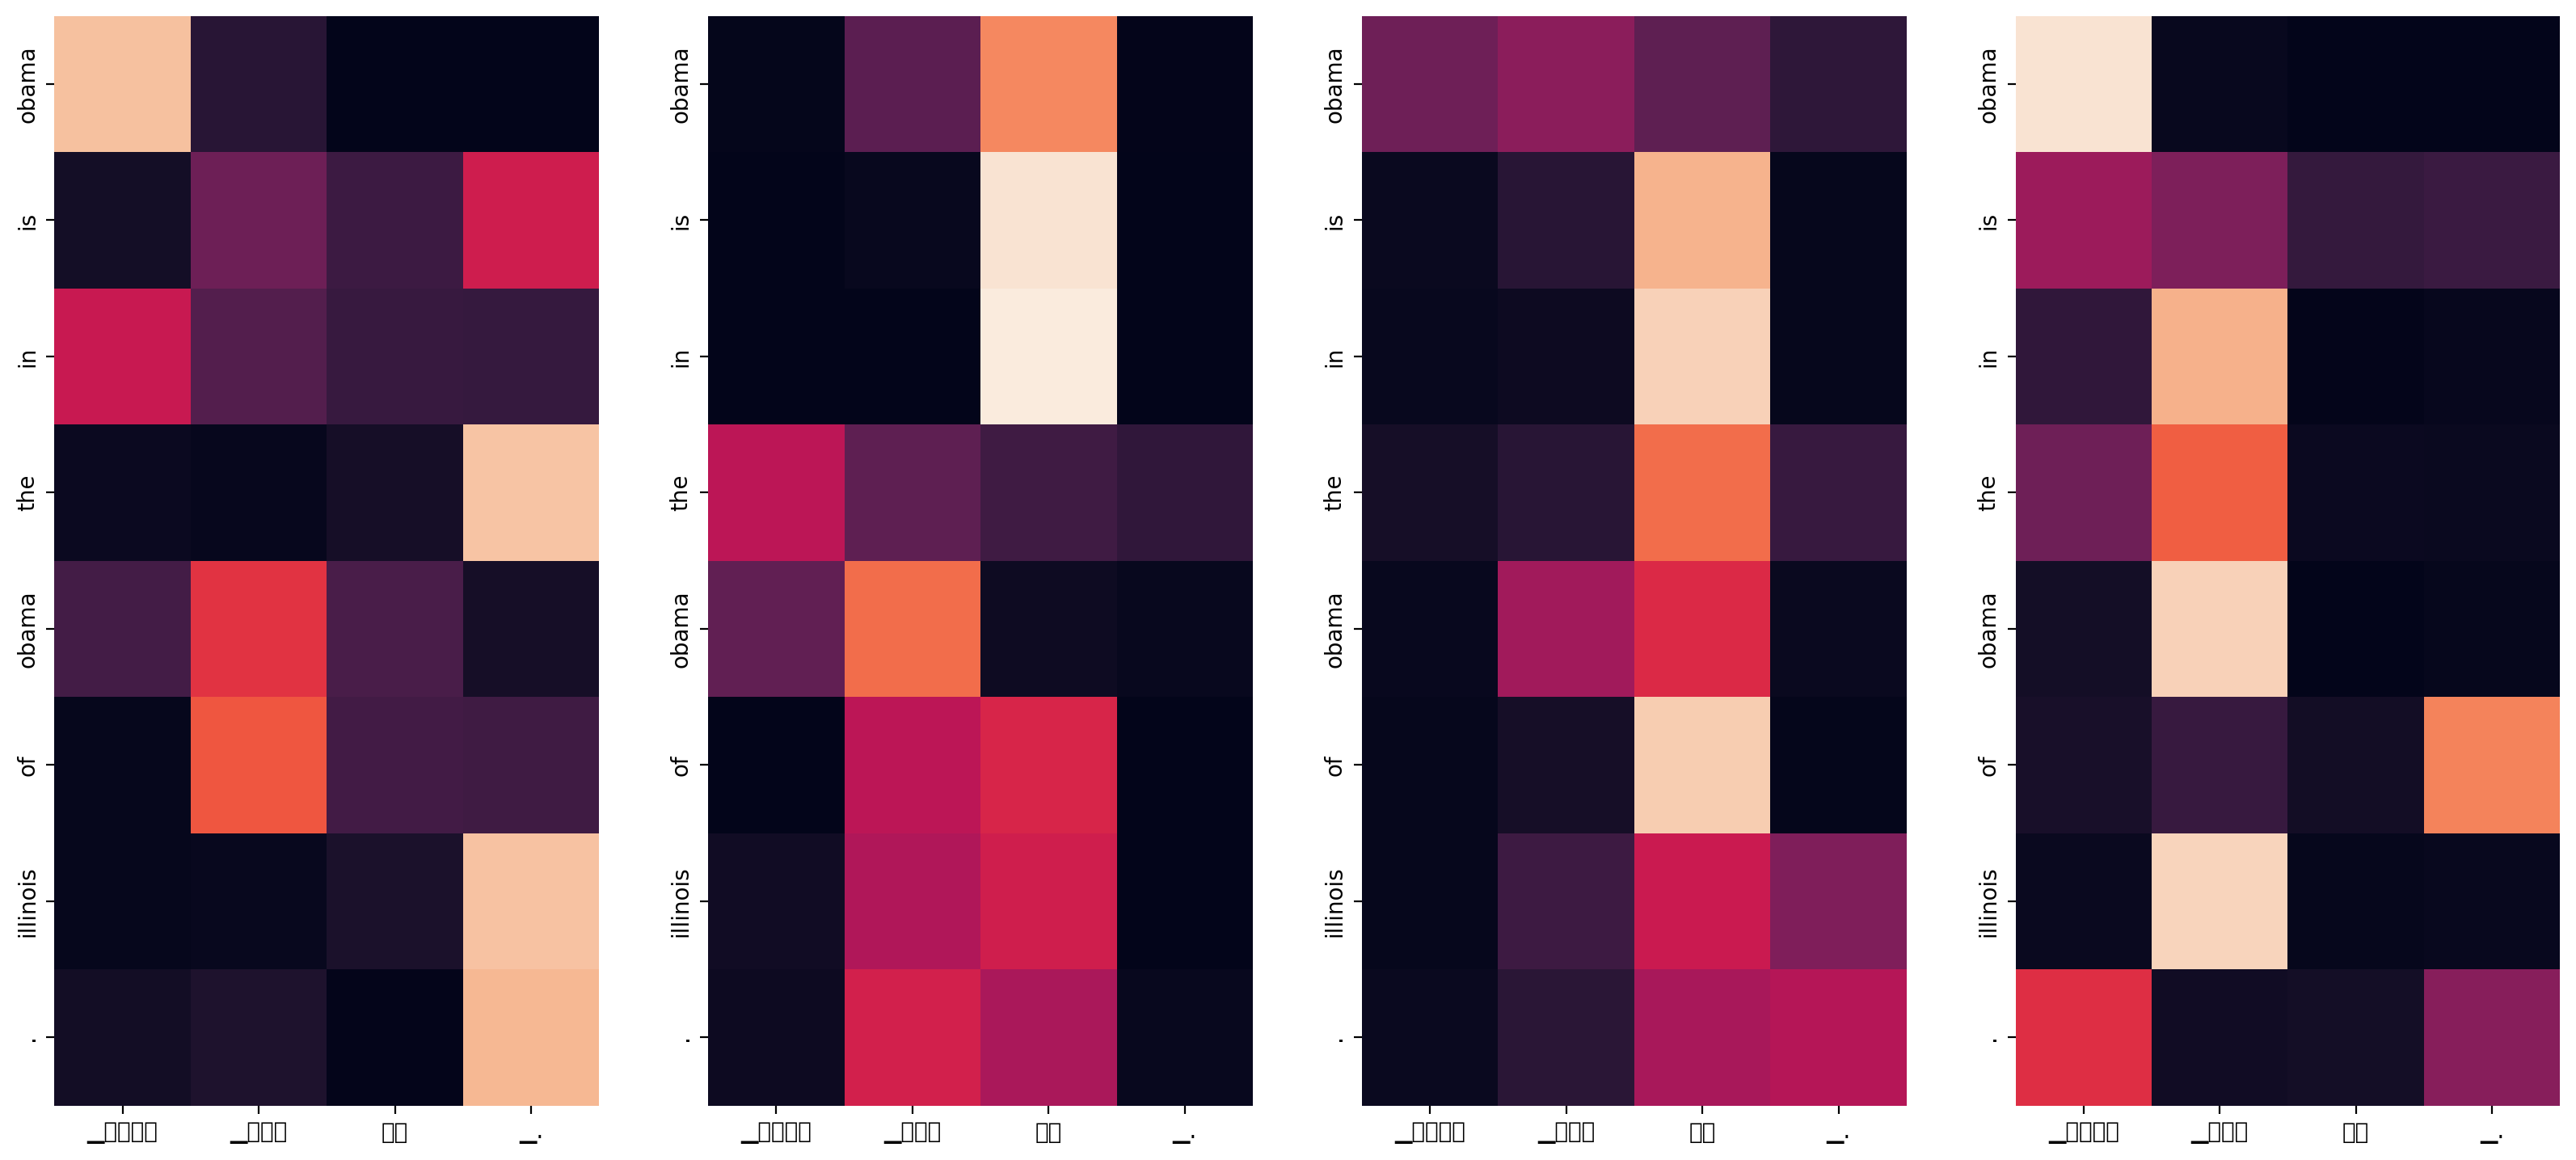

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

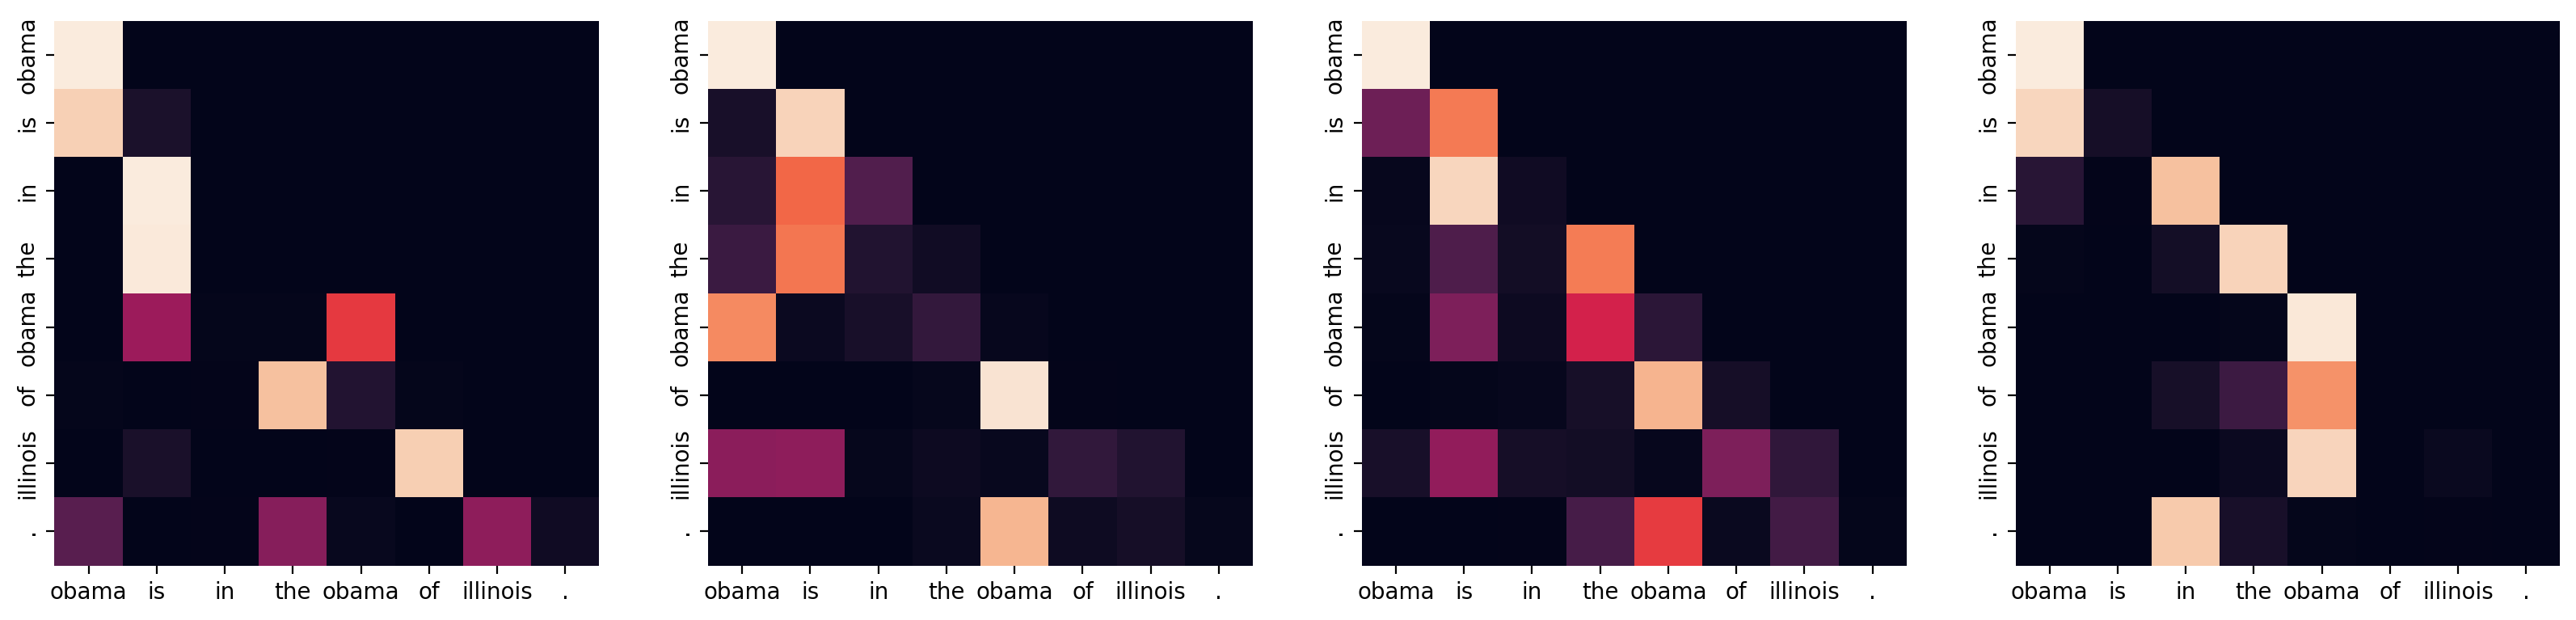

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Gl

Decoder Src Layer 2


findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from cur

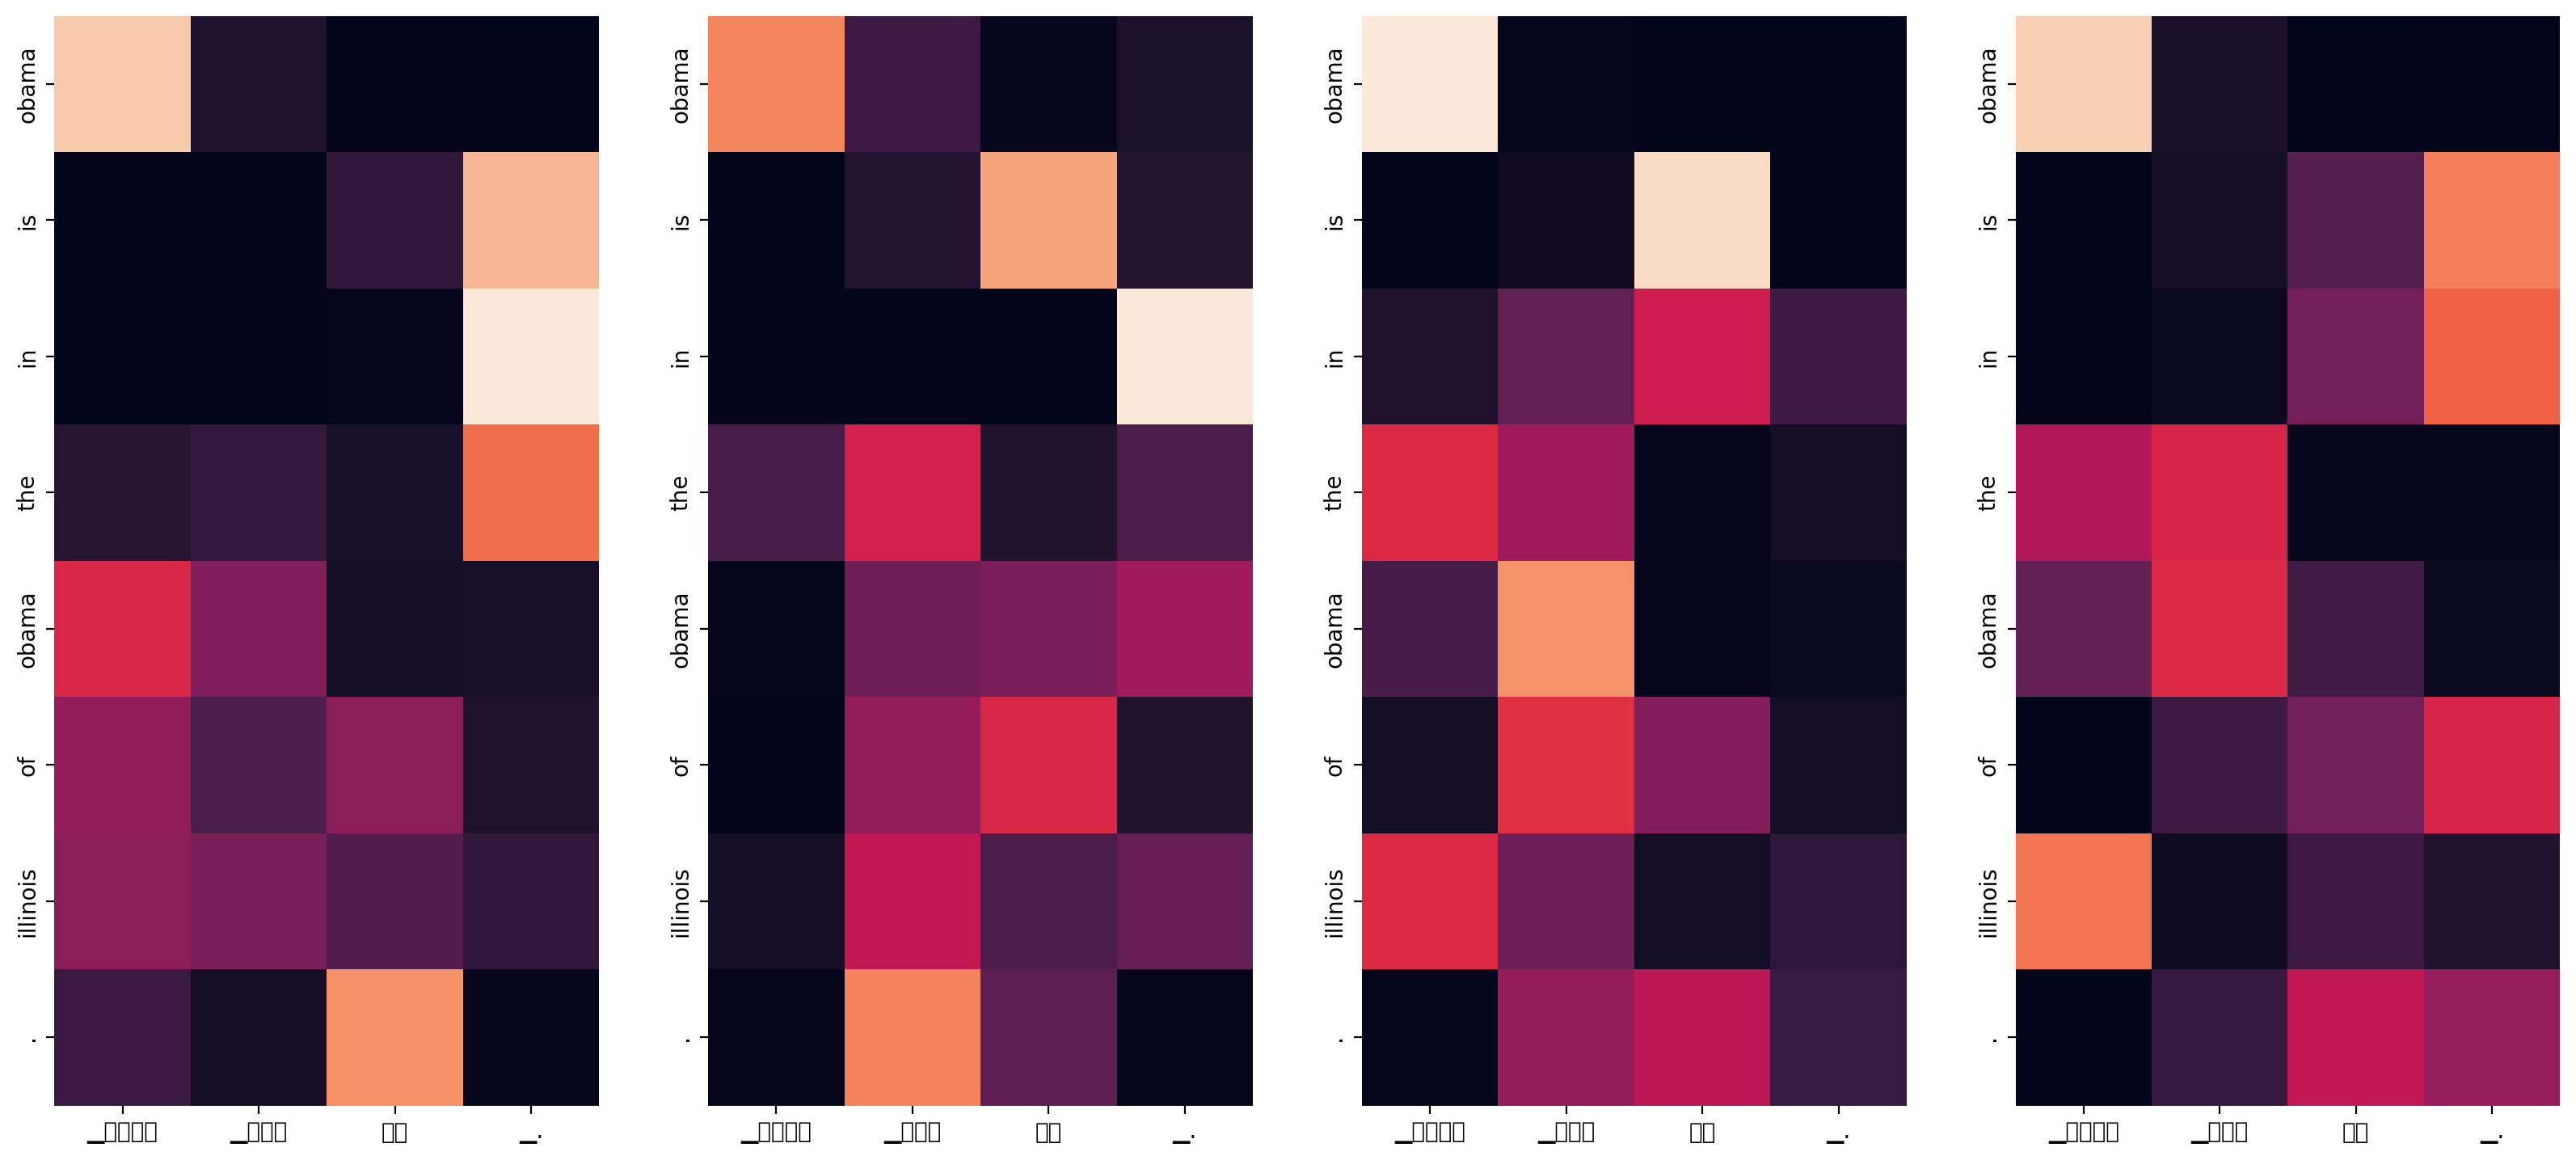

evaluate _input shape: [1 50]
Initial output shape: [1 1]
Predictions shape: [1 1 20000]
Updated output shape: [1 2]
Predictions shape: [1 2 20000]
Updated output shape: [1 3]
Predictions shape: [1 3 20000]
Updated output shape: [1 4]
Predictions shape: [1 4 20000]
Updated output shape: [1 5]
Predictions shape: [1 5 20000]
Updated output shape: [1 6]
Predictions shape: [1 6 20000]
Updated output shape: [1 7]
Predictions shape: [1 7 20000]
Updated output shape: [1 8]
Predictions shape: [1 8 20000]
Updated output shape: [1 9]
Predictions shape: [1 9 20000]
Updated output shape: [1 10]
Predictions shape: [1 10 20000]
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is in the city .


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning:

Encoder Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

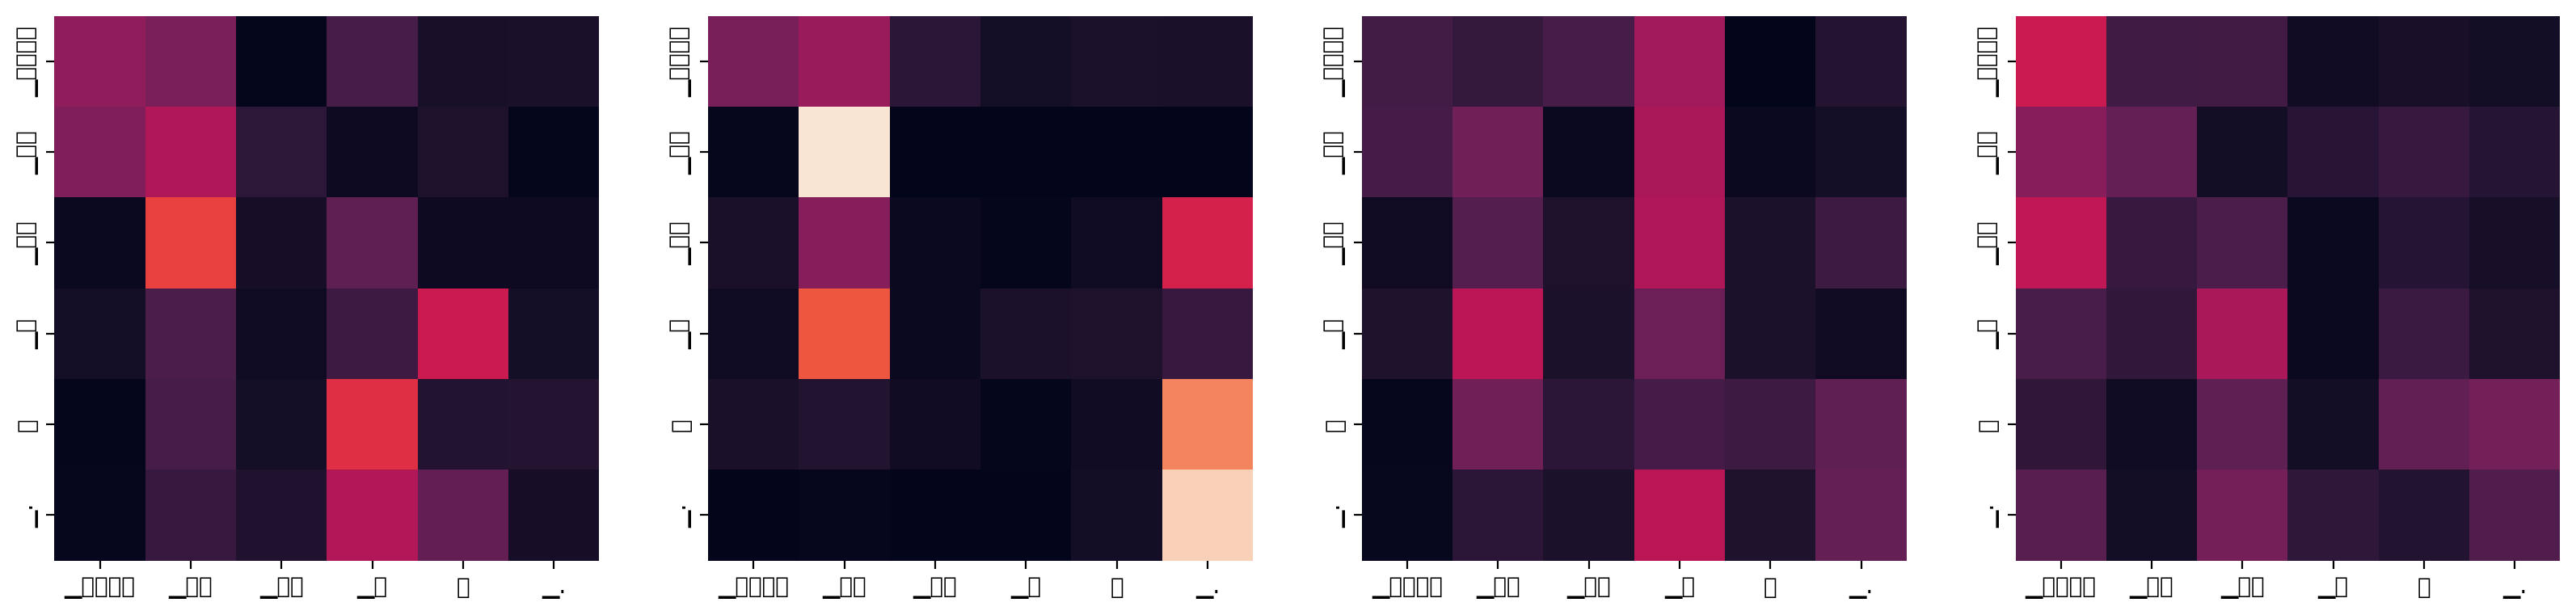

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning:

Encoder Layer 2


/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49549 (\N{HANGUL SYLLABLE SOG}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Gl

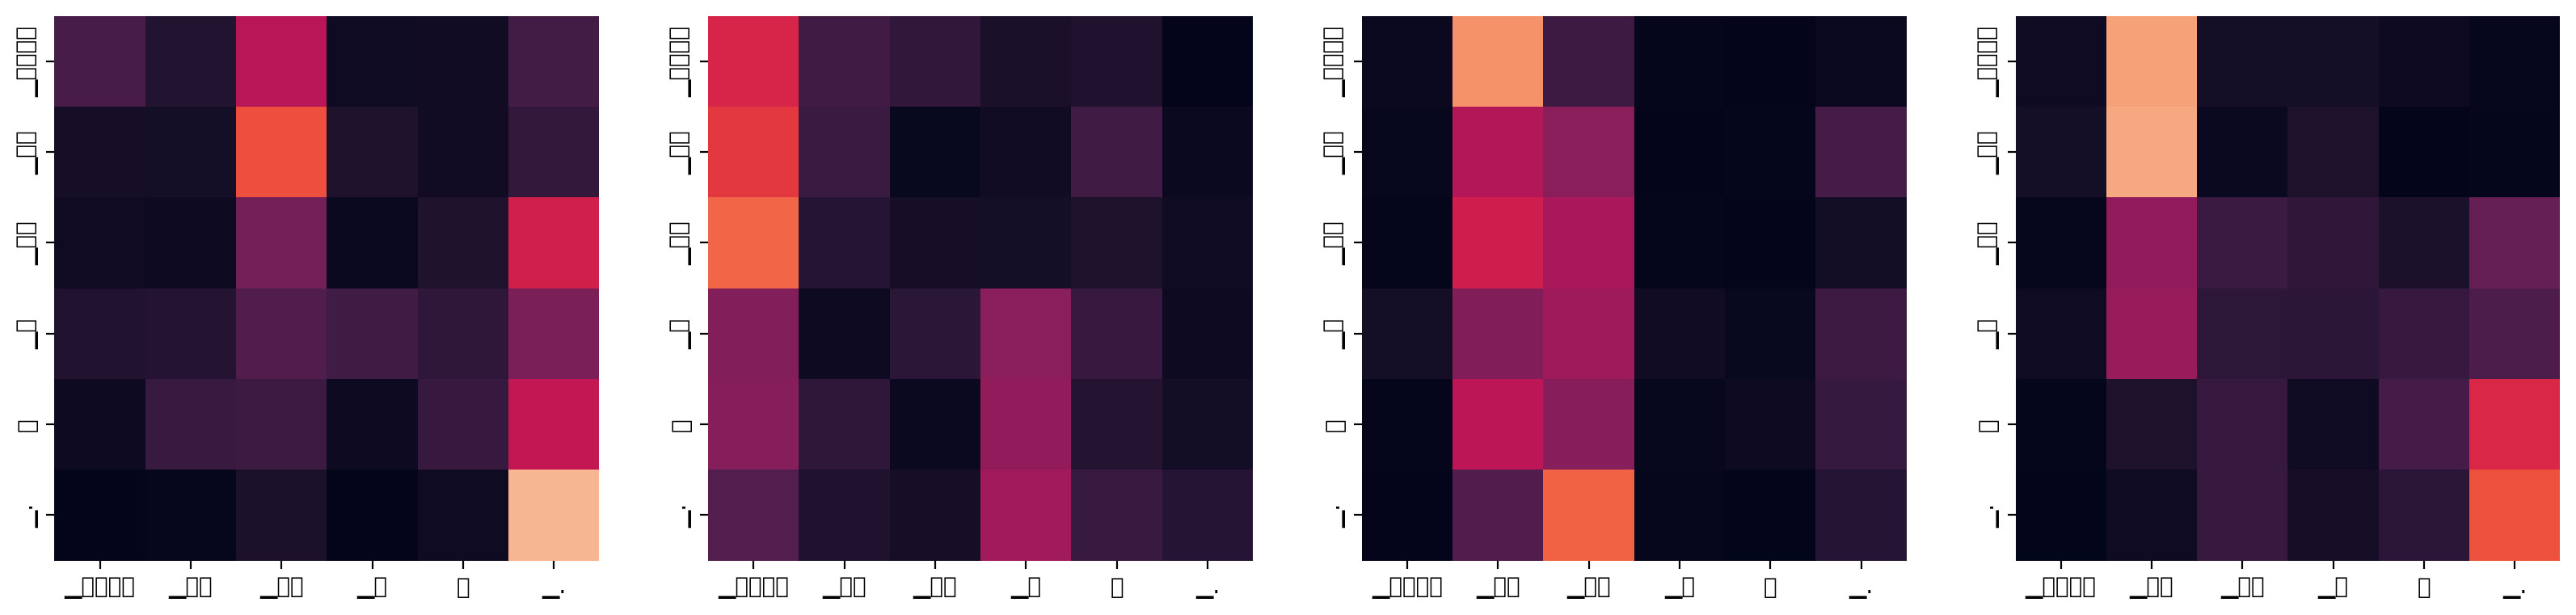

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

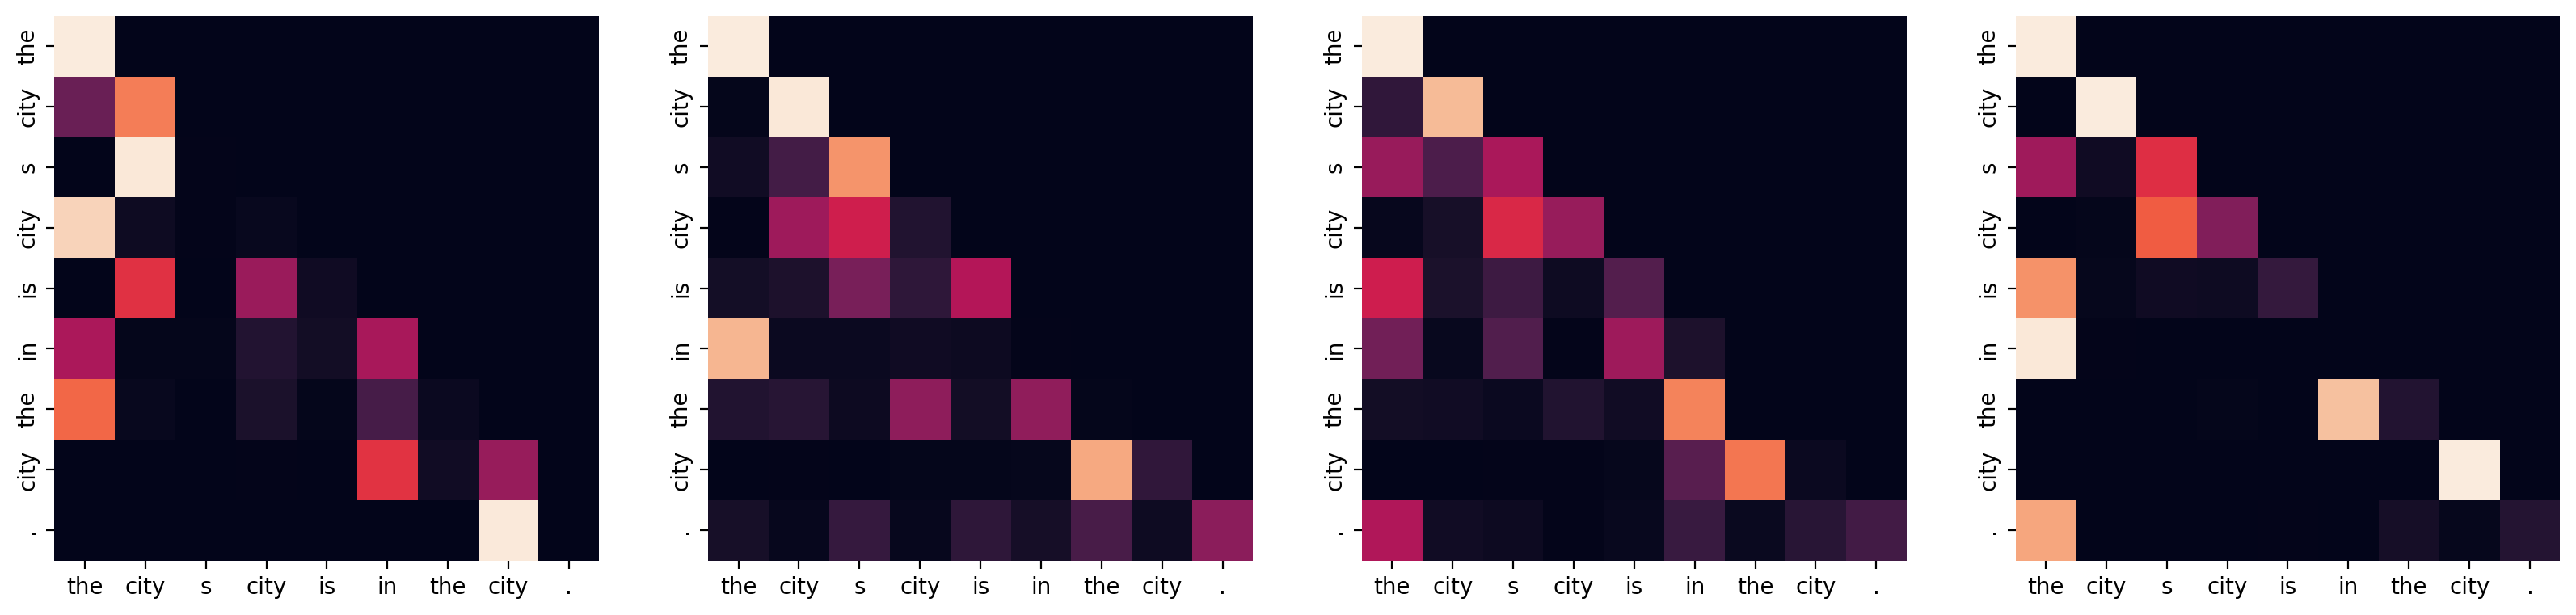

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning:

Decoder Src Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/pytho

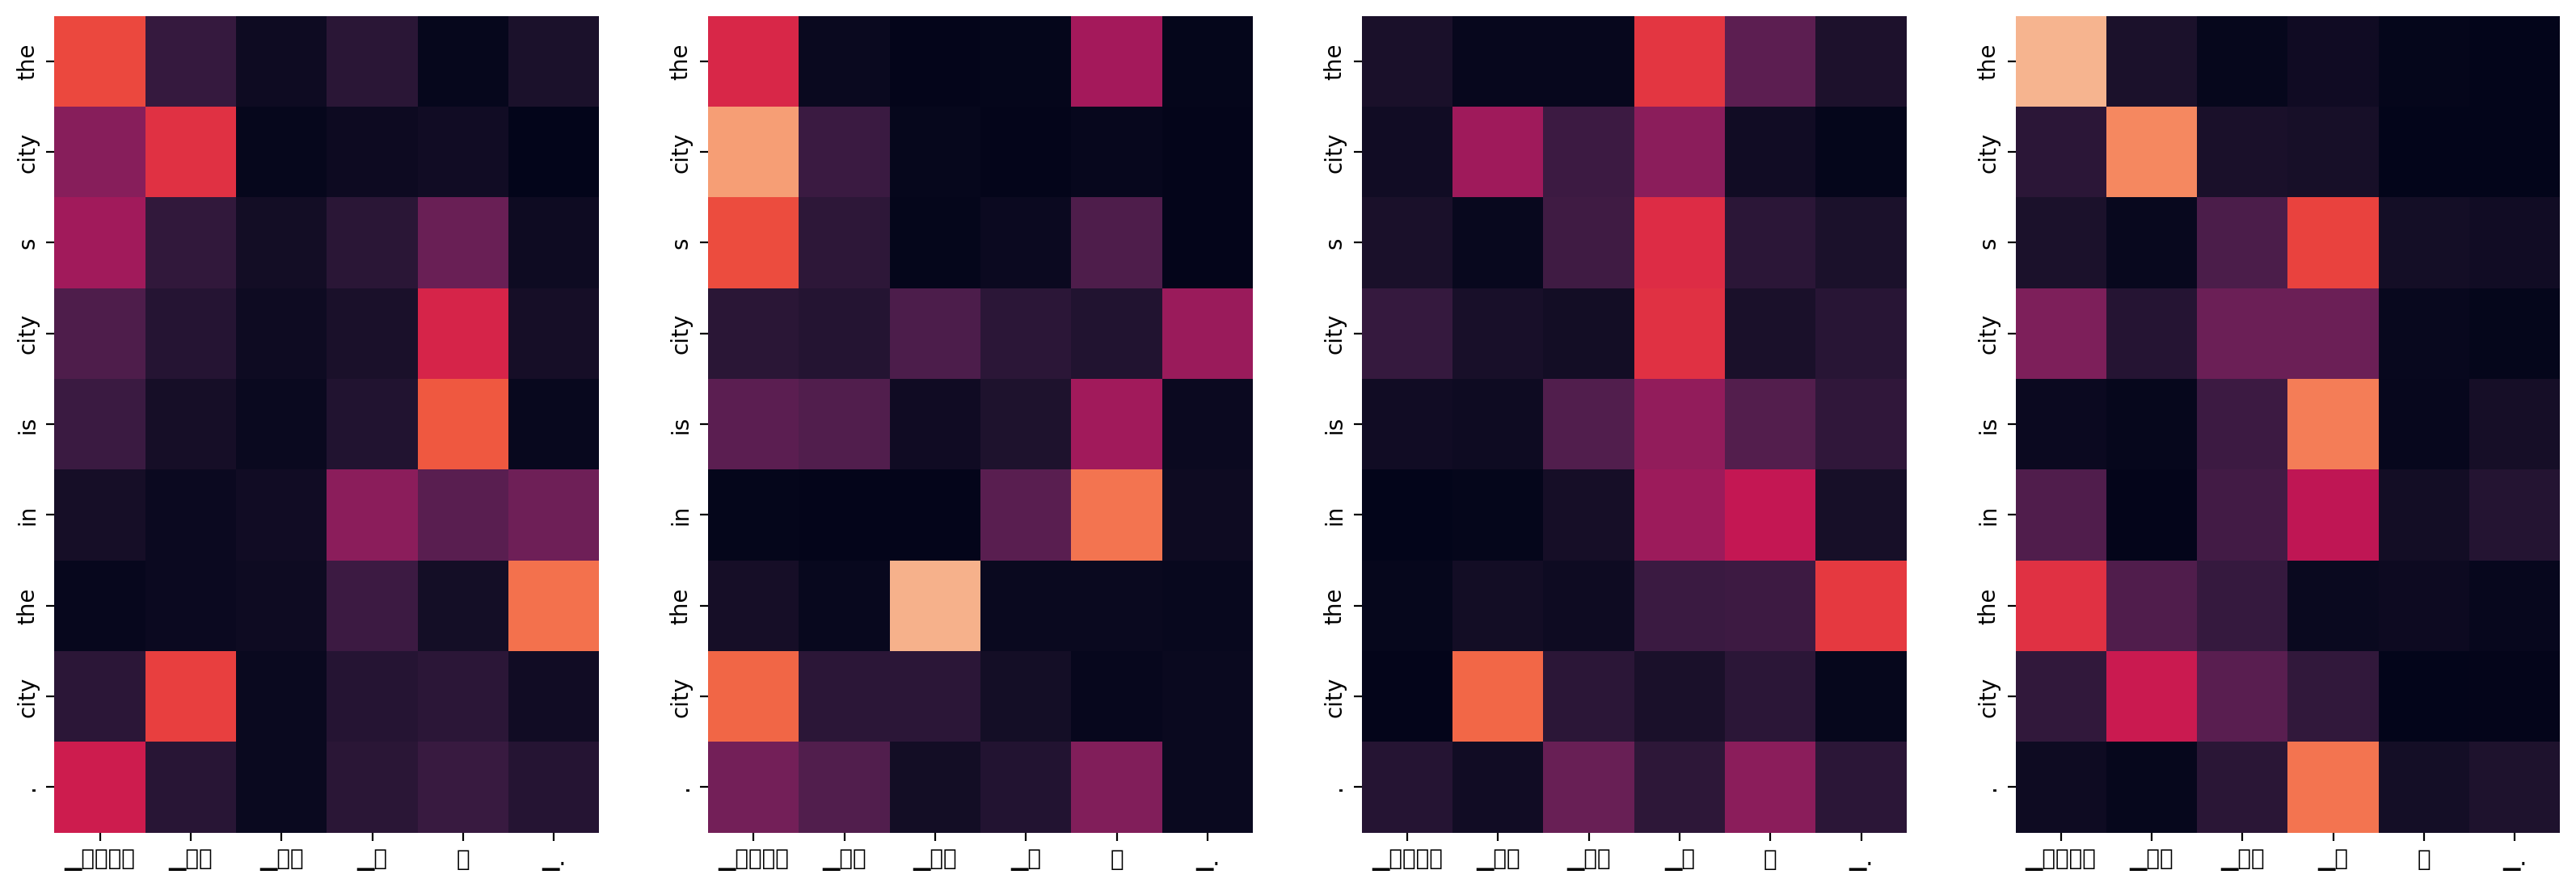

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

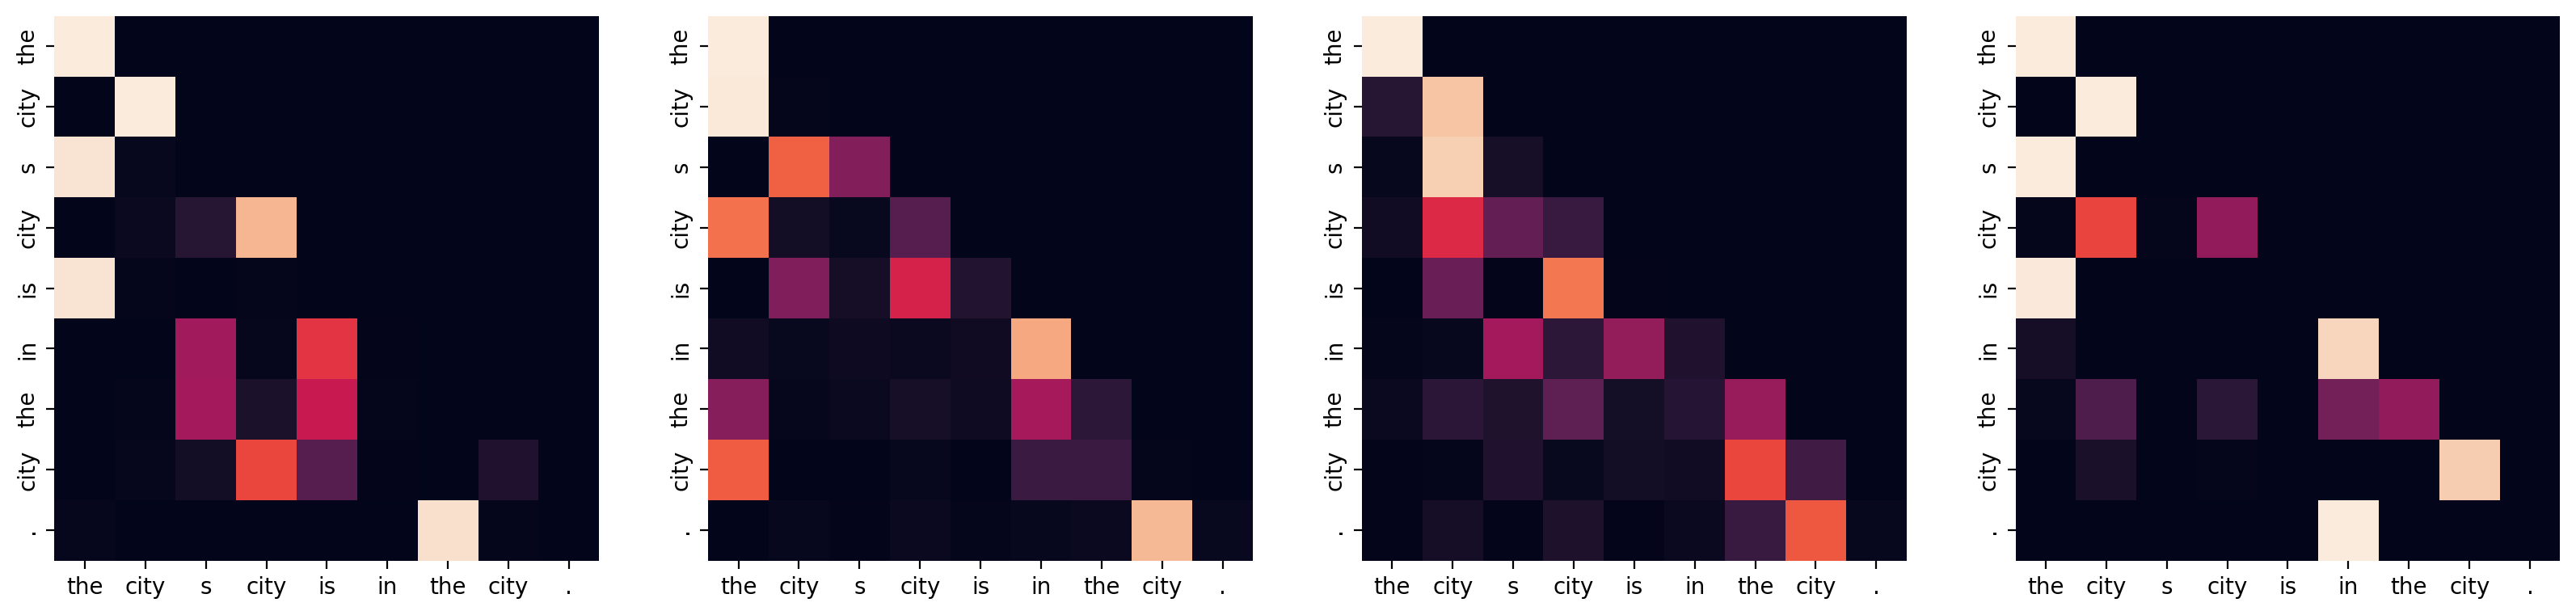

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning:

Decoder Src Layer 2


findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from c

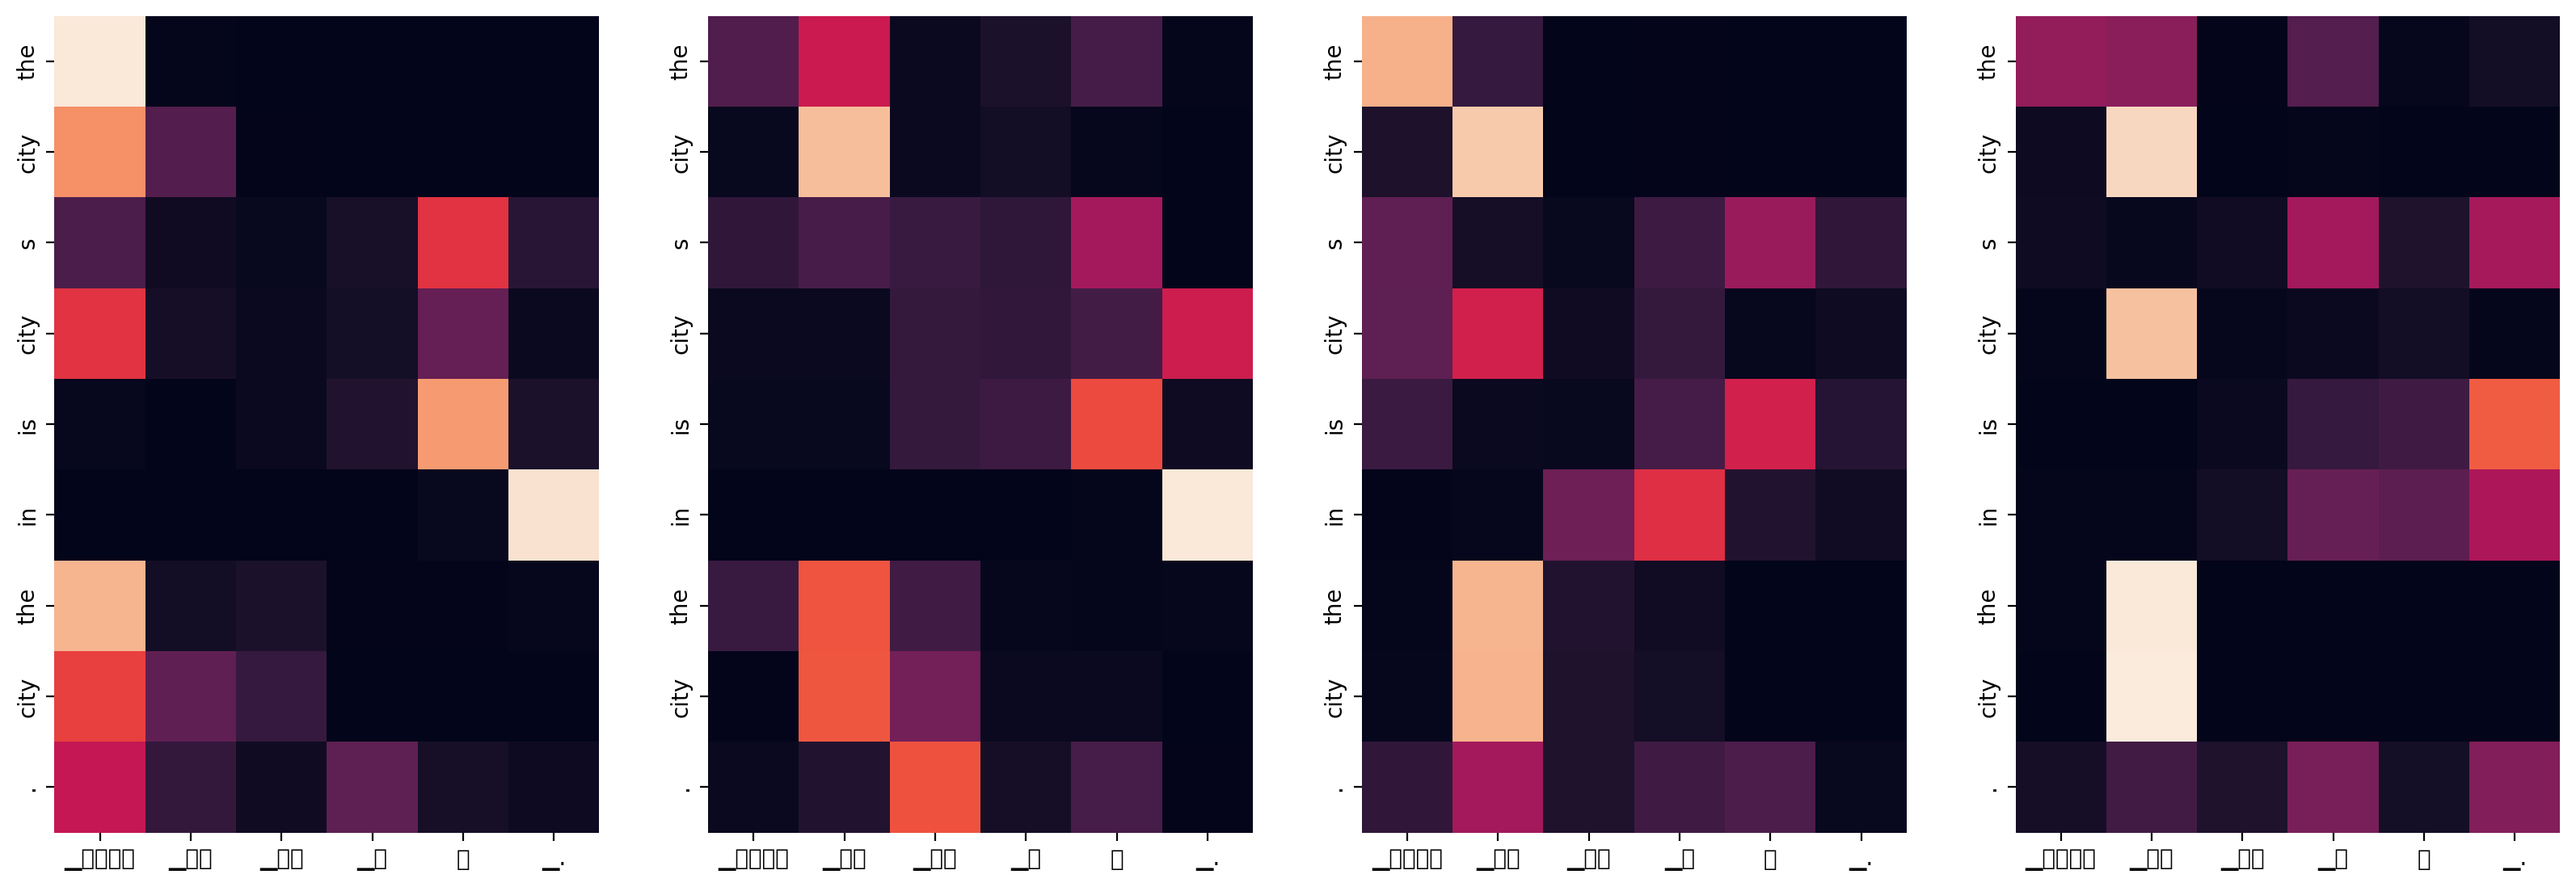

evaluate _input shape: [1 50]
Initial output shape: [1 1]
Predictions shape: [1 1 20000]
Updated output shape: [1 2]
Predictions shape: [1 2 20000]
Updated output shape: [1 3]
Predictions shape: [1 3 20000]
Updated output shape: [1 4]
Predictions shape: [1 4 20000]
Updated output shape: [1 5]
Predictions shape: [1 5 20000]
Updated output shape: [1 6]
Predictions shape: [1 6 20000]
Updated output shape: [1 7]
Predictions shape: [1 7 20000]
Updated output shape: [1 8]
Predictions shape: [1 8 20000]
Updated output shape: [1 9]
Predictions shape: [1 9 20000]
Input: 커피는 필요 없다.
Predicted translation: the coffee is not enough to be .


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/pytho

Encoder Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

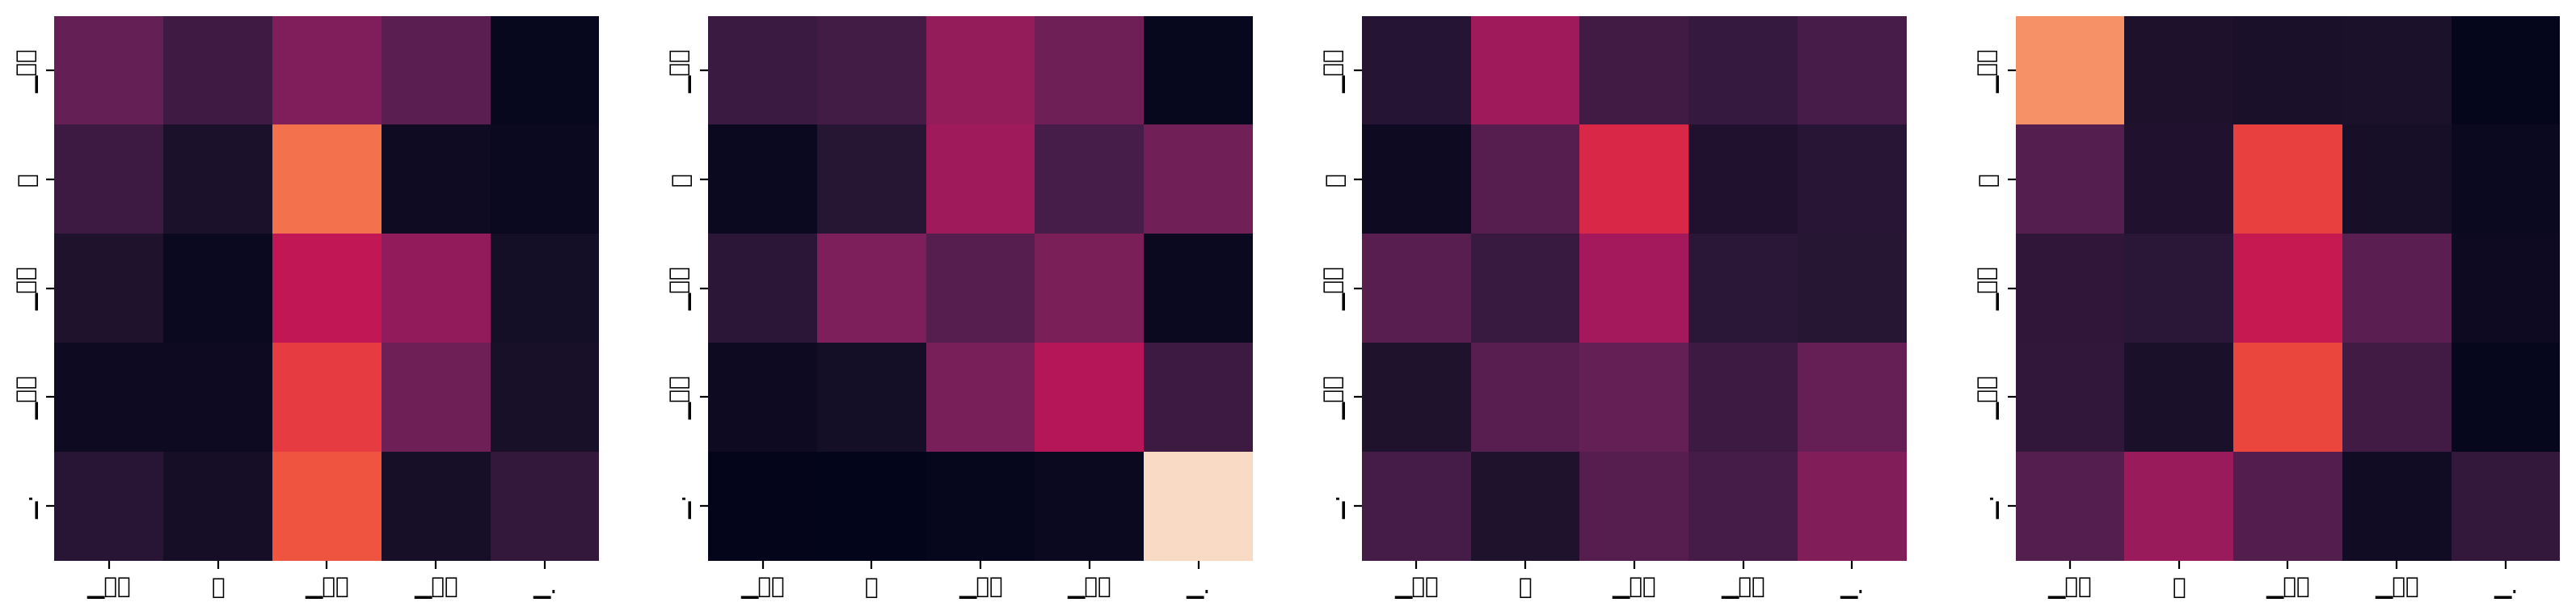

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/pytho

Encoder Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

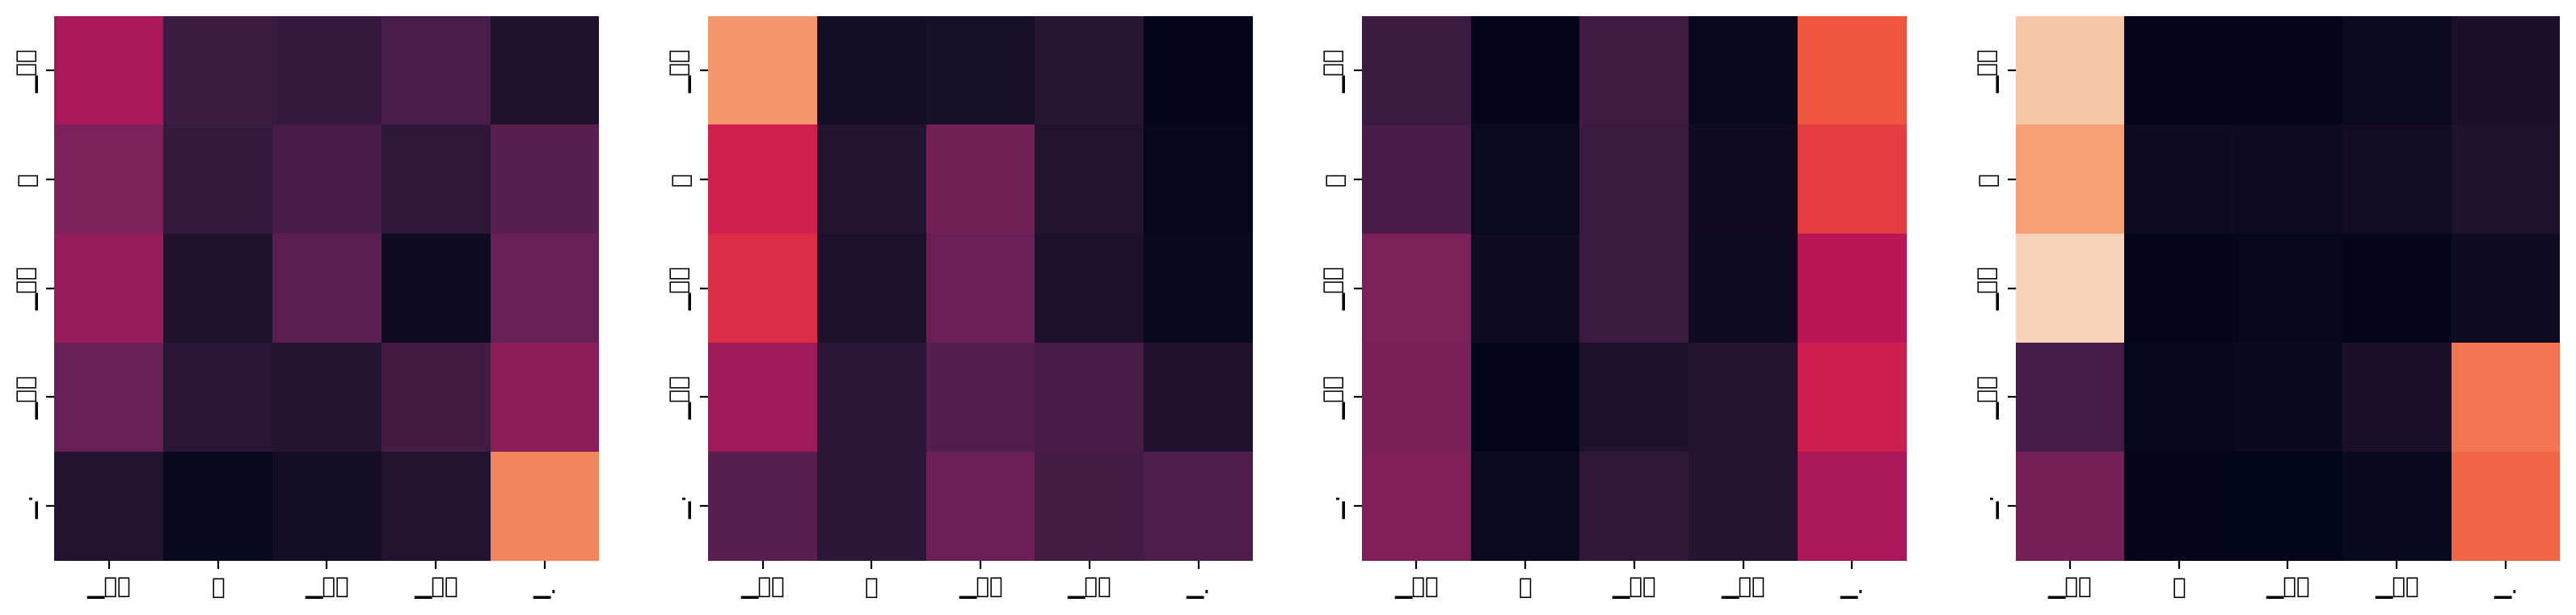

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

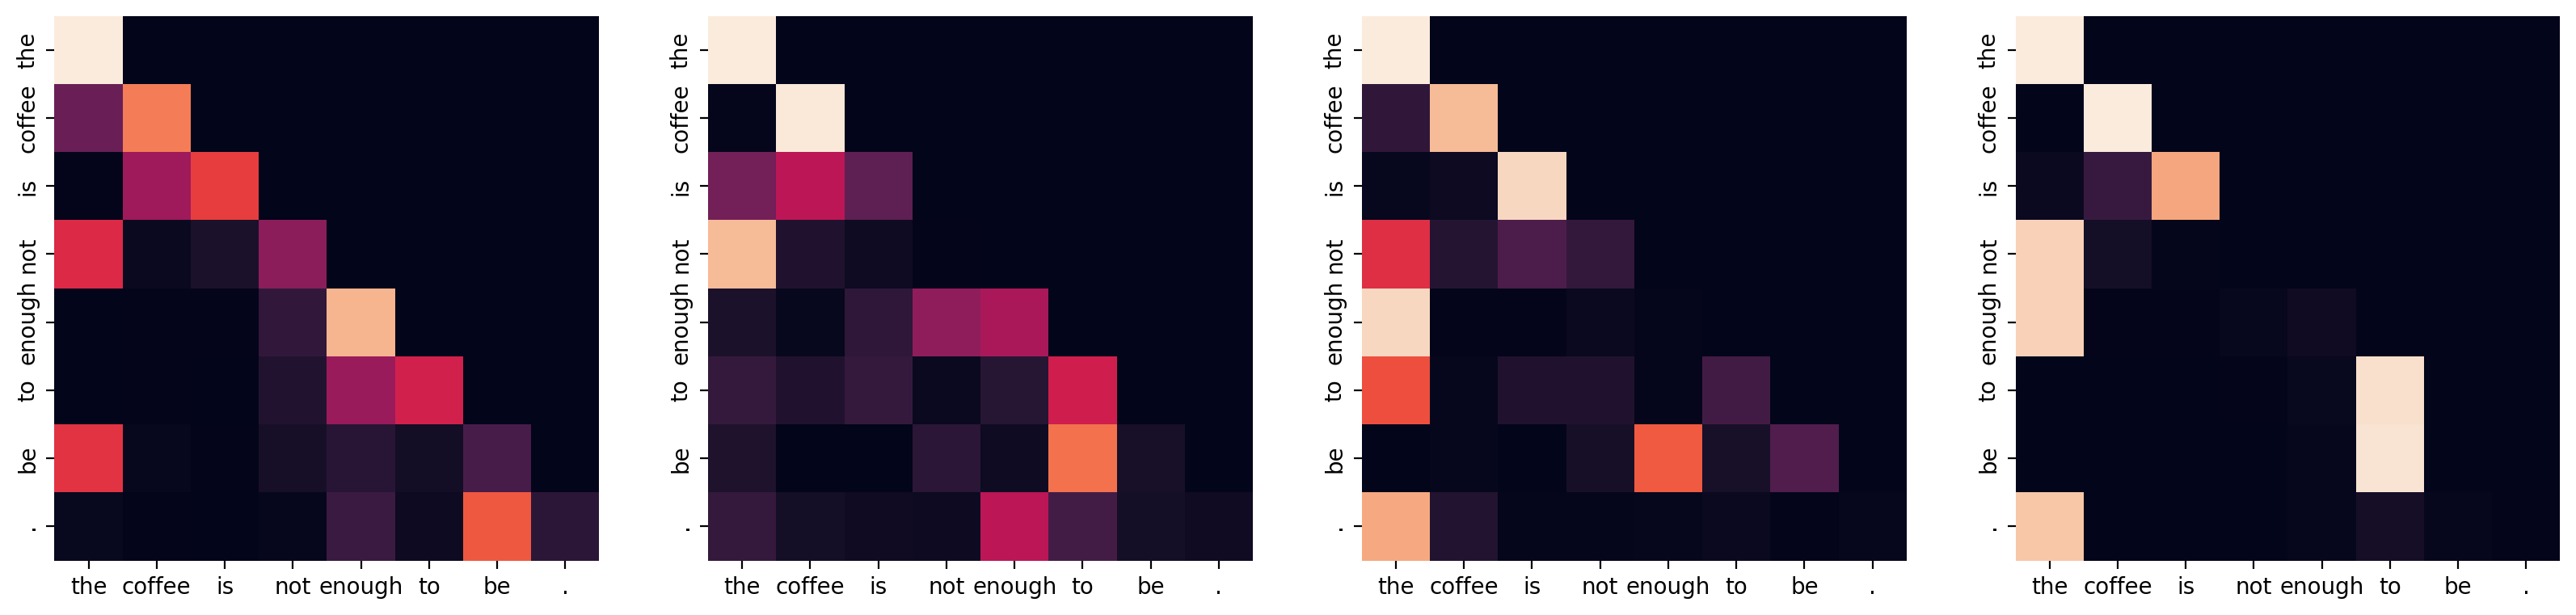

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/pytho

Decoder Src Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

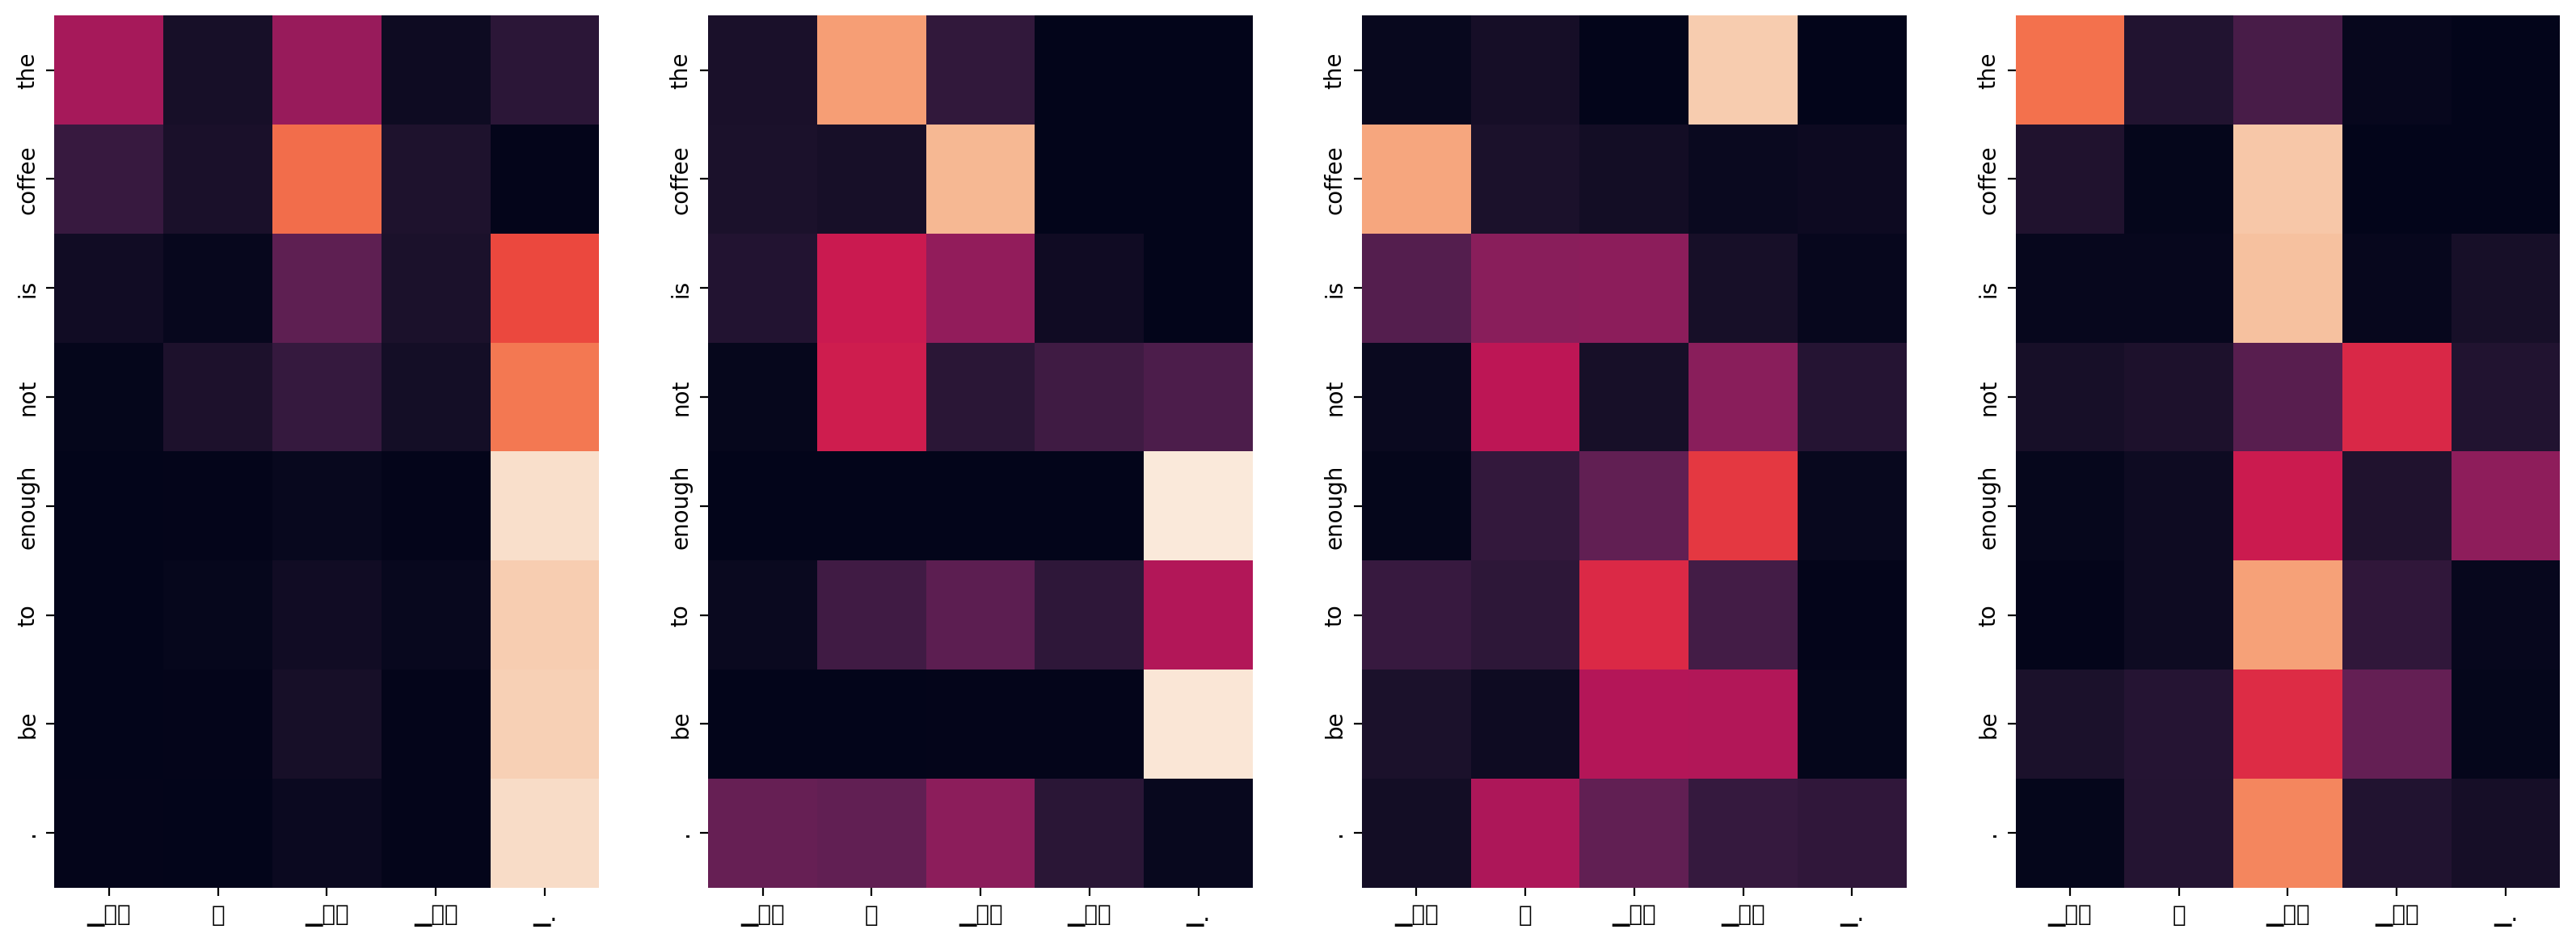

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

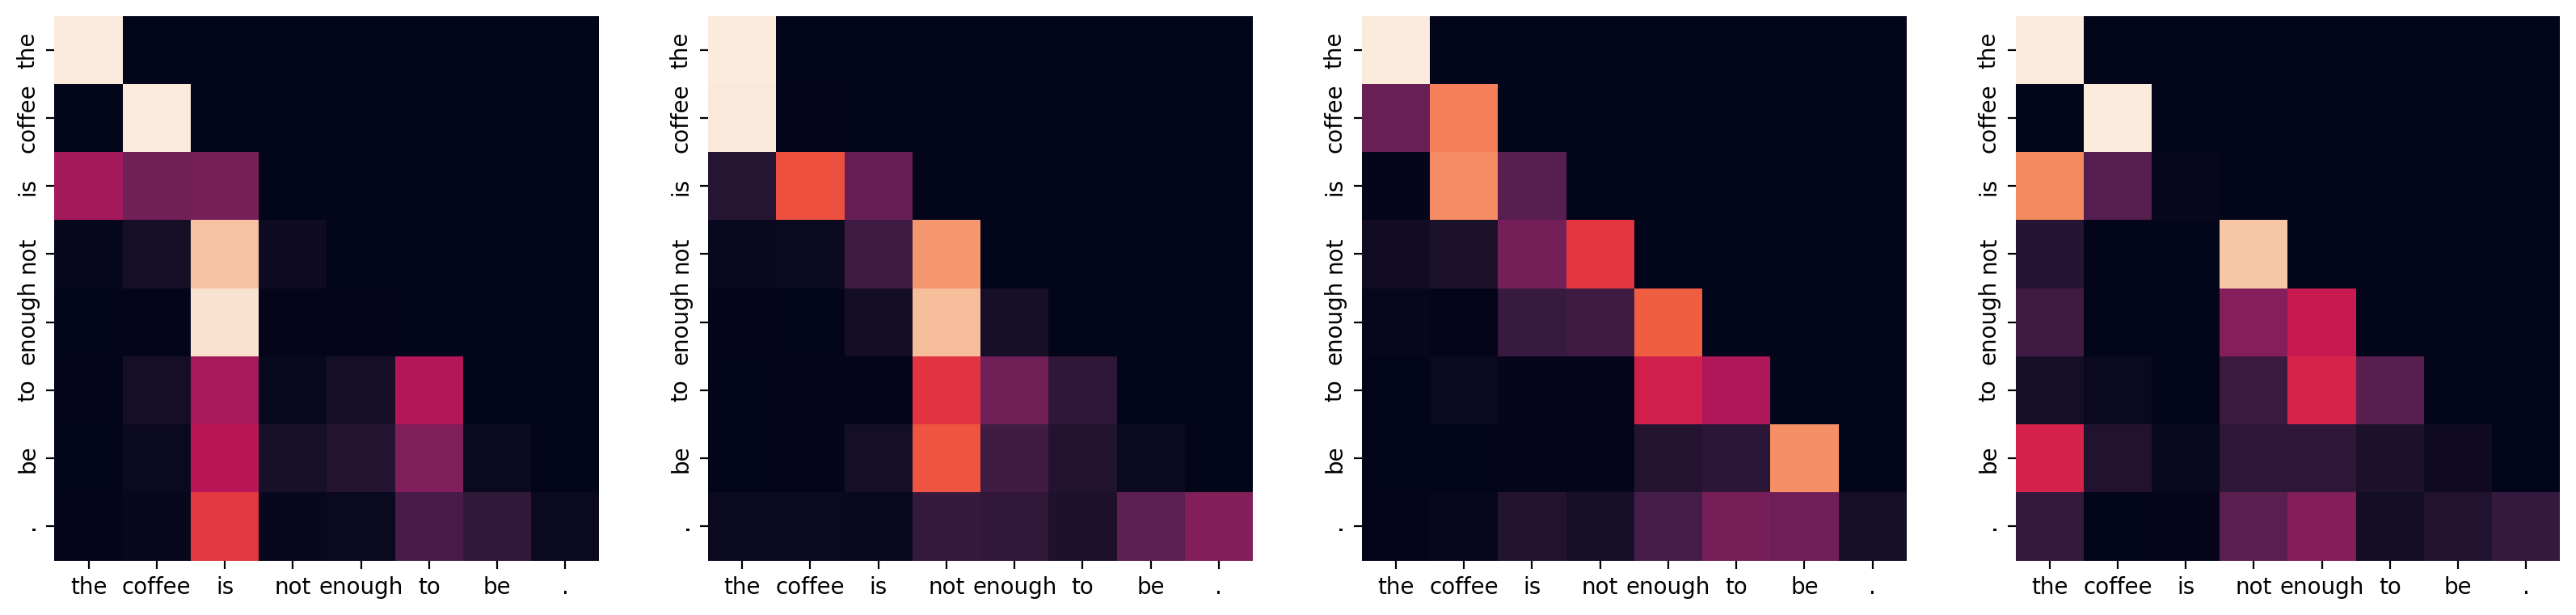

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/pytho

Decoder Src Layer 2


findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning:

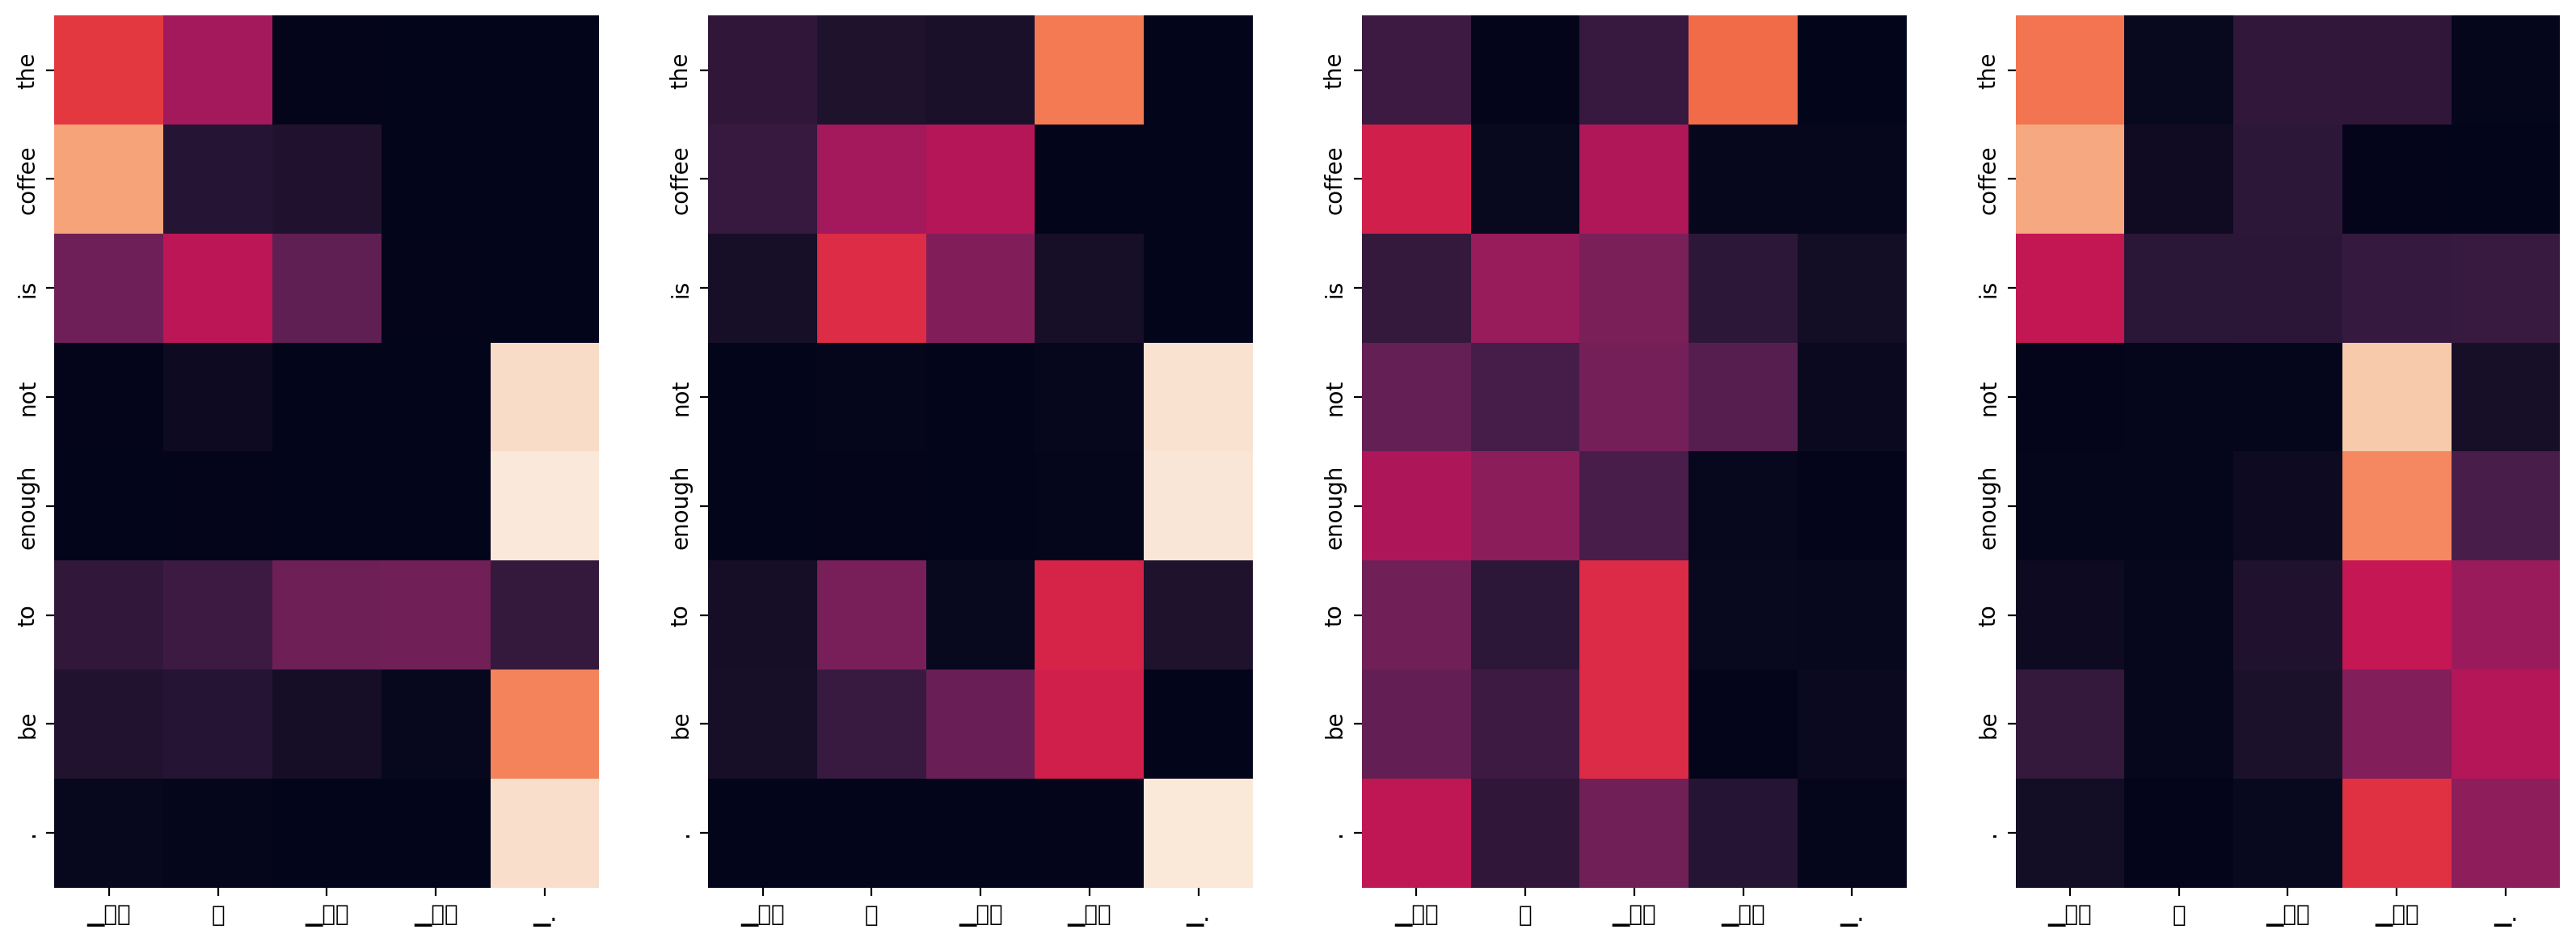

evaluate _input shape: [1 50]
Initial output shape: [1 1]
Predictions shape: [1 1 20000]
Updated output shape: [1 2]
Predictions shape: [1 2 20000]
Updated output shape: [1 3]
Predictions shape: [1 3 20000]
Updated output shape: [1 4]
Predictions shape: [1 4 20000]
Updated output shape: [1 5]
Predictions shape: [1 5 20000]
Updated output shape: [1 6]
Predictions shape: [1 6 20000]
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were killed .


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44273 (\N{HANGUL SYLLABLE GOB}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/pyth

Encoder Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

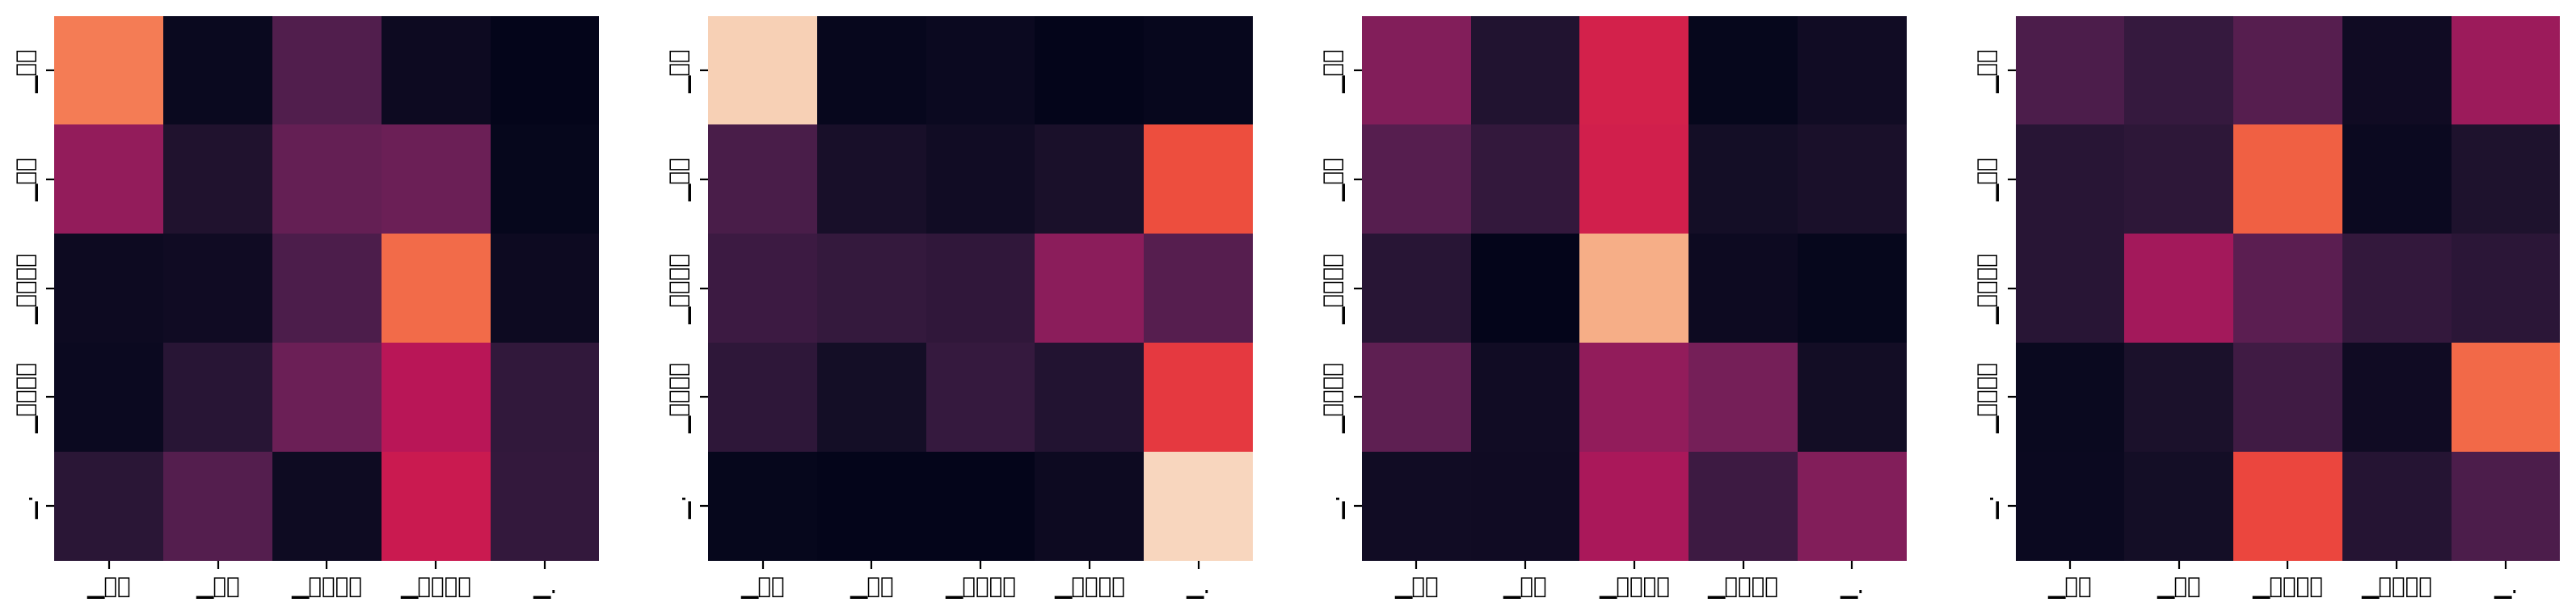

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44273 (\N{HANGUL SYLLABLE GOB}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/pyth

Encoder Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

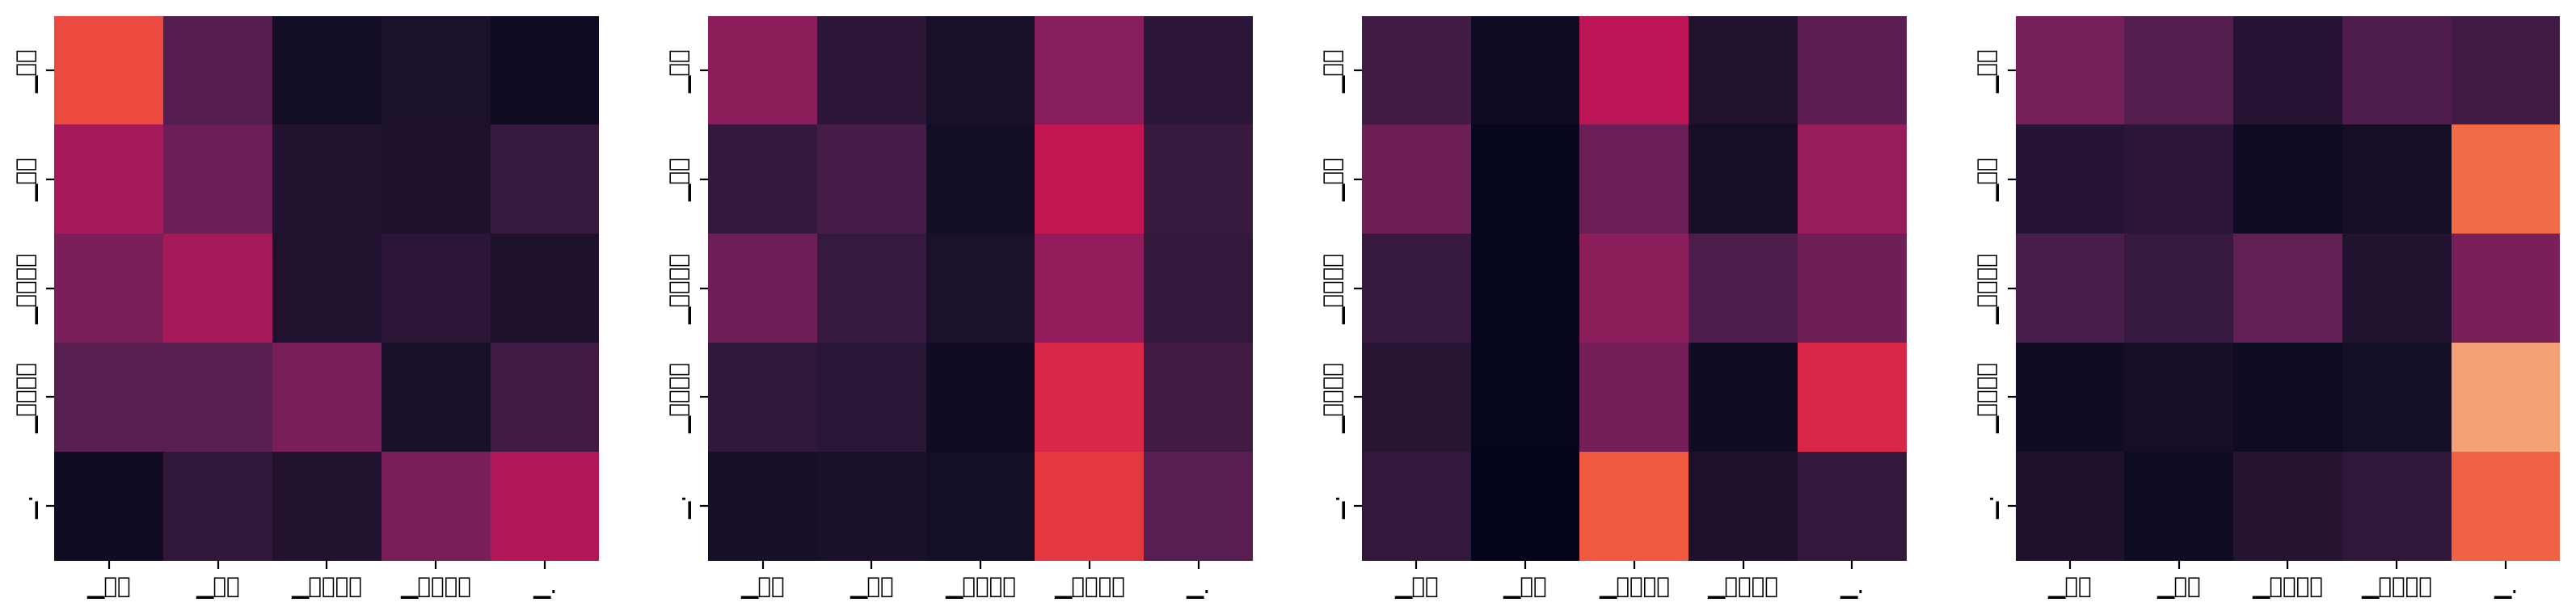

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

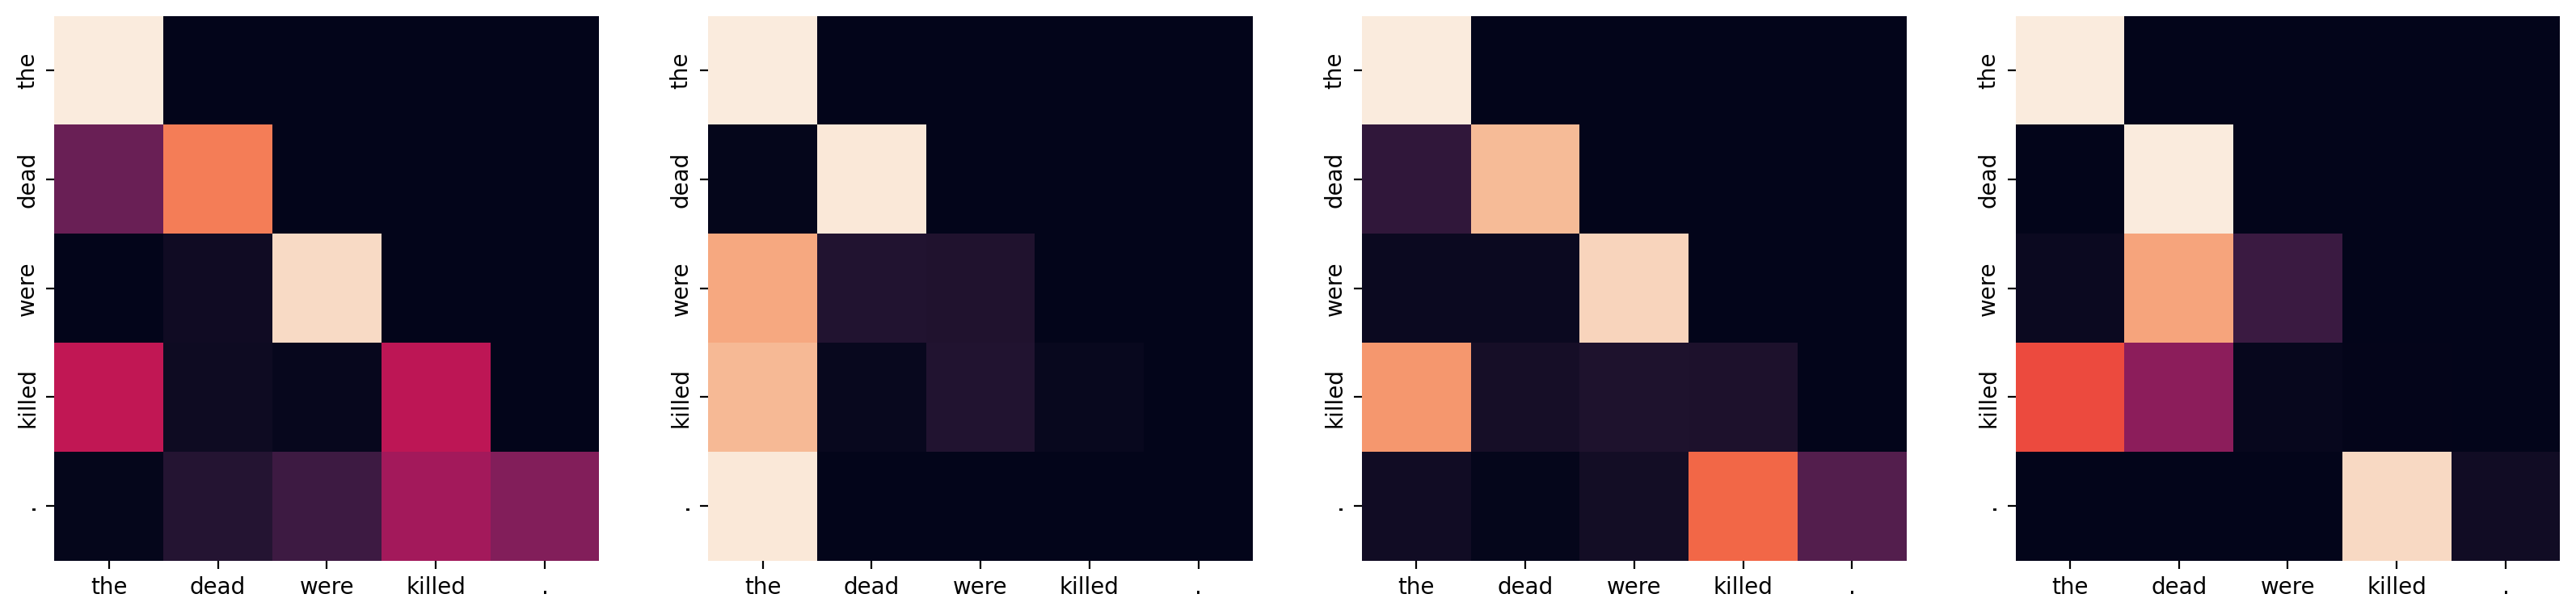

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44273 (\N{HANGUL SYLLABLE GOB}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/pyth

Decoder Src Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44273 (\N{HANGUL SYLLABLE GOB}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.dr

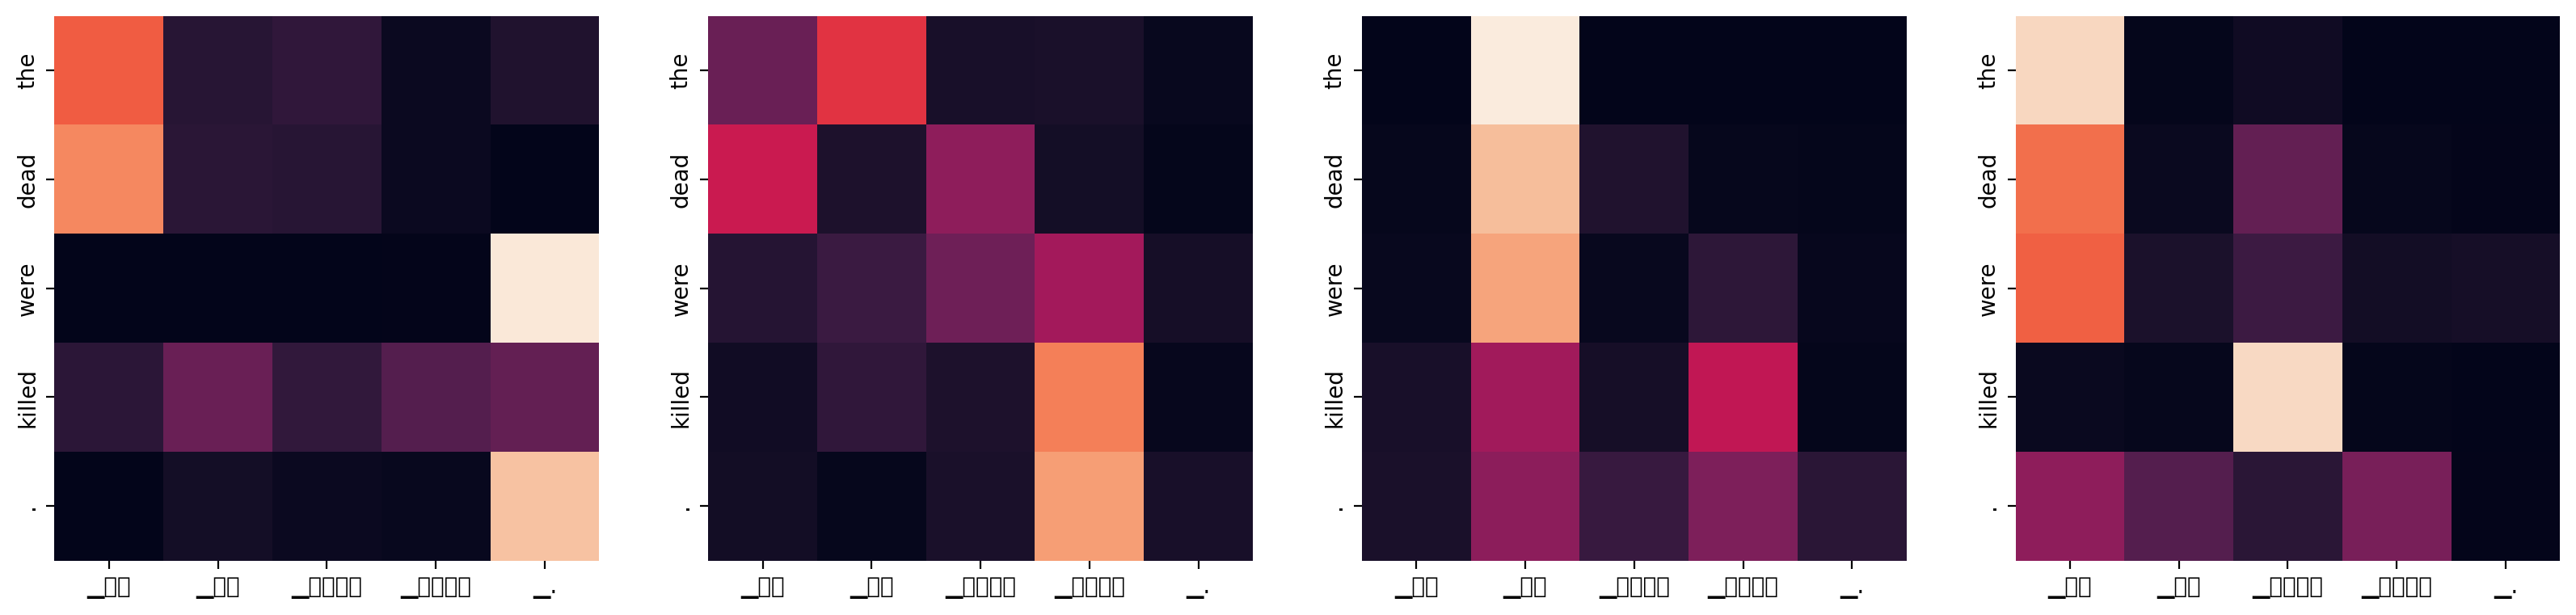

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

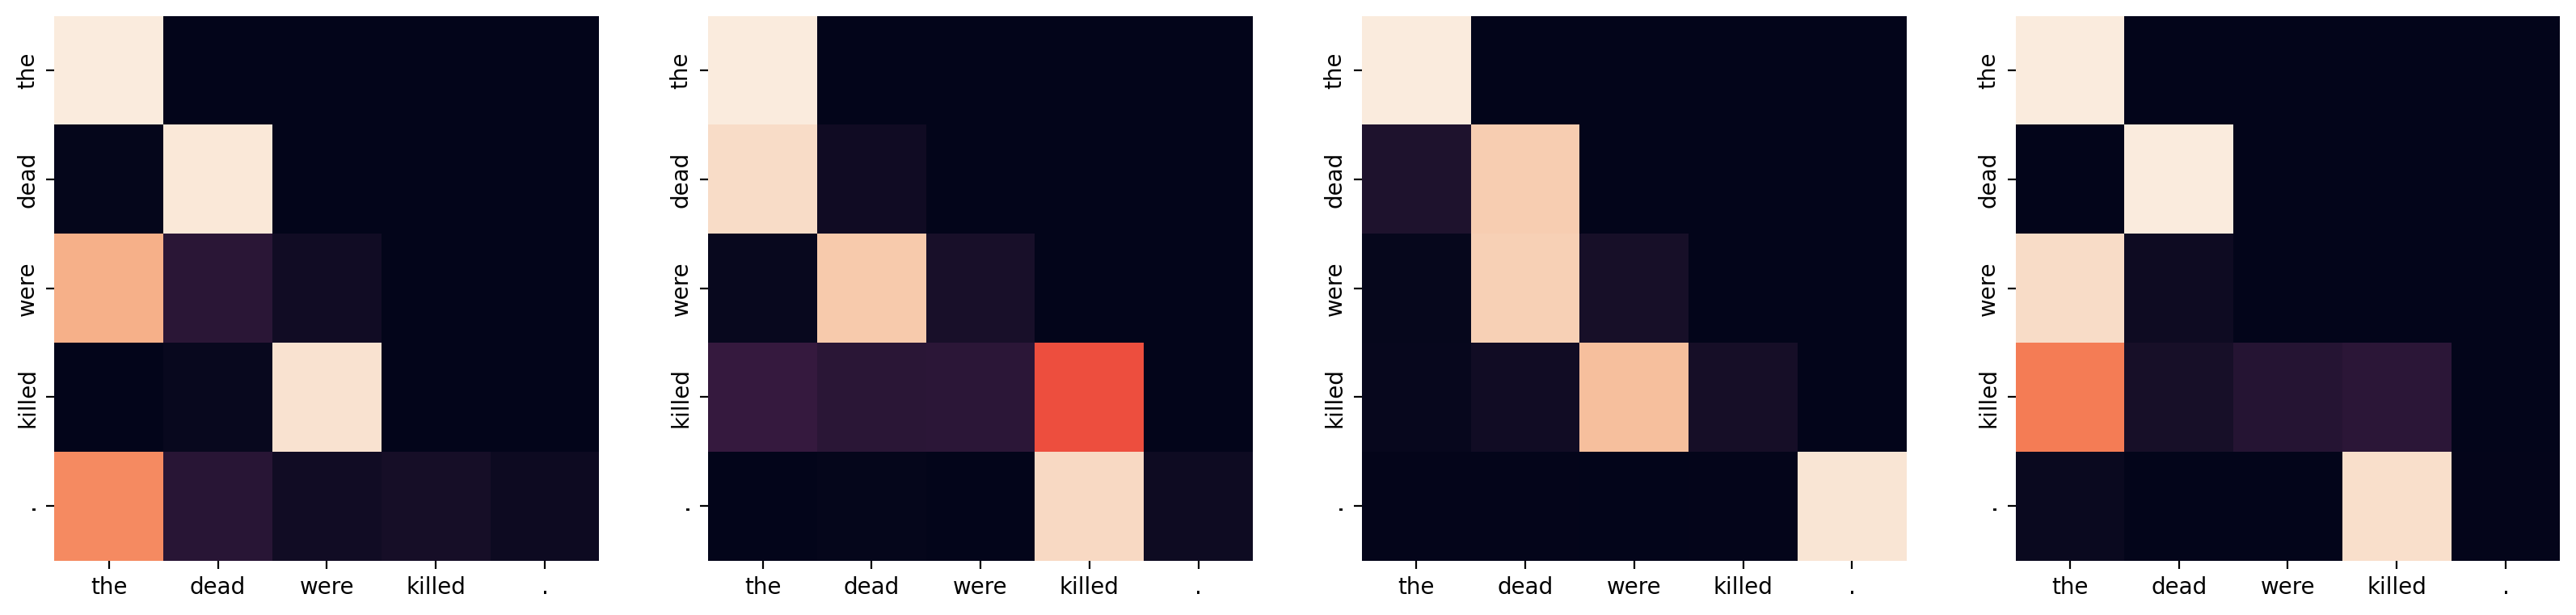

Decoder Src Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44273 (\N{HANGUL SYLLABLE GOB}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/pyth

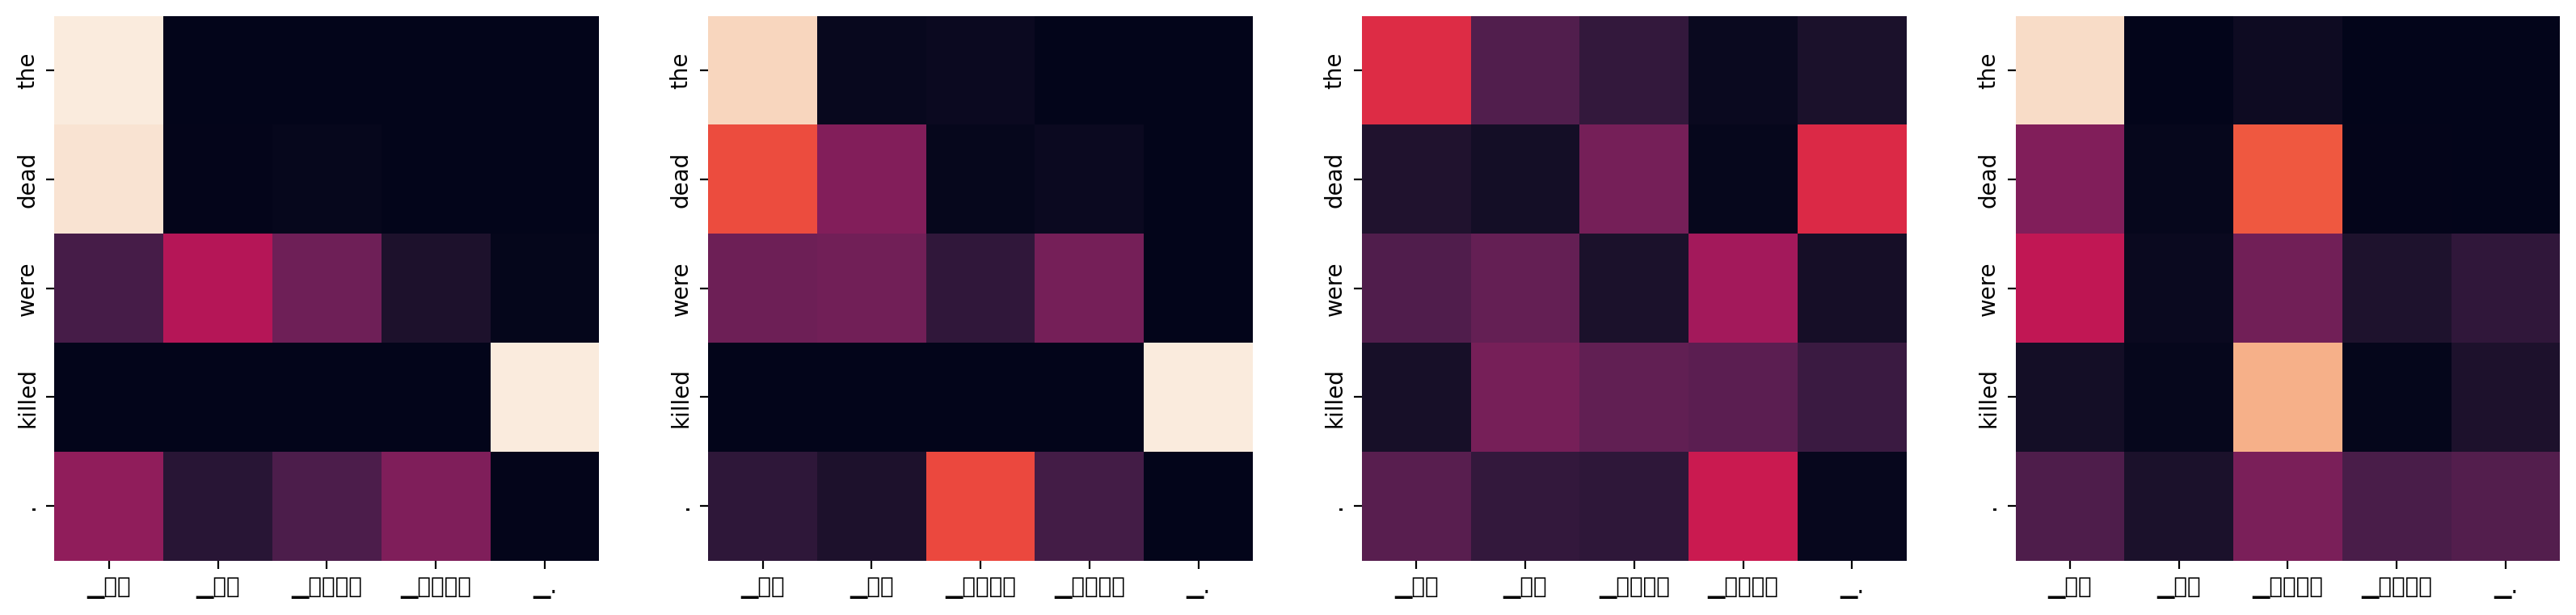

/tmp/ipykernel_914/1729361234.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1180 [00:00<?, ?it/s]

evaluate _input shape: [1 50]
Initial output shape: [1 1]
Predictions shape: [1 1 20000]
Updated output shape: [1 2]
Predictions shape: [1 2 20000]
Updated output shape: [1 3]
Predictions shape: [1 3 20000]
Updated output shape: [1 4]
Predictions shape: [1 4 20000]
Updated output shape: [1 5]
Predictions shape: [1 5 20000]
Updated output shape: [1 6]
Predictions shape: [1 6 20000]
Updated output shape: [1 7]
Predictions shape: [1 7 20000]
Updated output shape: [1 8]
Predictions shape: [1 8 20000]
Updated output shape: [1 9]
Predictions shape: [1 9 20000]
Updated output shape: [1 10]
Predictions shape: [1 10 20000]
Updated output shape: [1 11]
Predictions shape: [1 11 20000]
Input: 오바마는 대통령이다.
Predicted translation: the president is the president s most important step .


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Gl

Encoder Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

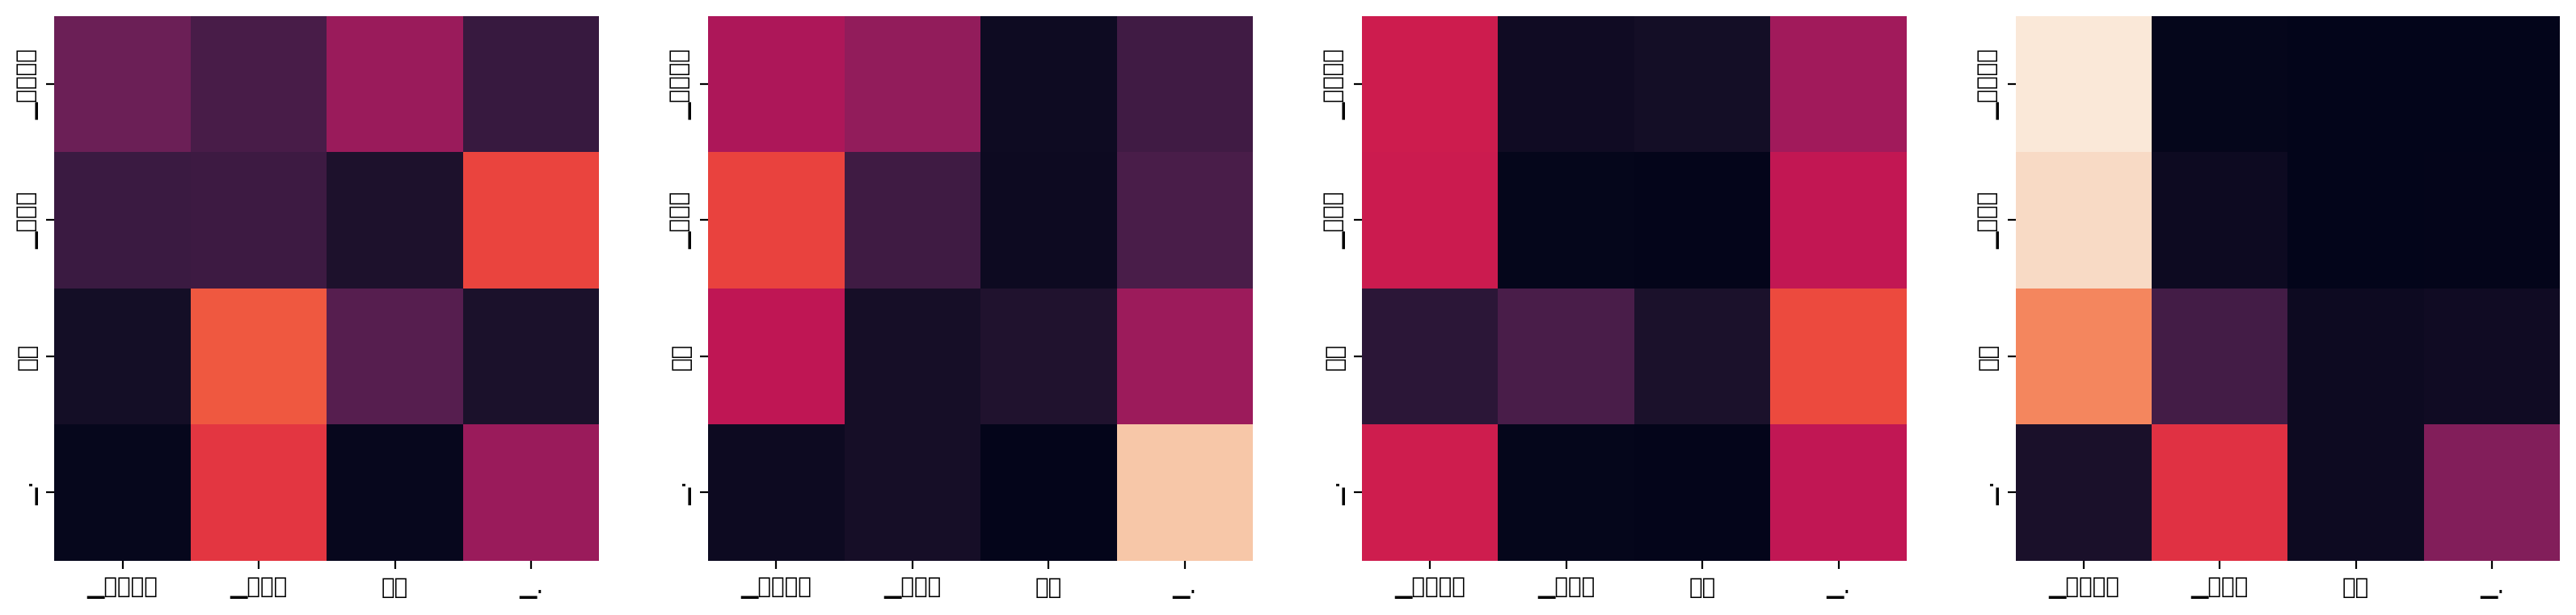

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Gl

Encoder Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

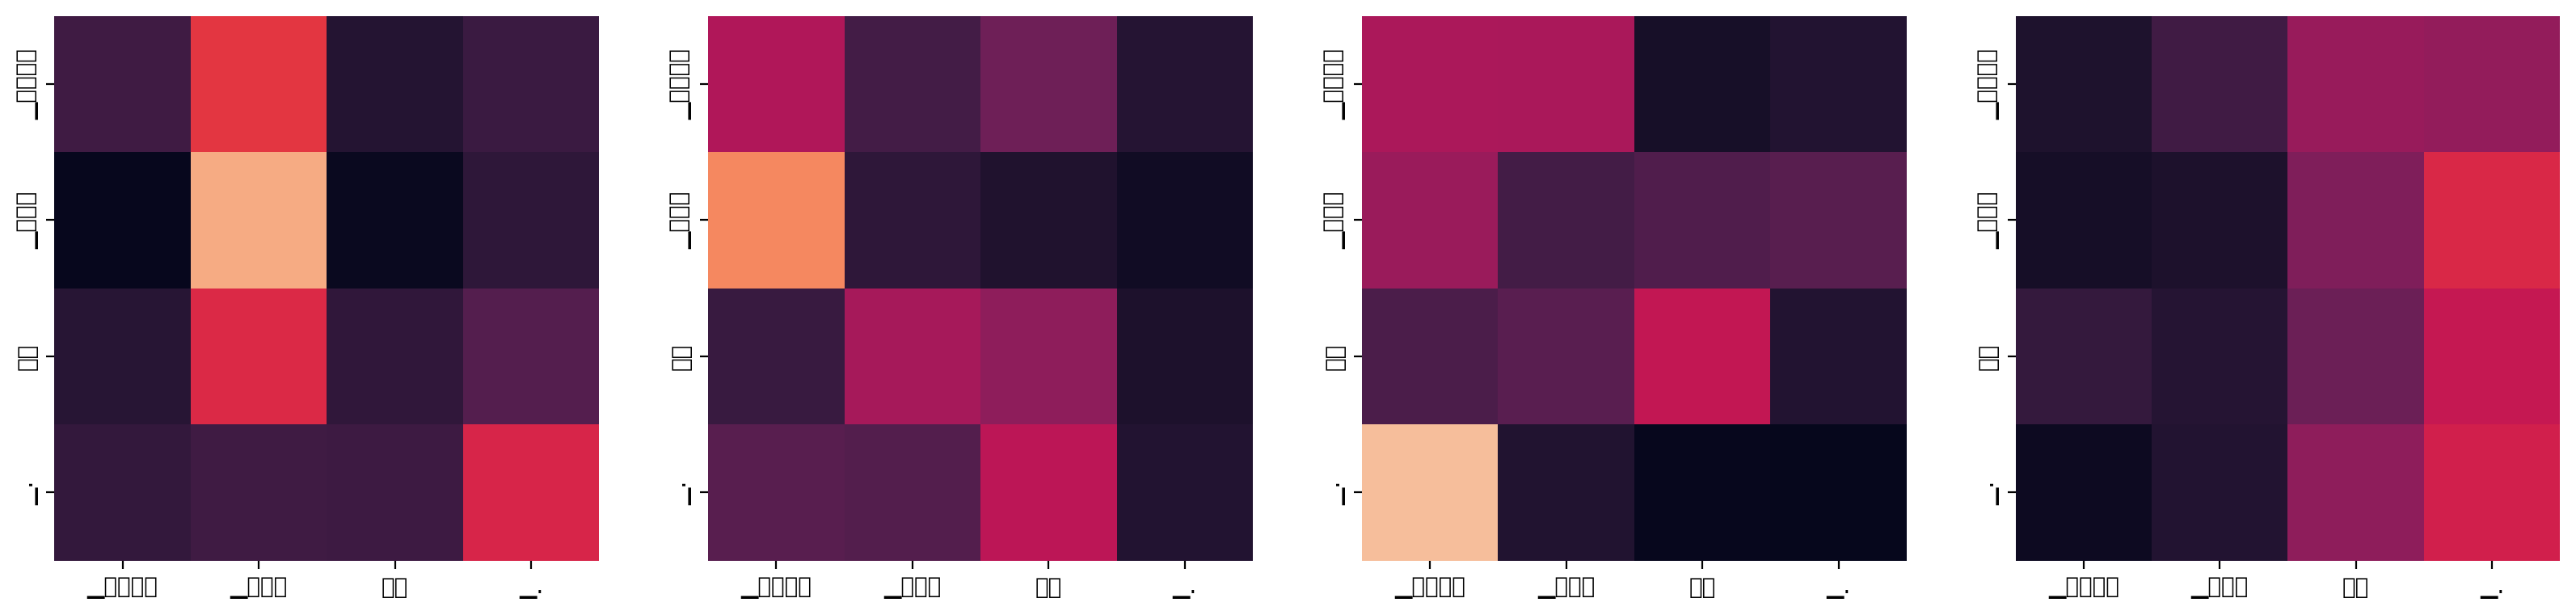

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

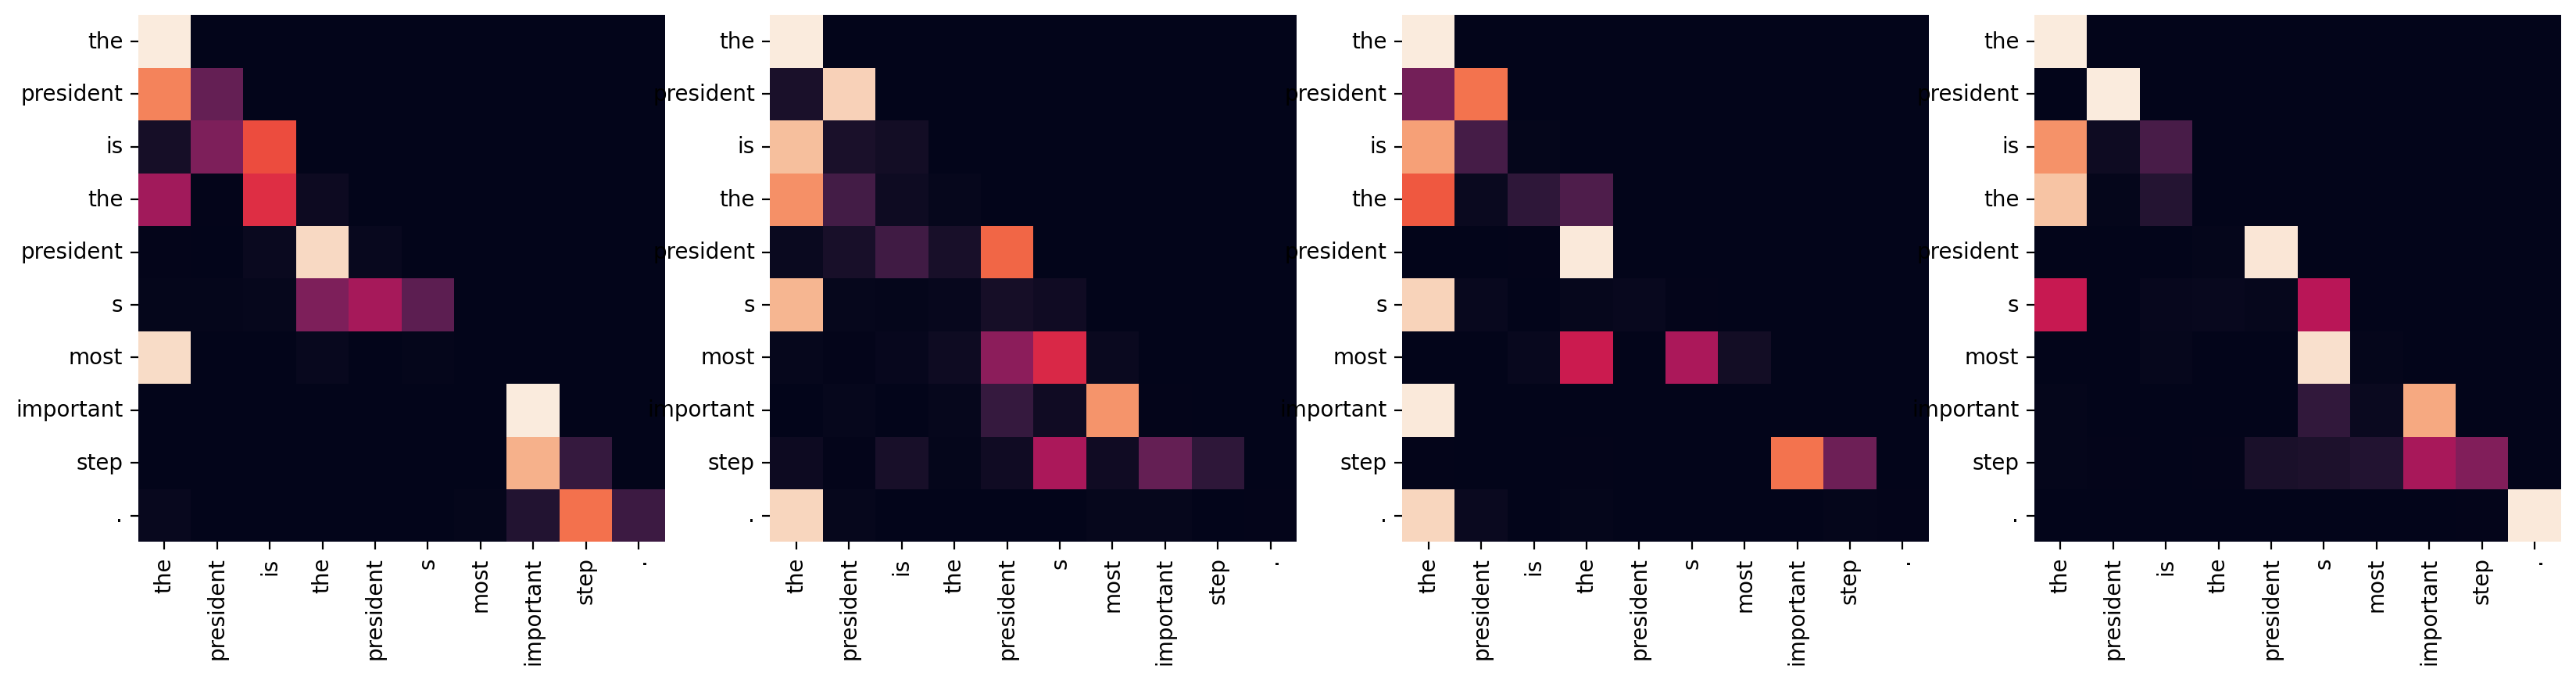

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Gl

Decoder Src Layer 1


findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from cur

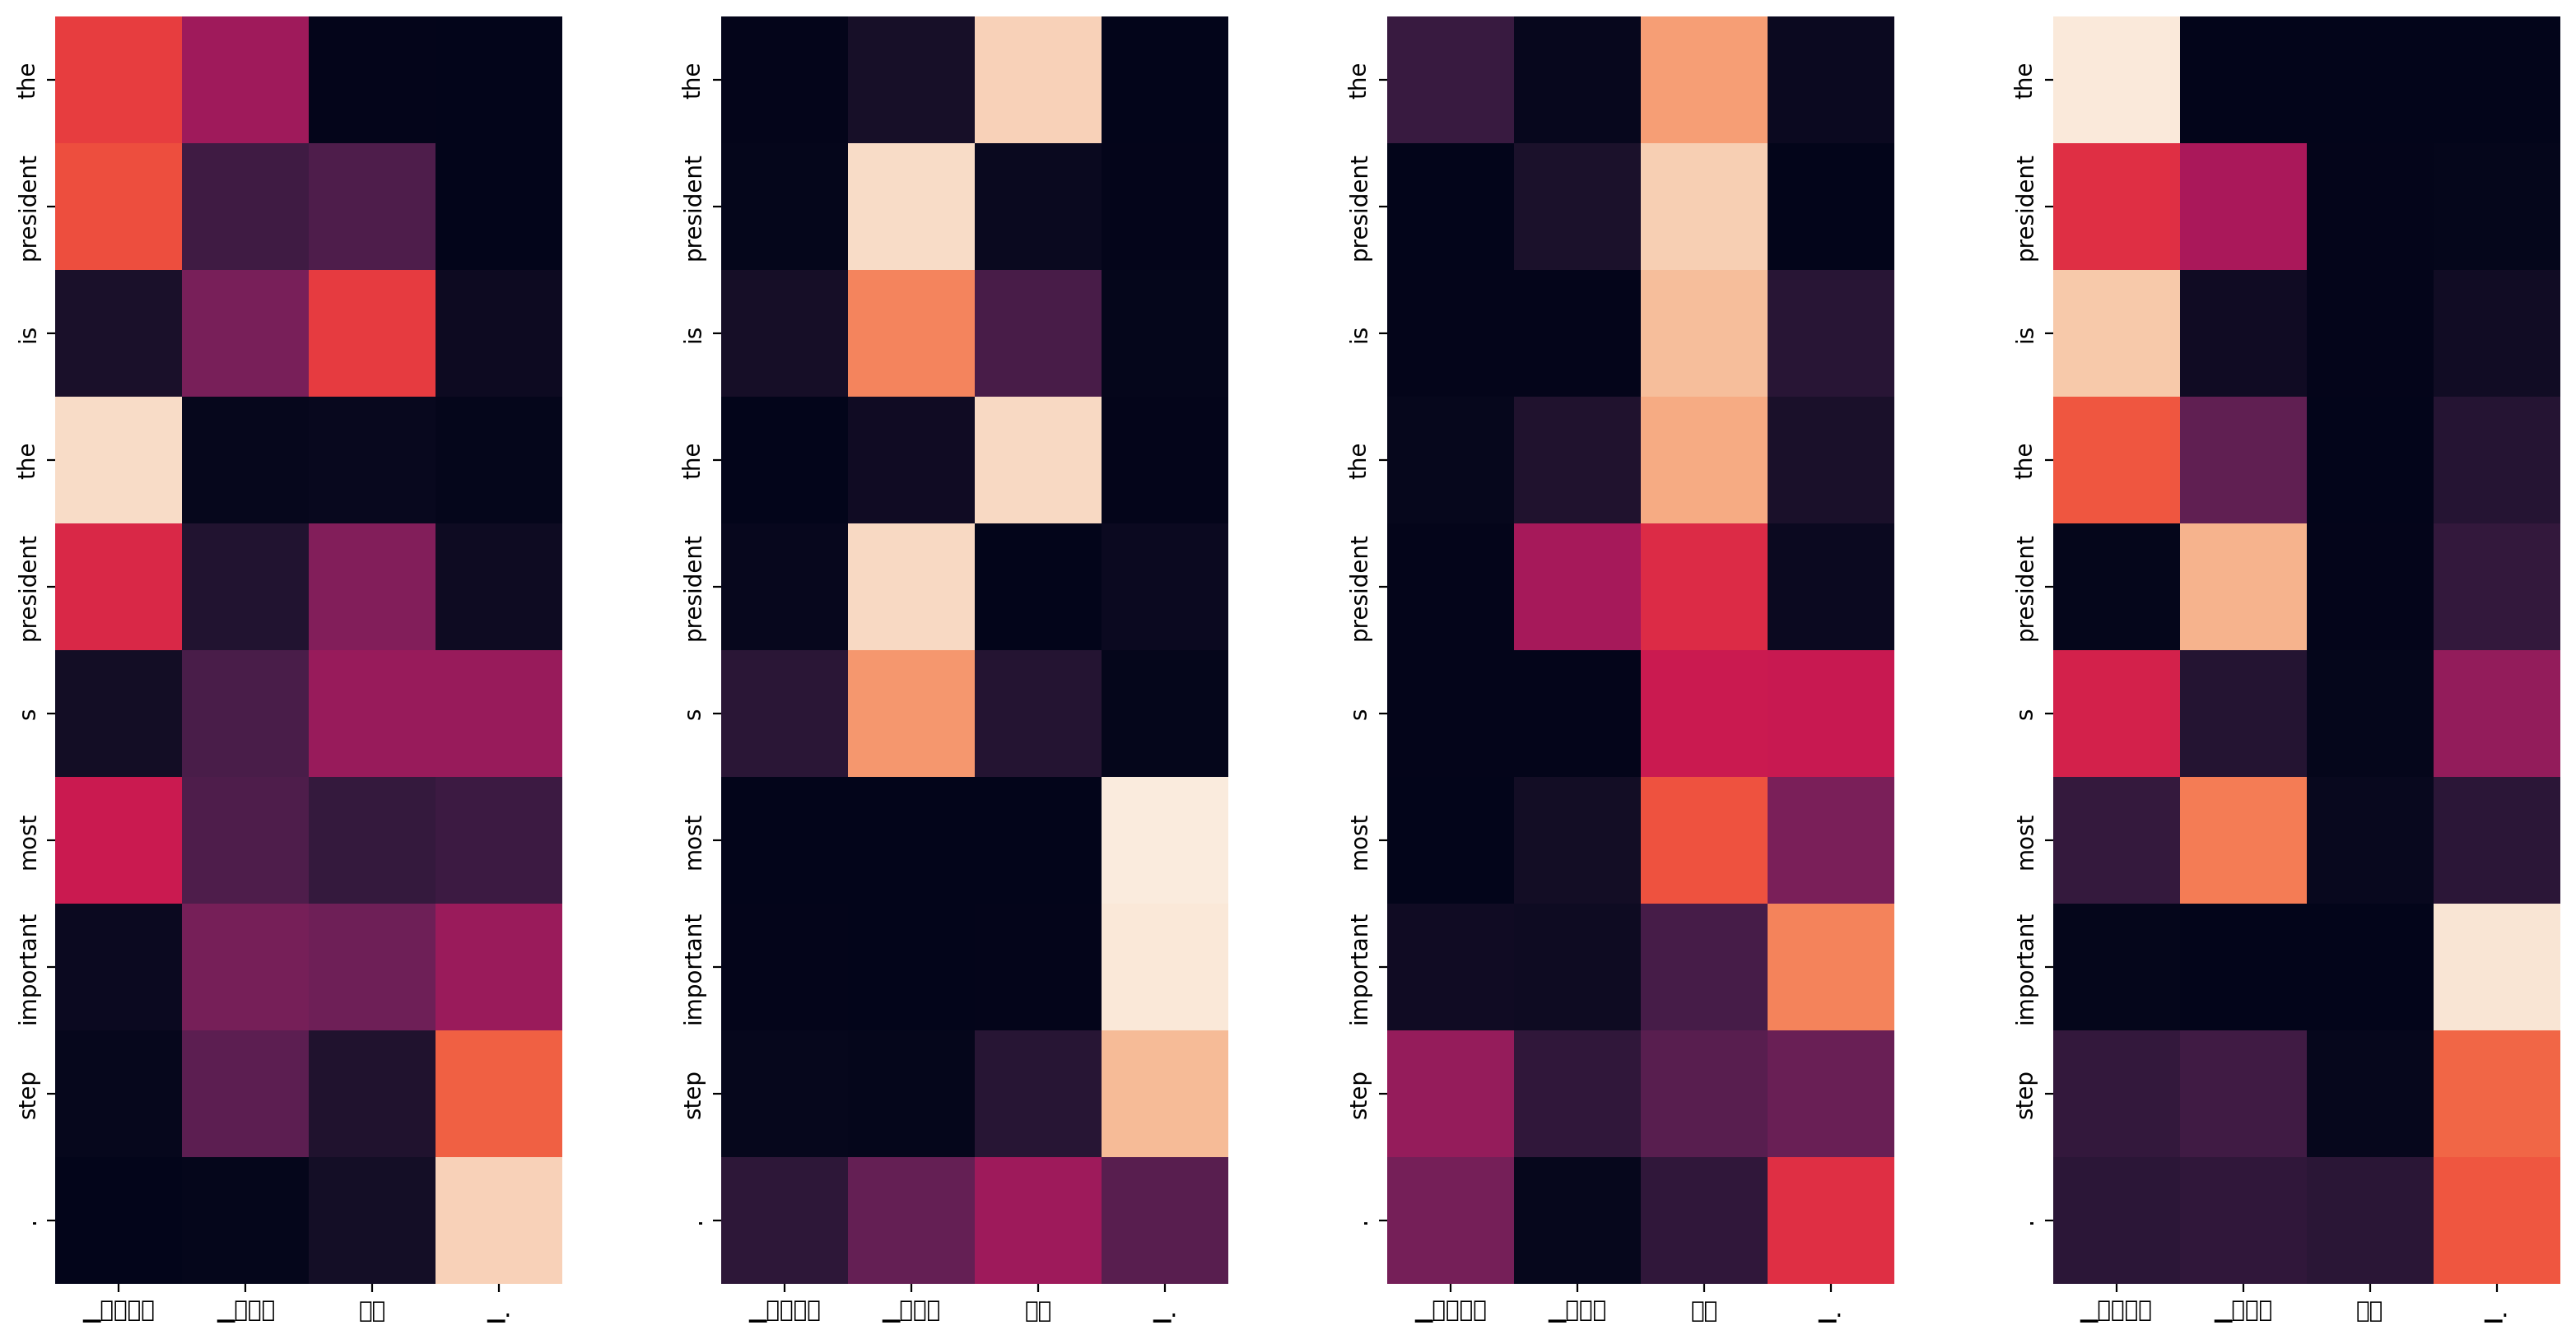

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

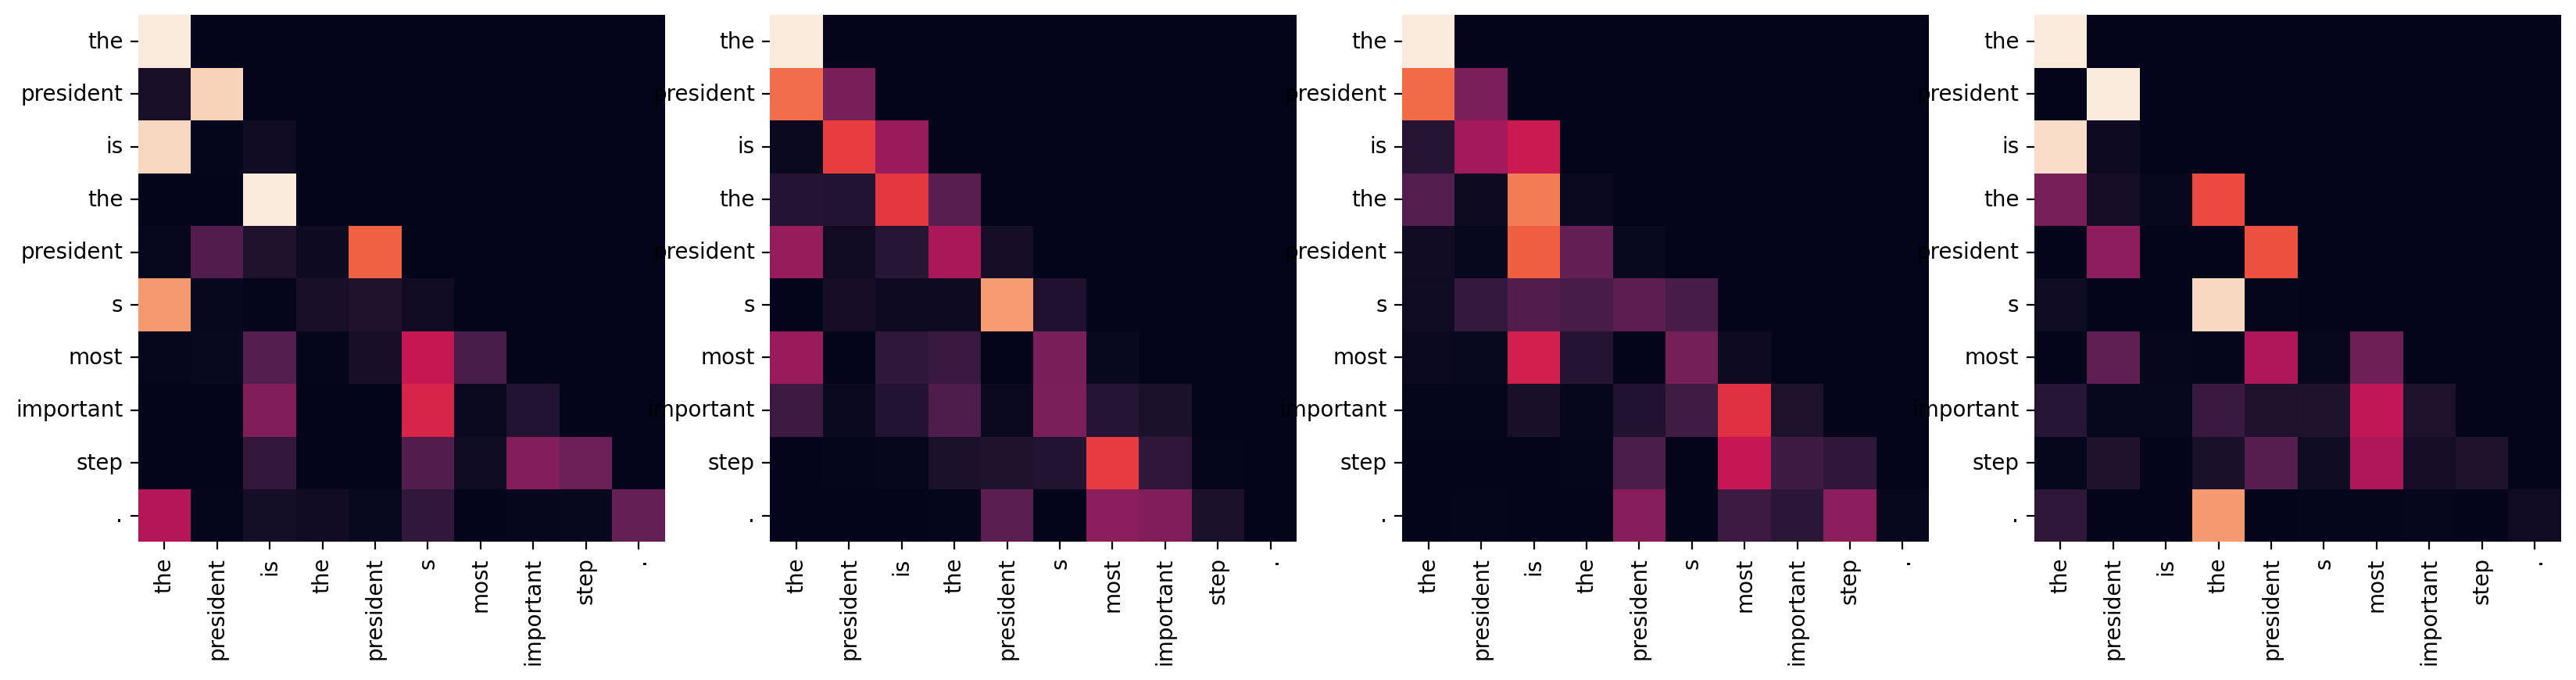

Decoder Src Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Gl

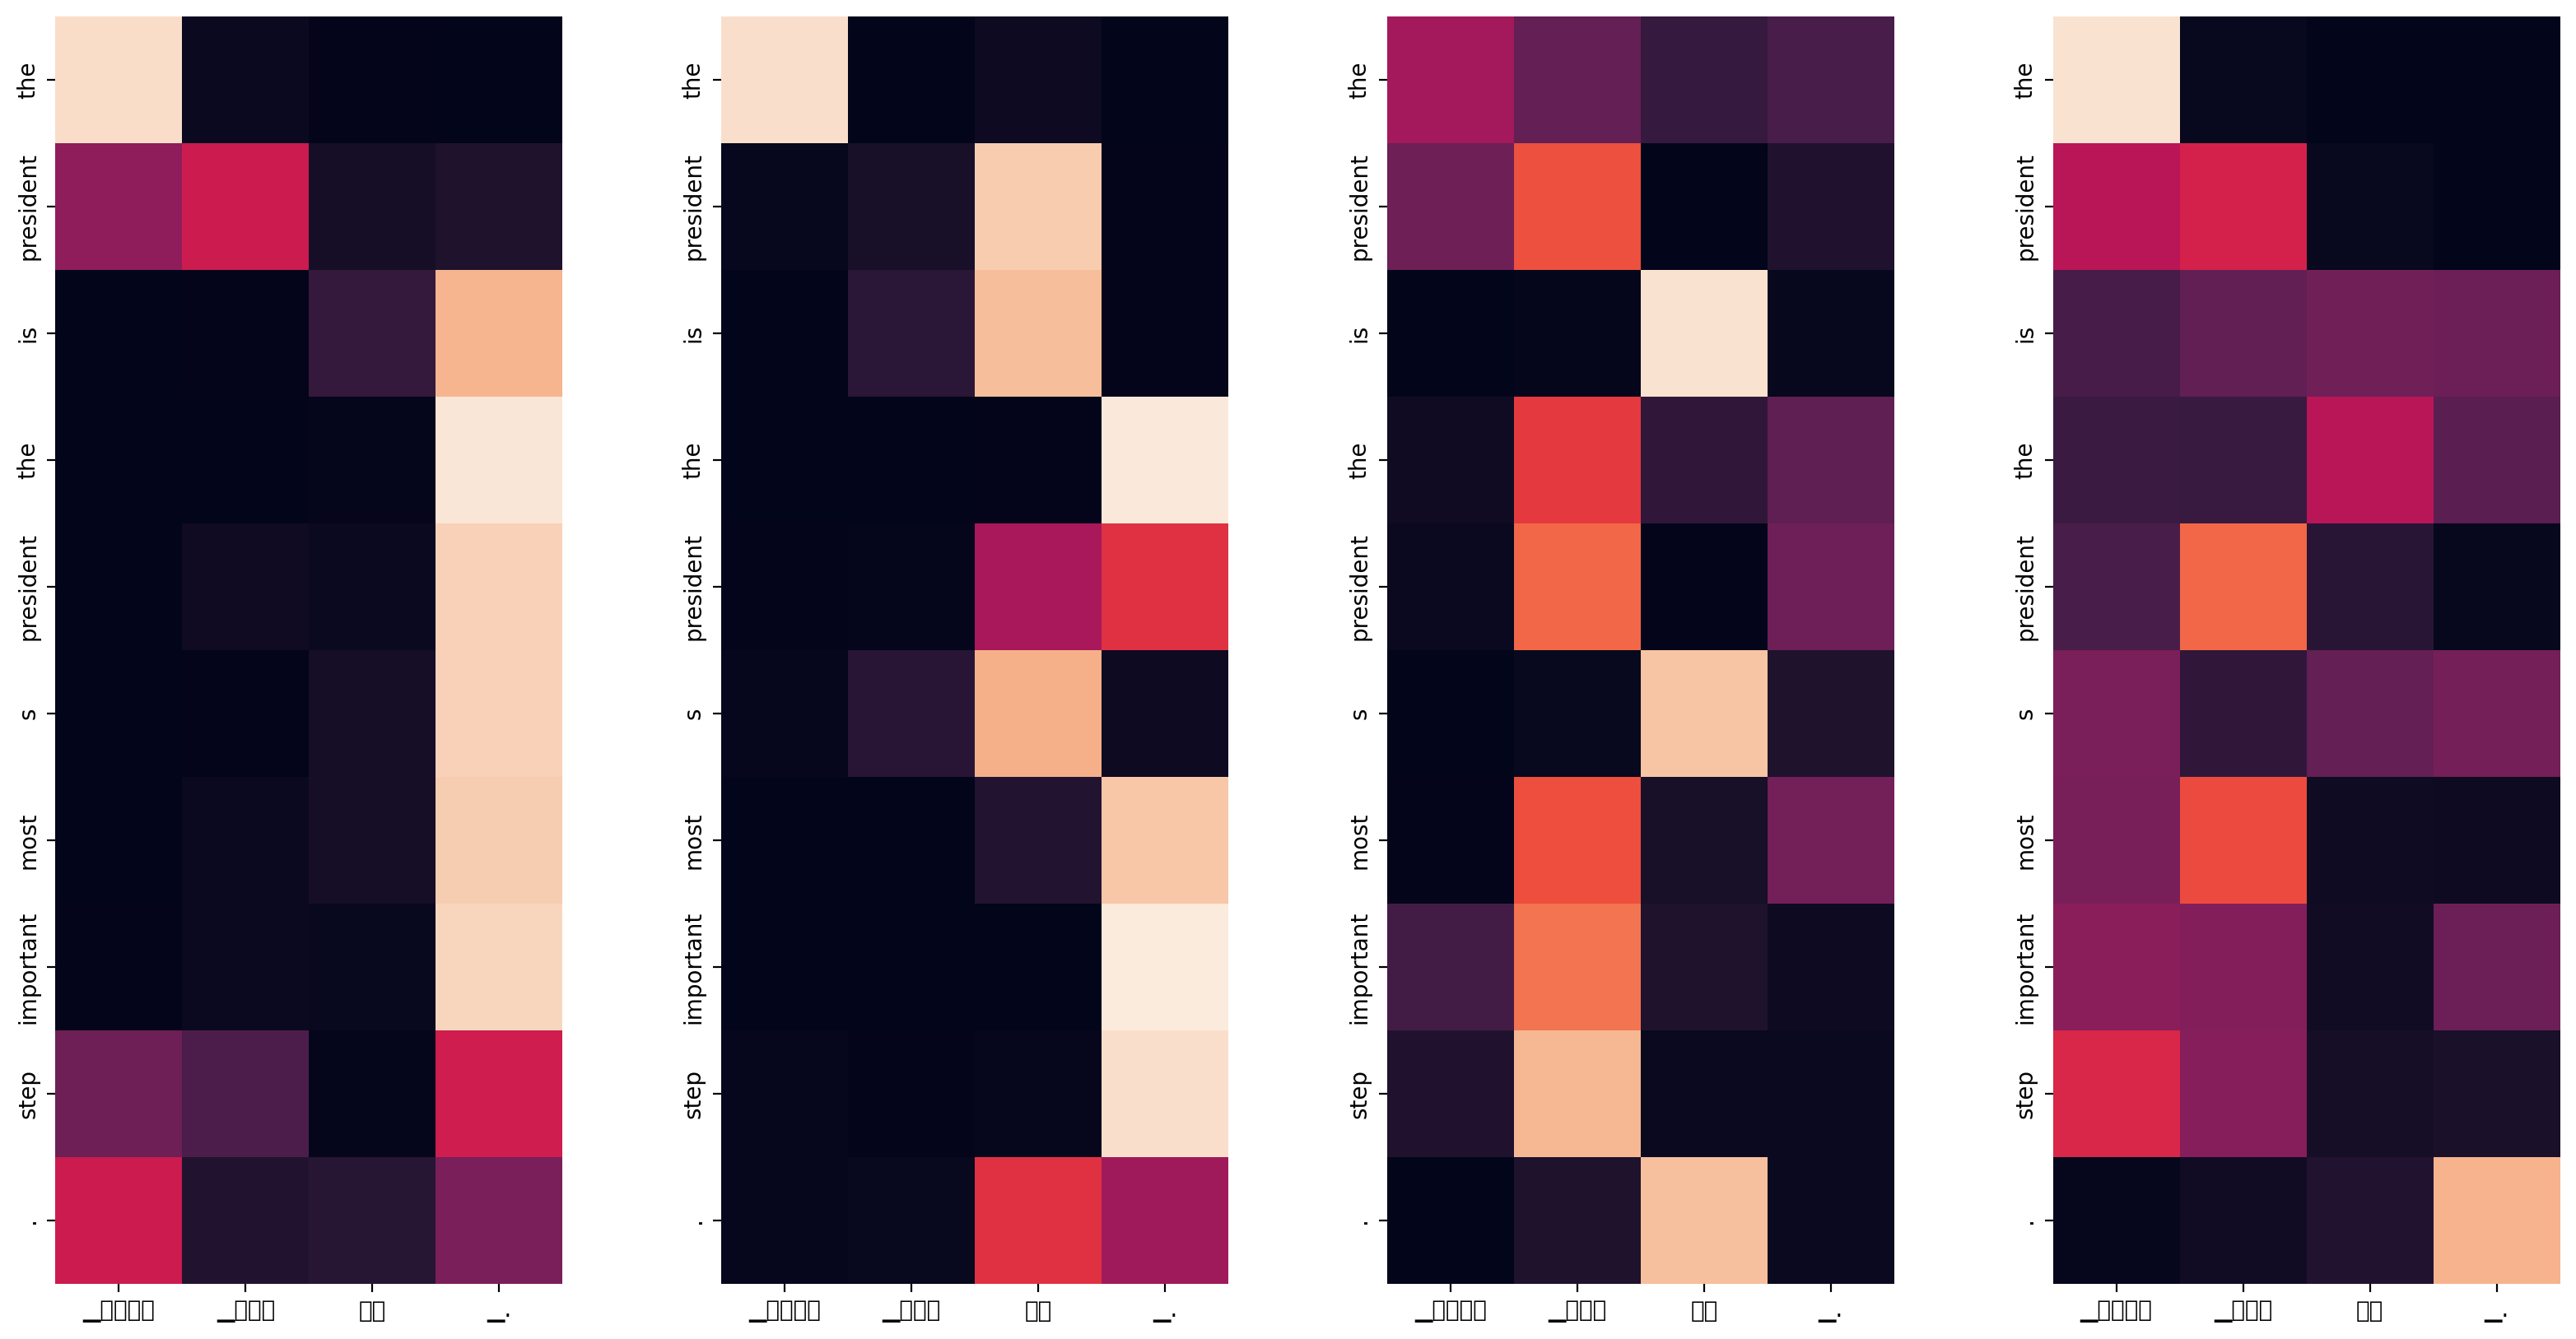

evaluate _input shape: [1 50]
Initial output shape: [1 1]
Predictions shape: [1 1 20000]
Updated output shape: [1 2]
Predictions shape: [1 2 20000]
Updated output shape: [1 3]
Predictions shape: [1 3 20000]
Updated output shape: [1 4]
Predictions shape: [1 4 20000]
Updated output shape: [1 5]
Predictions shape: [1 5 20000]
Updated output shape: [1 6]
Predictions shape: [1 6 20000]
Updated output shape: [1 7]
Predictions shape: [1 7 20000]
Updated output shape: [1 8]
Predictions shape: [1 8 20000]
Updated output shape: [1 9]
Predictions shape: [1 9 20000]
Updated output shape: [1 10]
Predictions shape: [1 10 20000]
Input: 시민들은 도시 속에 산다.
Predicted translation: the streets of cities , cities , cities .


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning:

Encoder Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

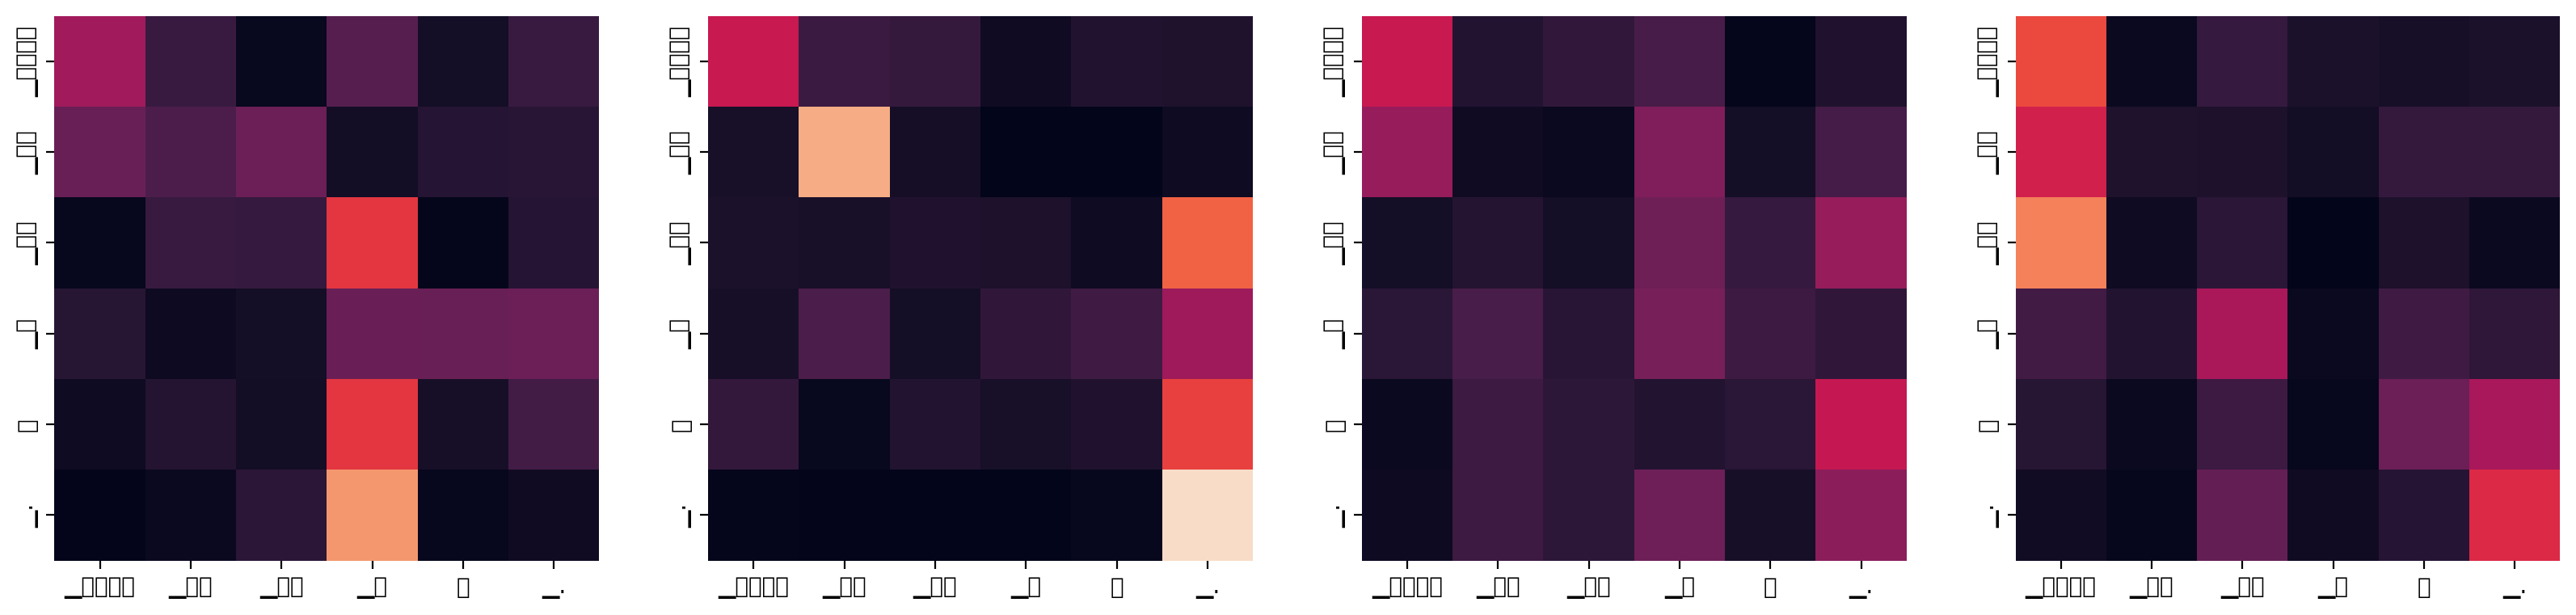

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning:

Encoder Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

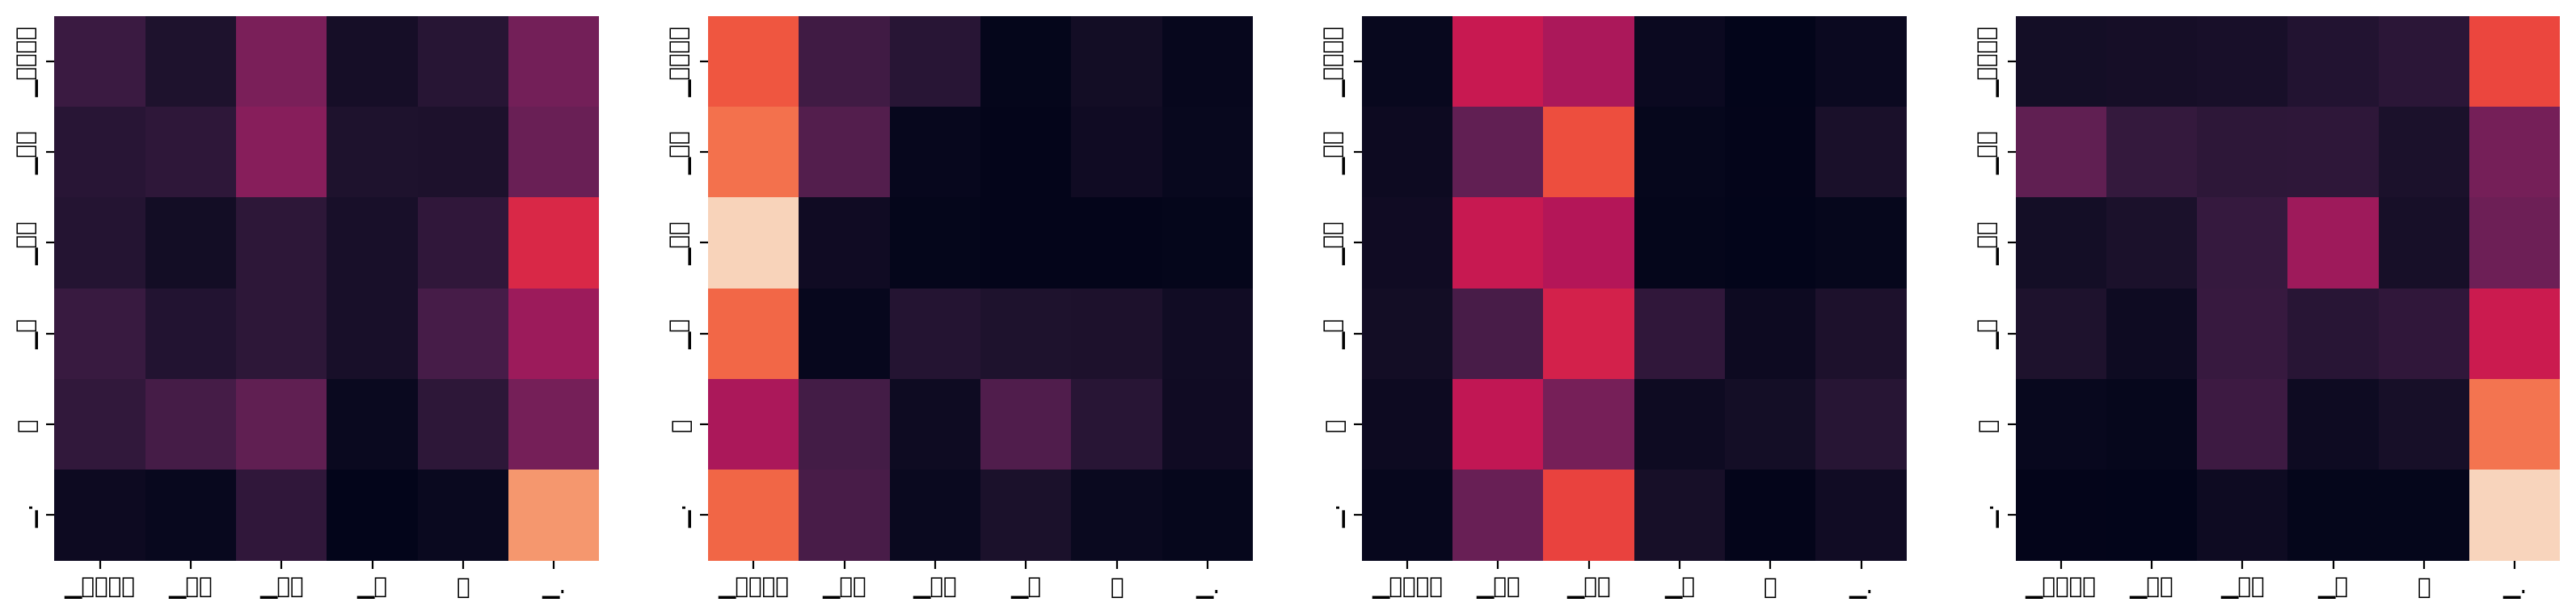

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

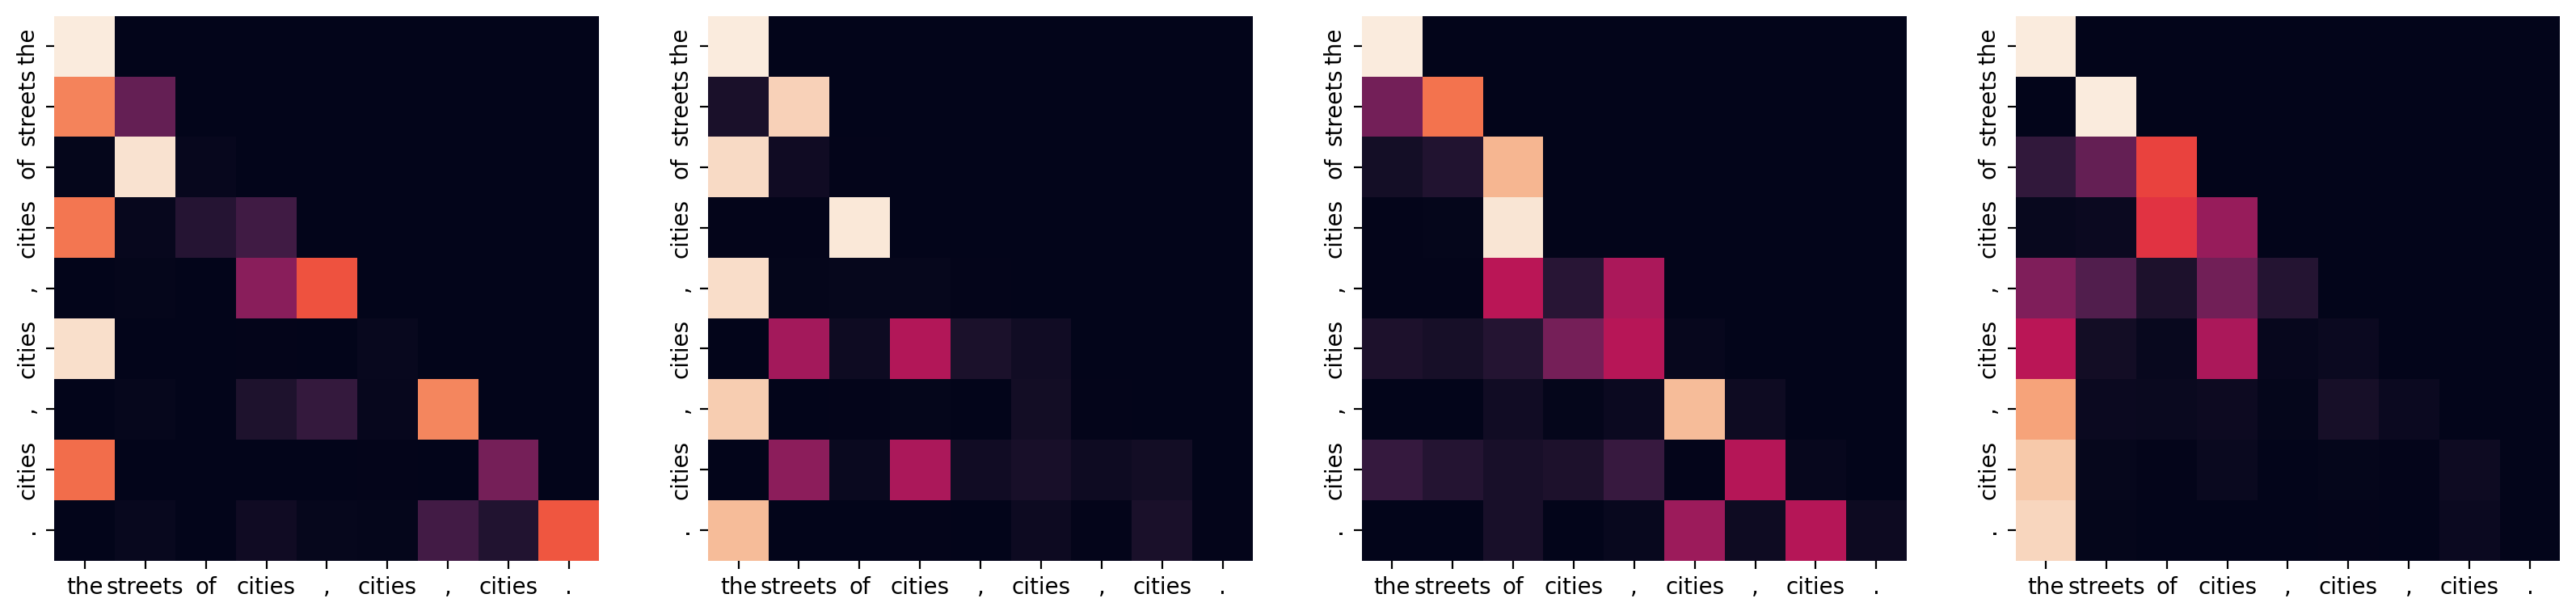

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning:

Decoder Src Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

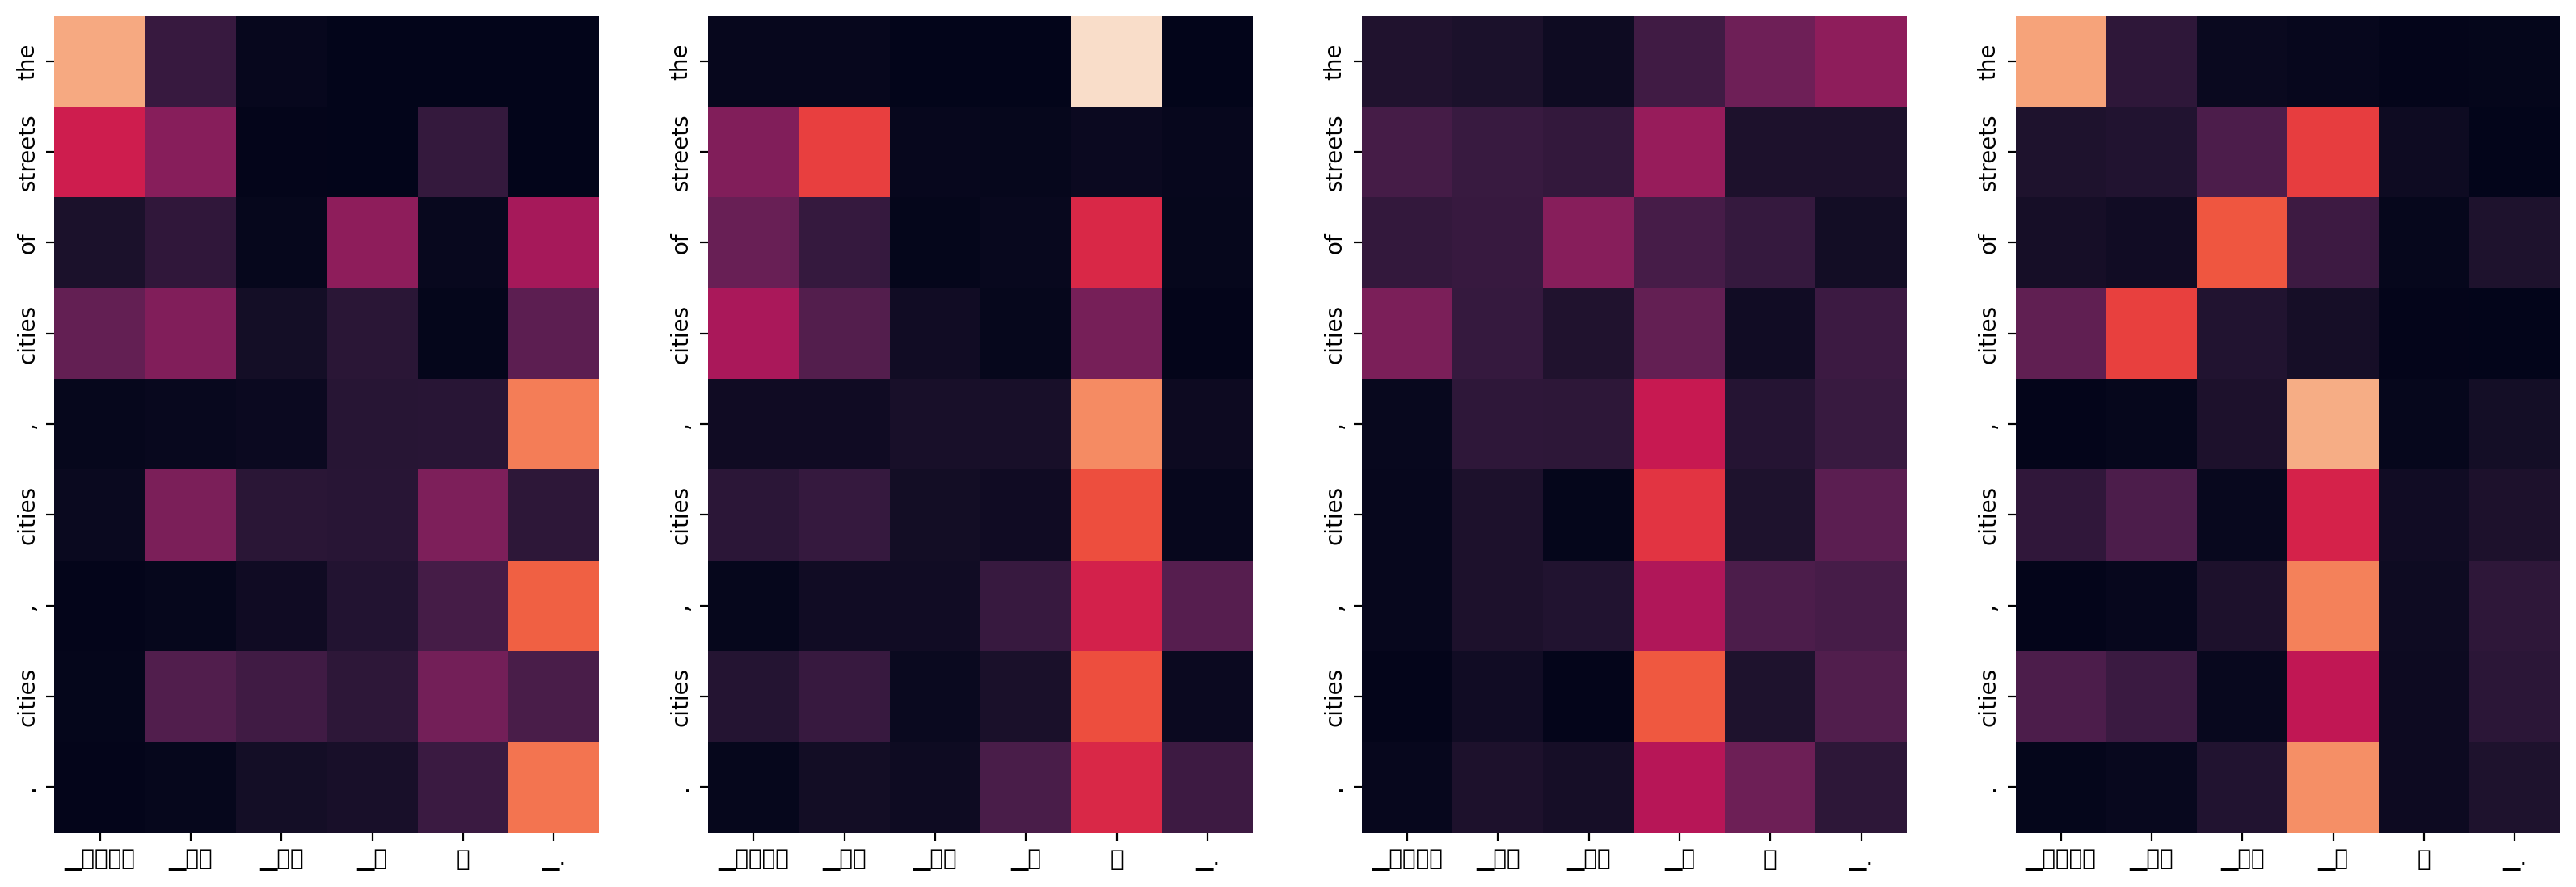

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

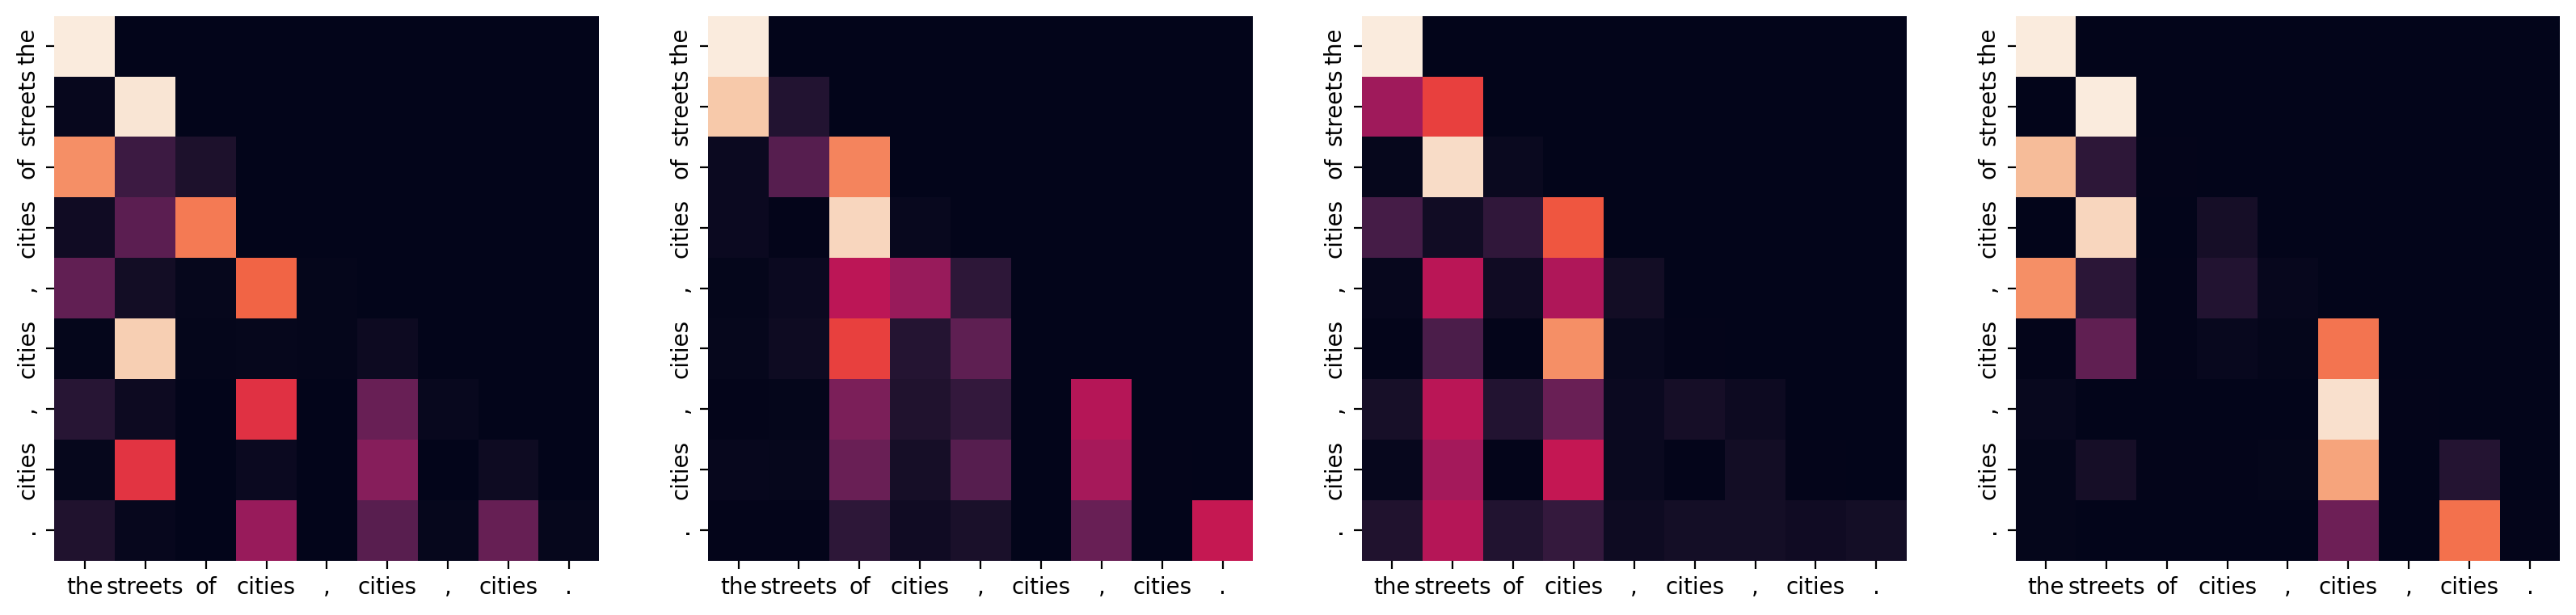

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning:

Decoder Src Layer 2


/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.draw()
findfont: Font fami

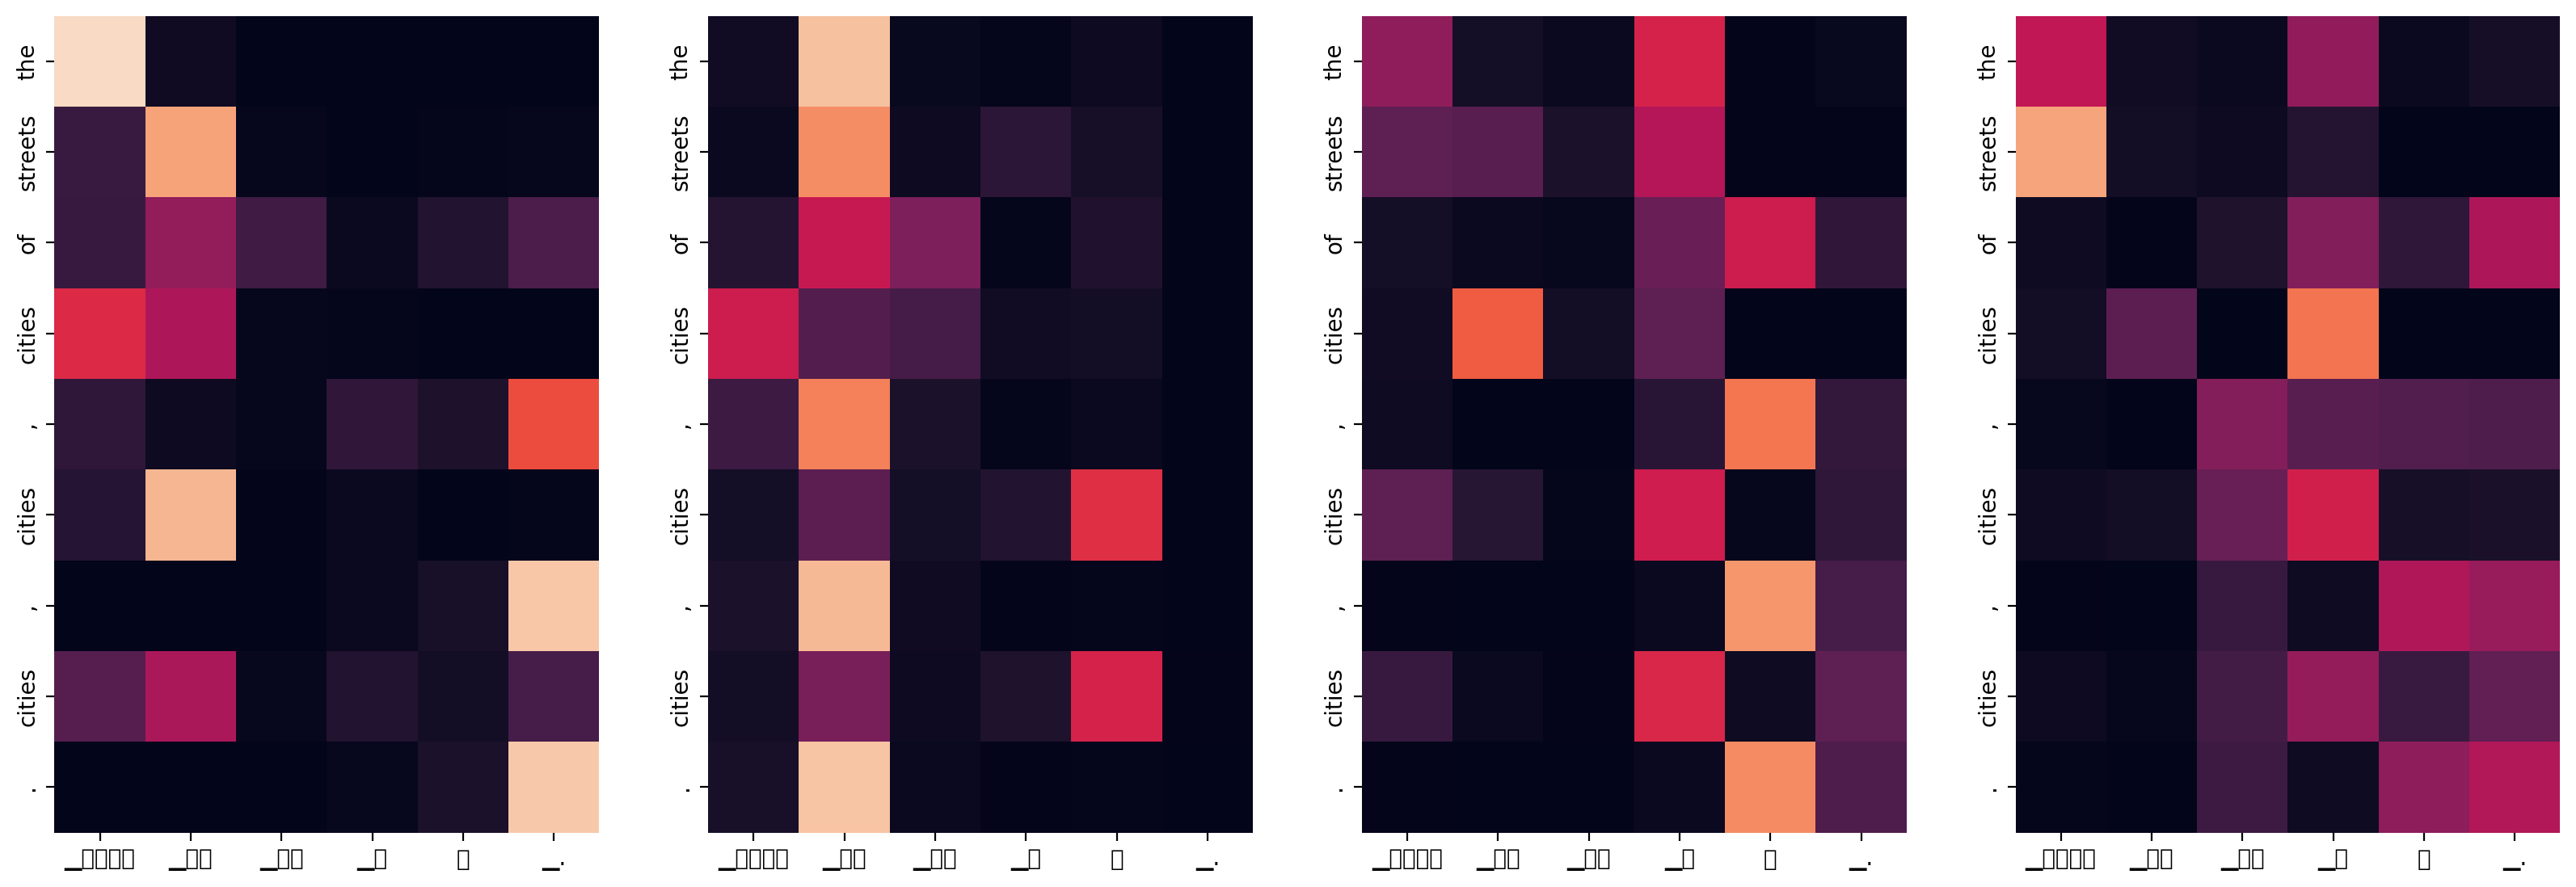

evaluate _input shape: [1 50]
Initial output shape: [1 1]
Predictions shape: [1 1 20000]
Updated output shape: [1 2]
Predictions shape: [1 2 20000]
Updated output shape: [1 3]
Predictions shape: [1 3 20000]
Updated output shape: [1 4]
Predictions shape: [1 4 20000]
Updated output shape: [1 5]
Predictions shape: [1 5 20000]
Updated output shape: [1 6]
Predictions shape: [1 6 20000]
Updated output shape: [1 7]
Predictions shape: [1 7 20000]
Input: 커피는 필요 없다.
Predicted translation: it is not a thing .


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/pytho

Encoder Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

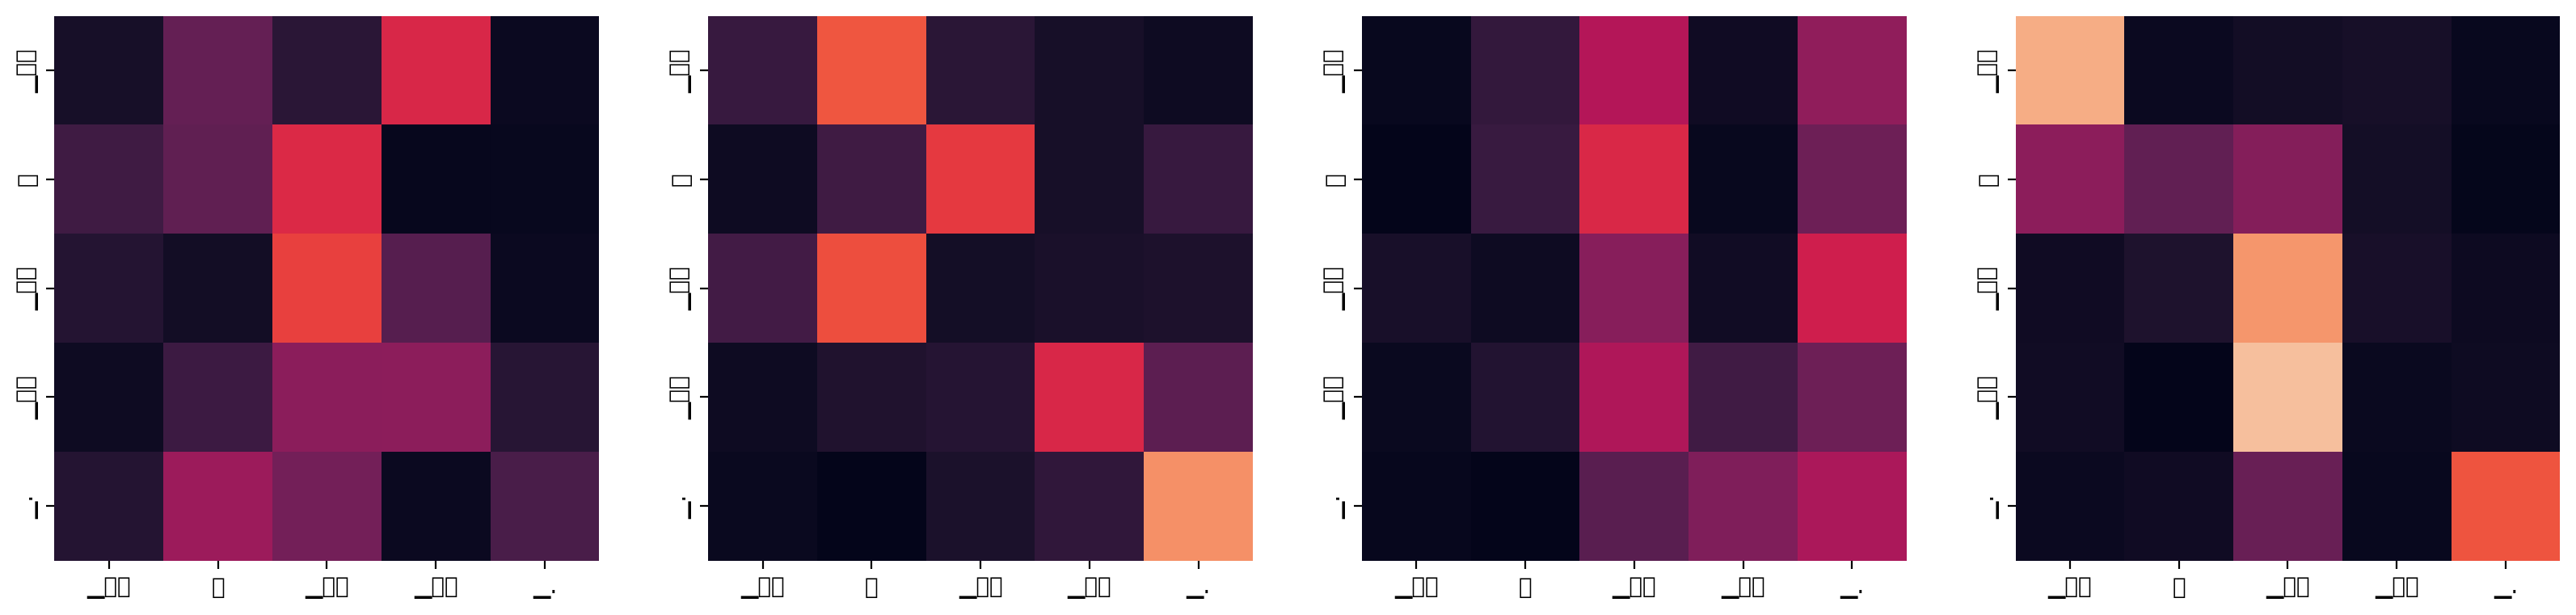

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/pytho

Encoder Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

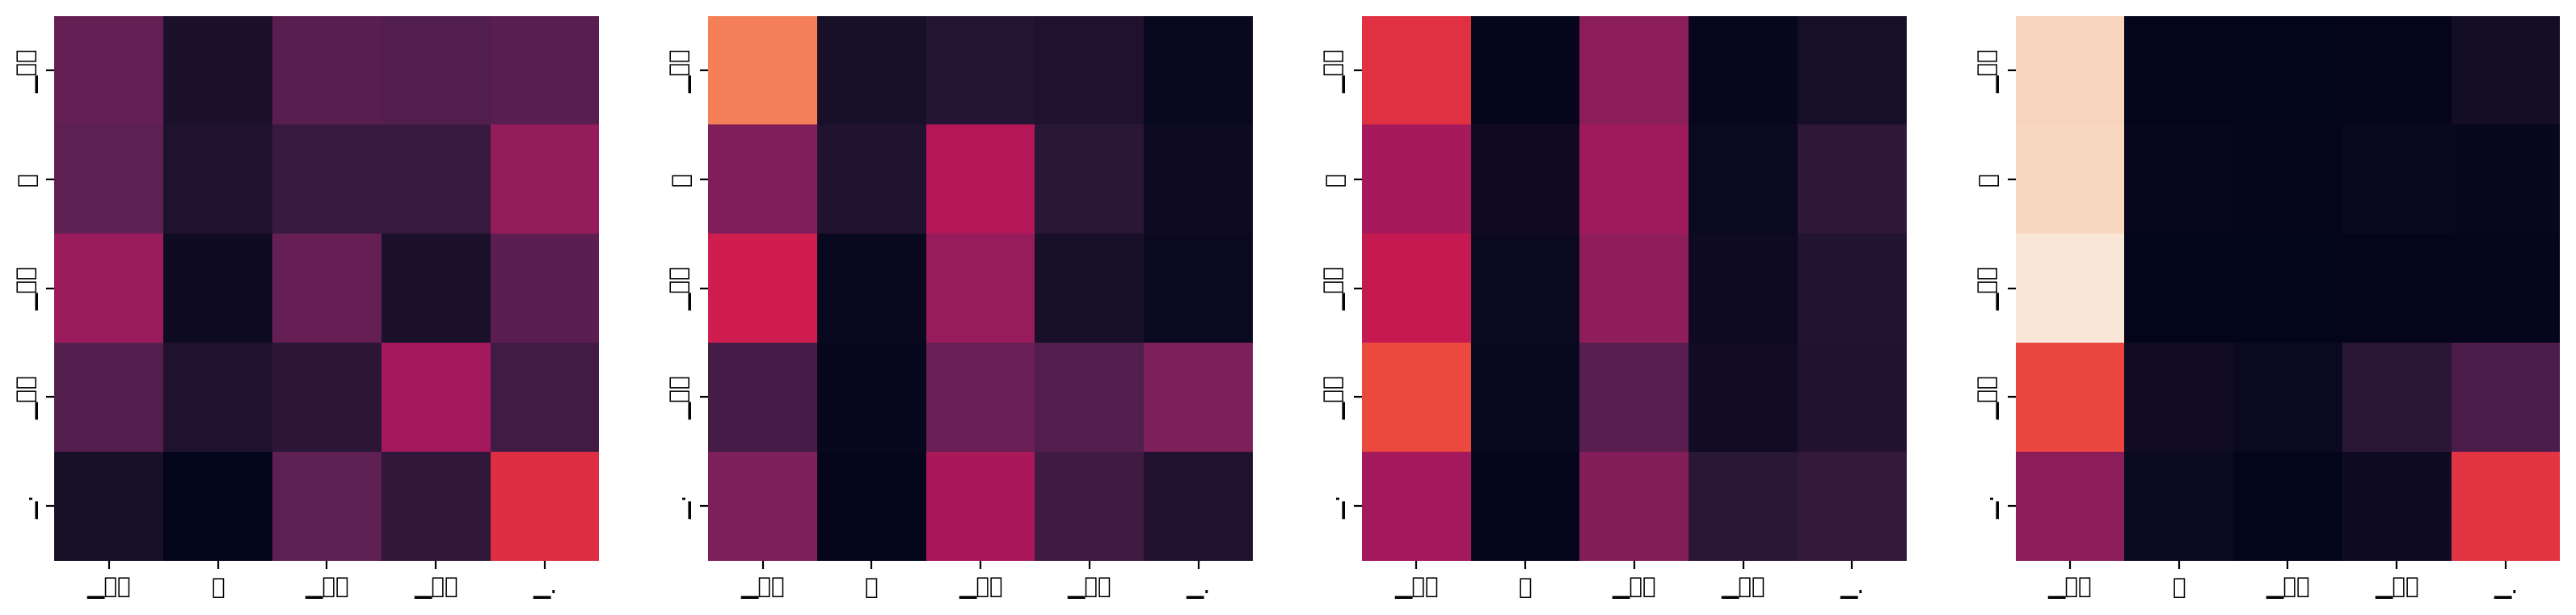

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

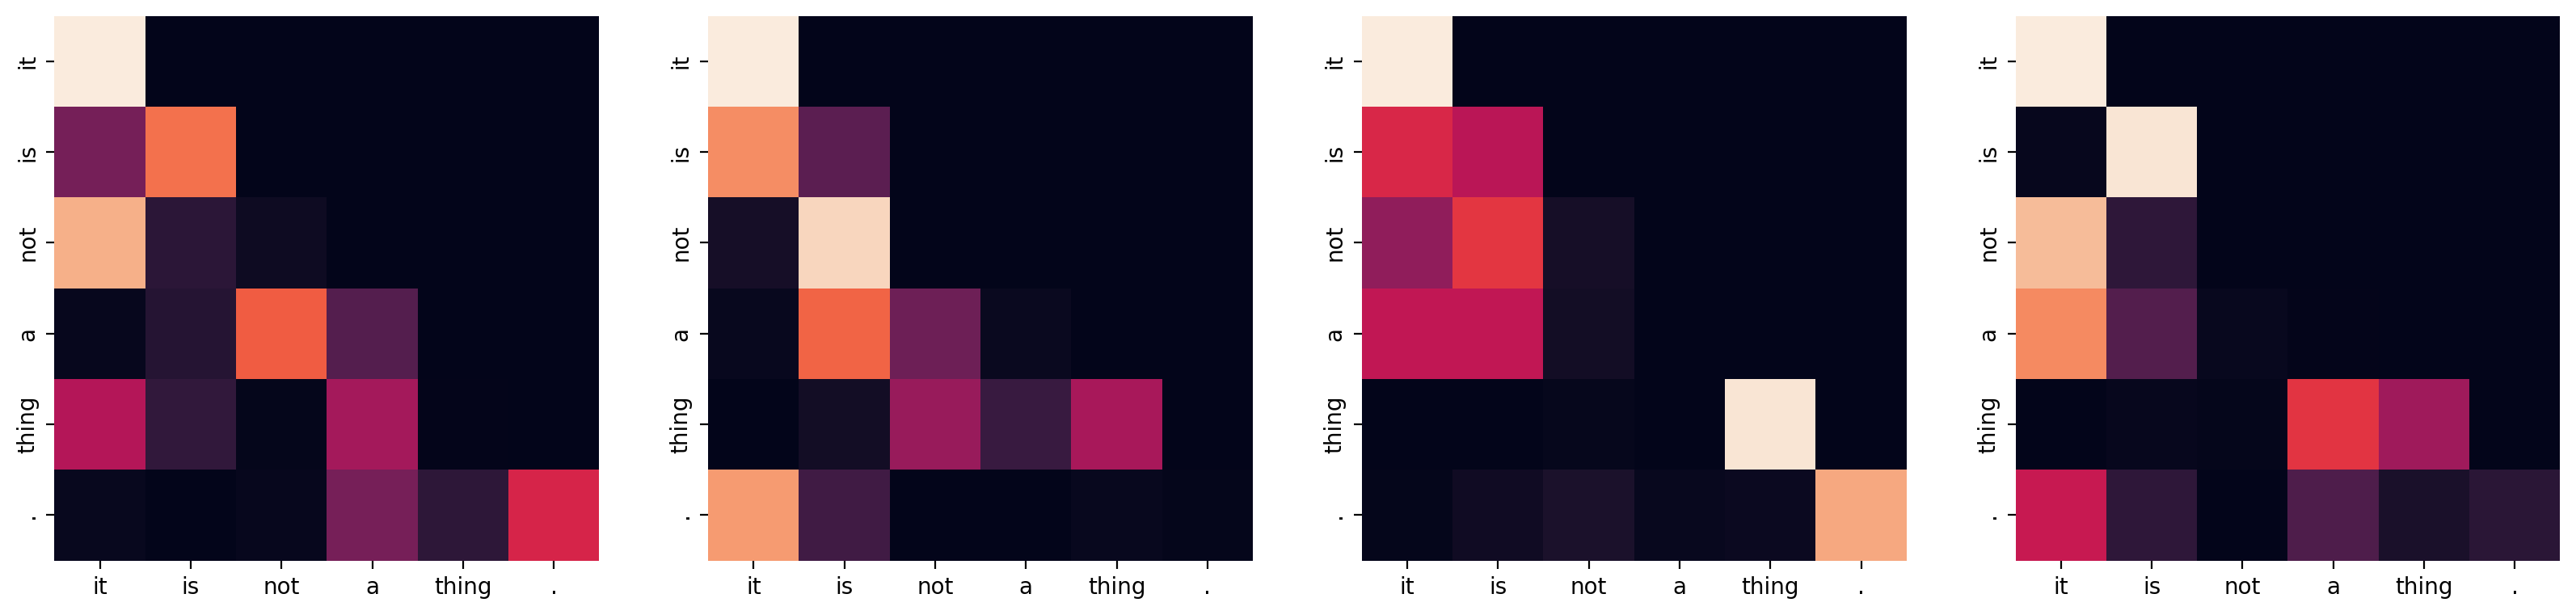

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/pytho

Decoder Src Layer 1


/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50630 (\N{HANGUL SYLLABLE EOBS}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not foun

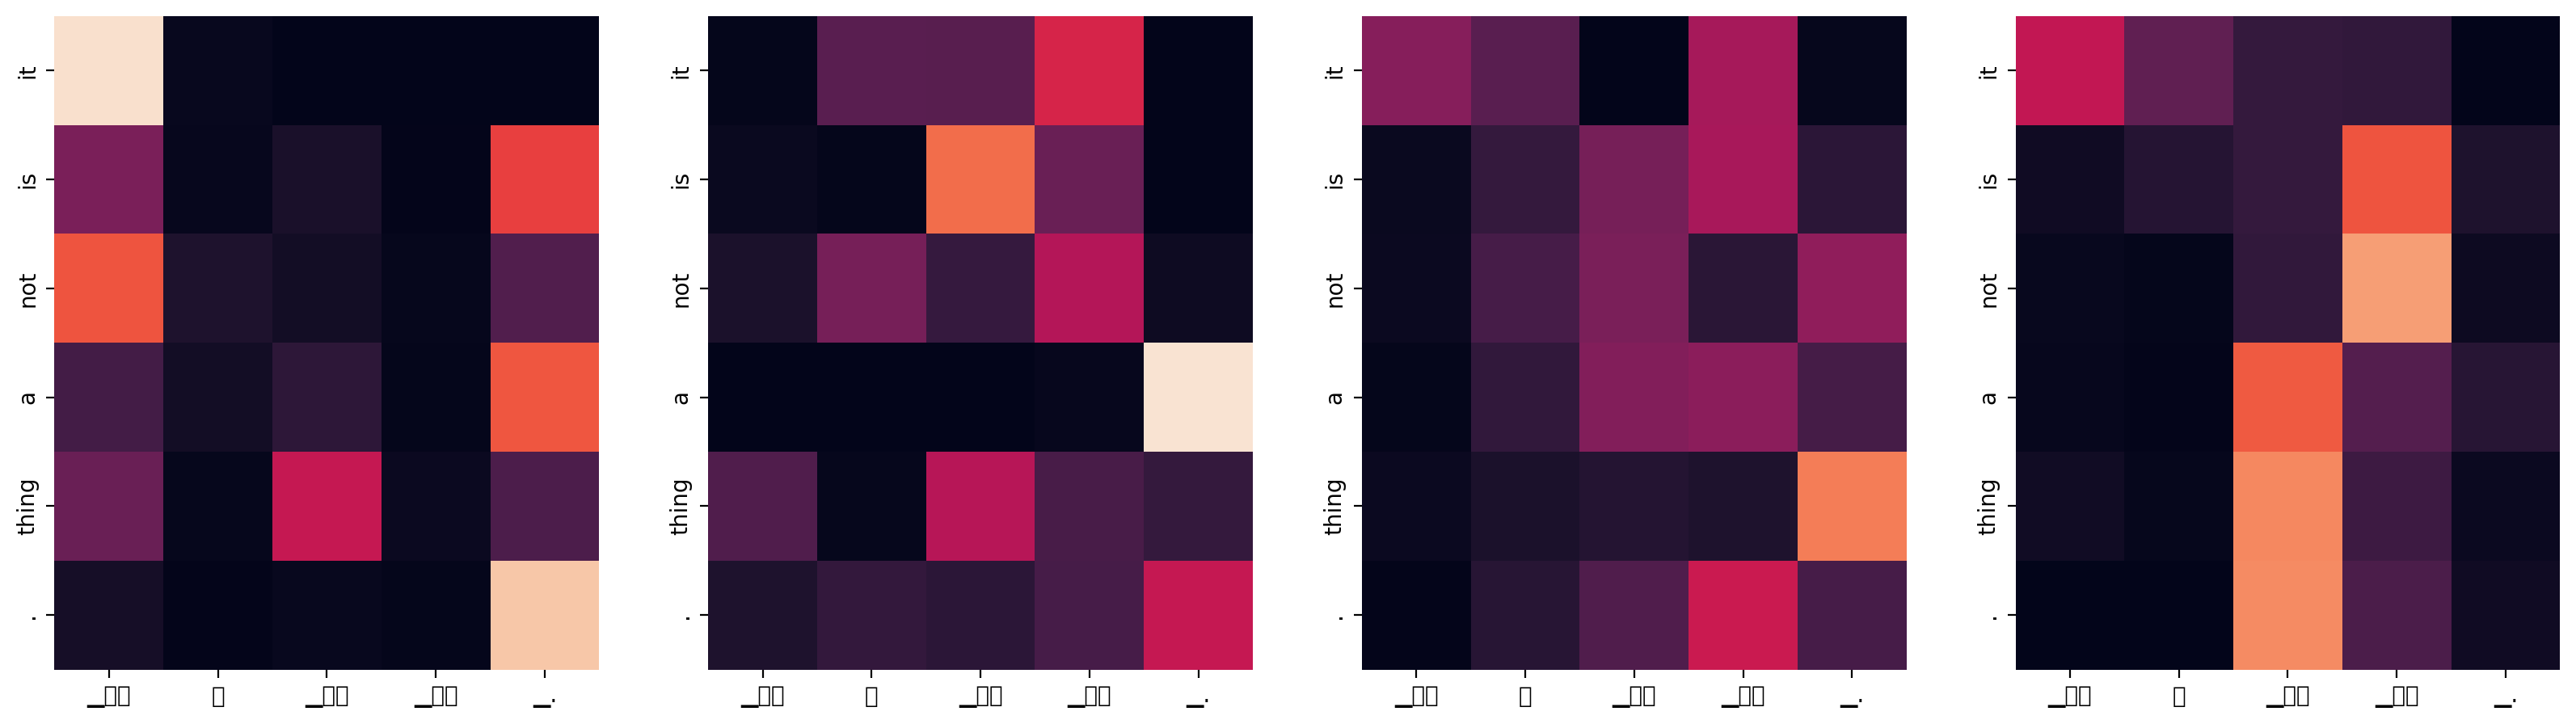

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

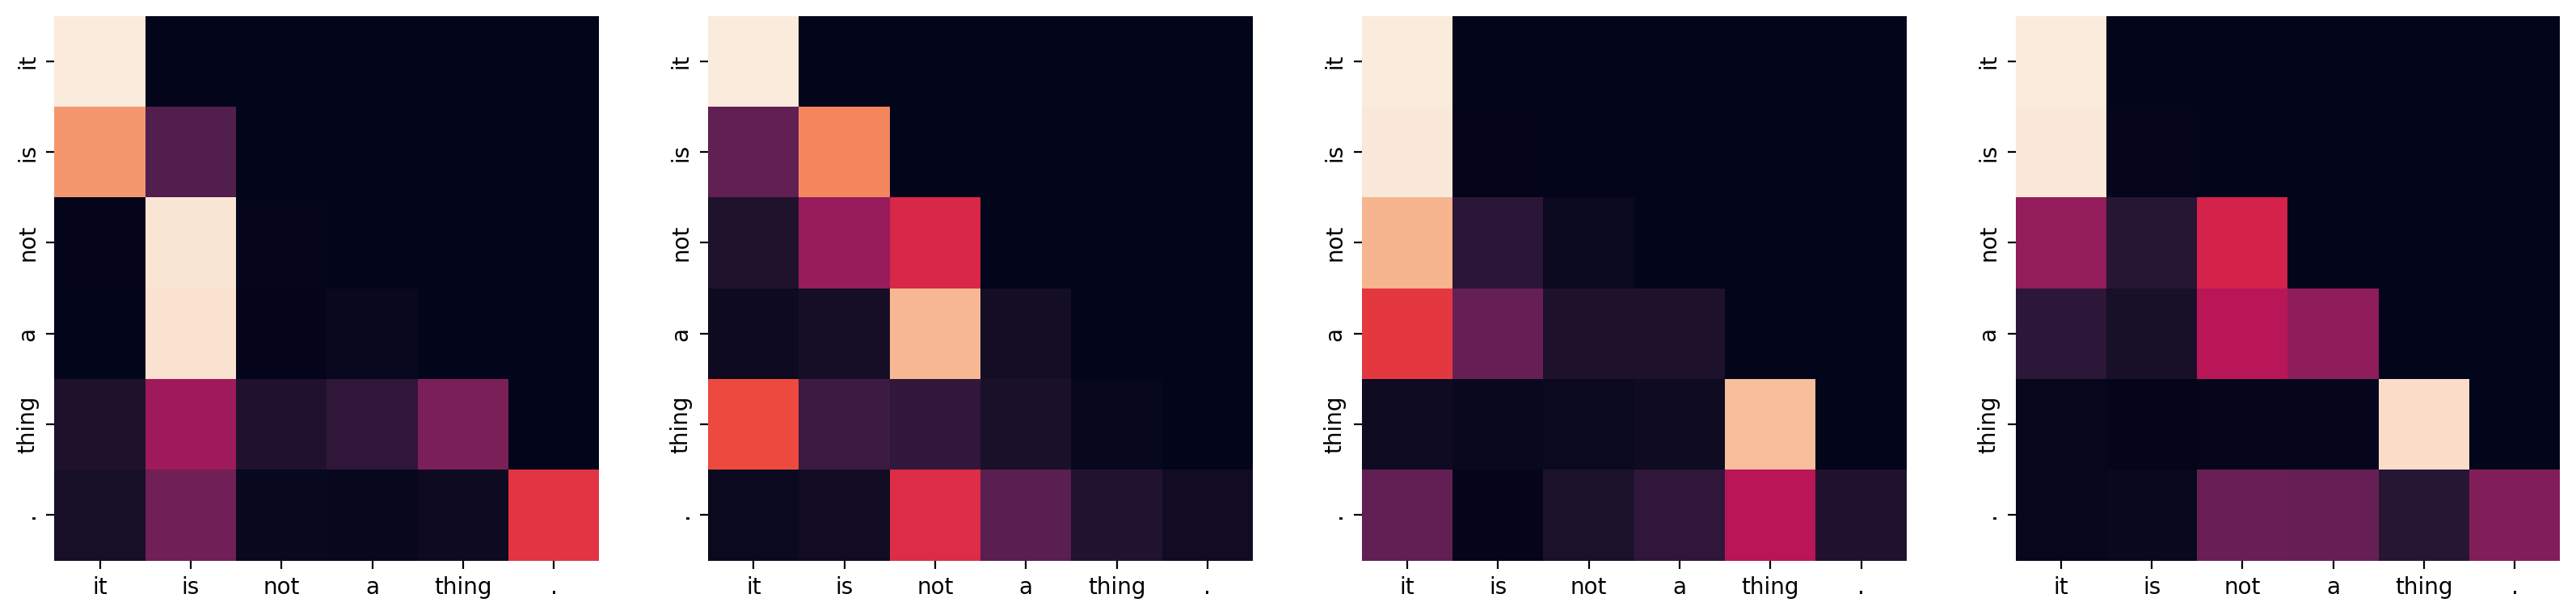

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/pytho

Decoder Src Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61

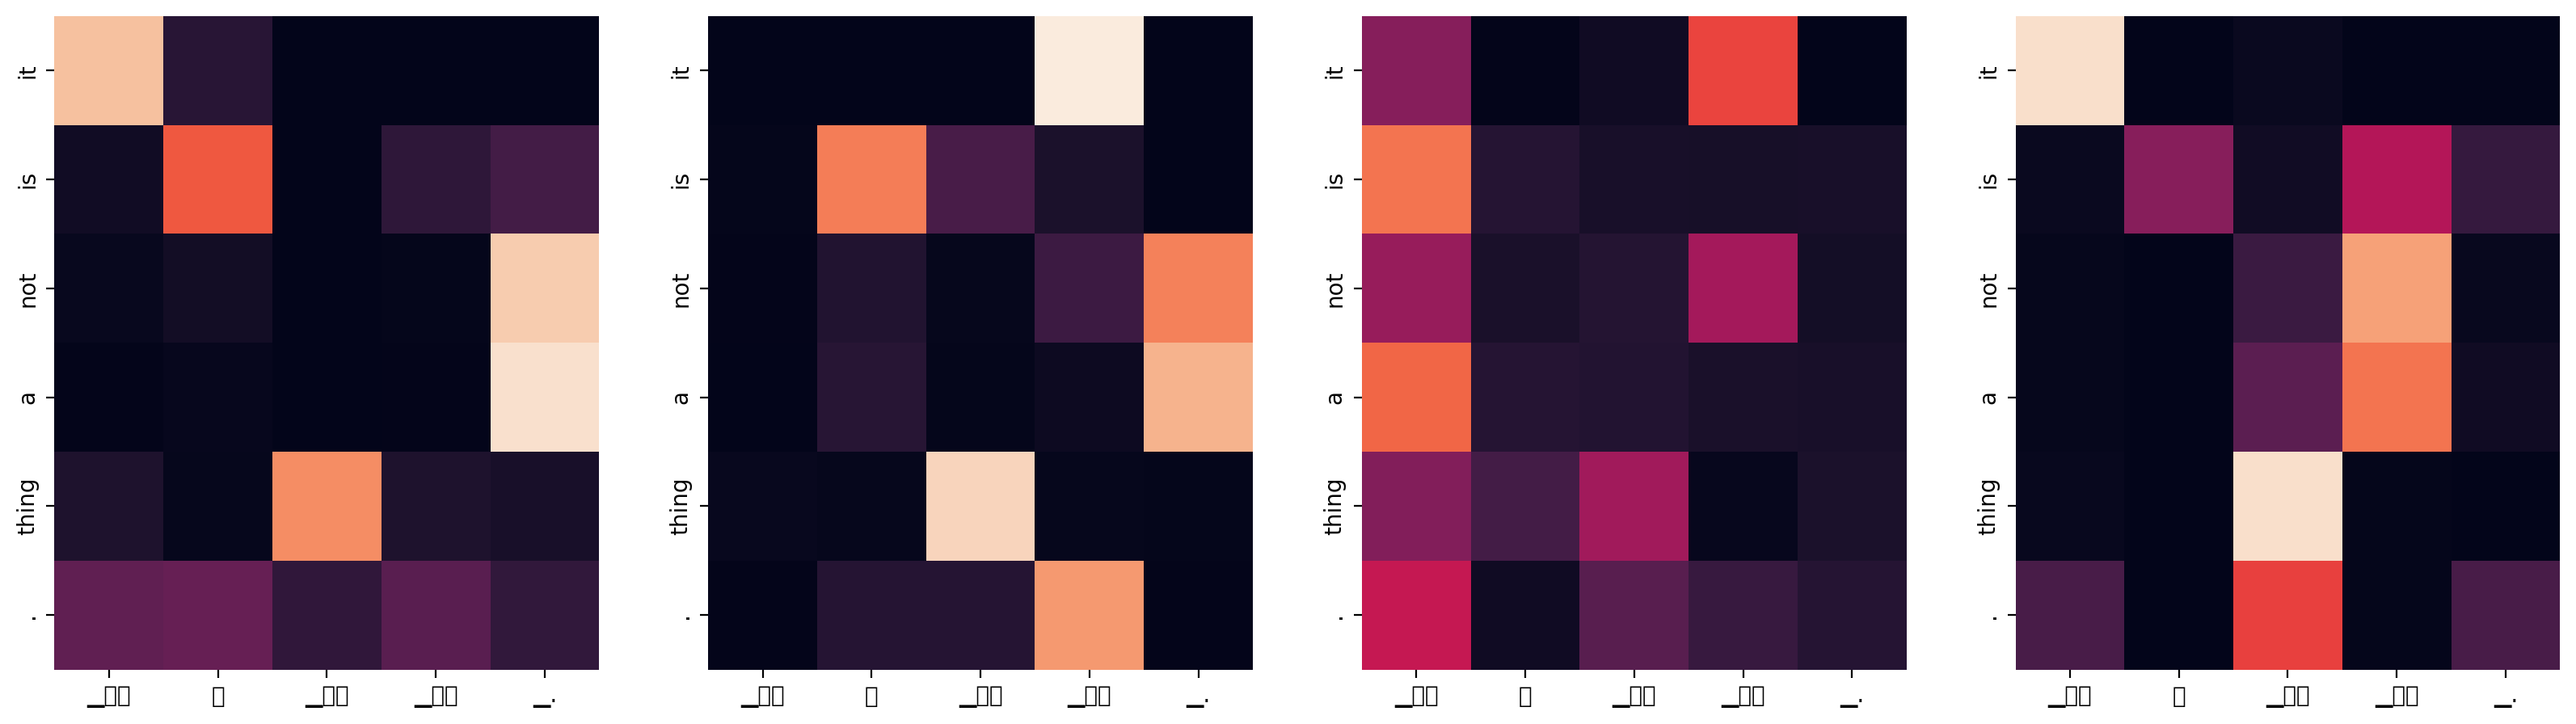

evaluate _input shape: [1 50]
Initial output shape: [1 1]
Predictions shape: [1 1 20000]
Updated output shape: [1 2]
Predictions shape: [1 2 20000]
Updated output shape: [1 3]
Predictions shape: [1 3 20000]
Updated output shape: [1 4]
Predictions shape: [1 4 20000]
Updated output shape: [1 5]
Predictions shape: [1 5 20000]
Updated output shape: [1 6]
Predictions shape: [1 6 20000]
Updated output shape: [1 7]
Predictions shape: [1 7 20000]
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven candidates were killed .
Encoder Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44273 (\N{HANGUL SYLLABLE GOB}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/pyth

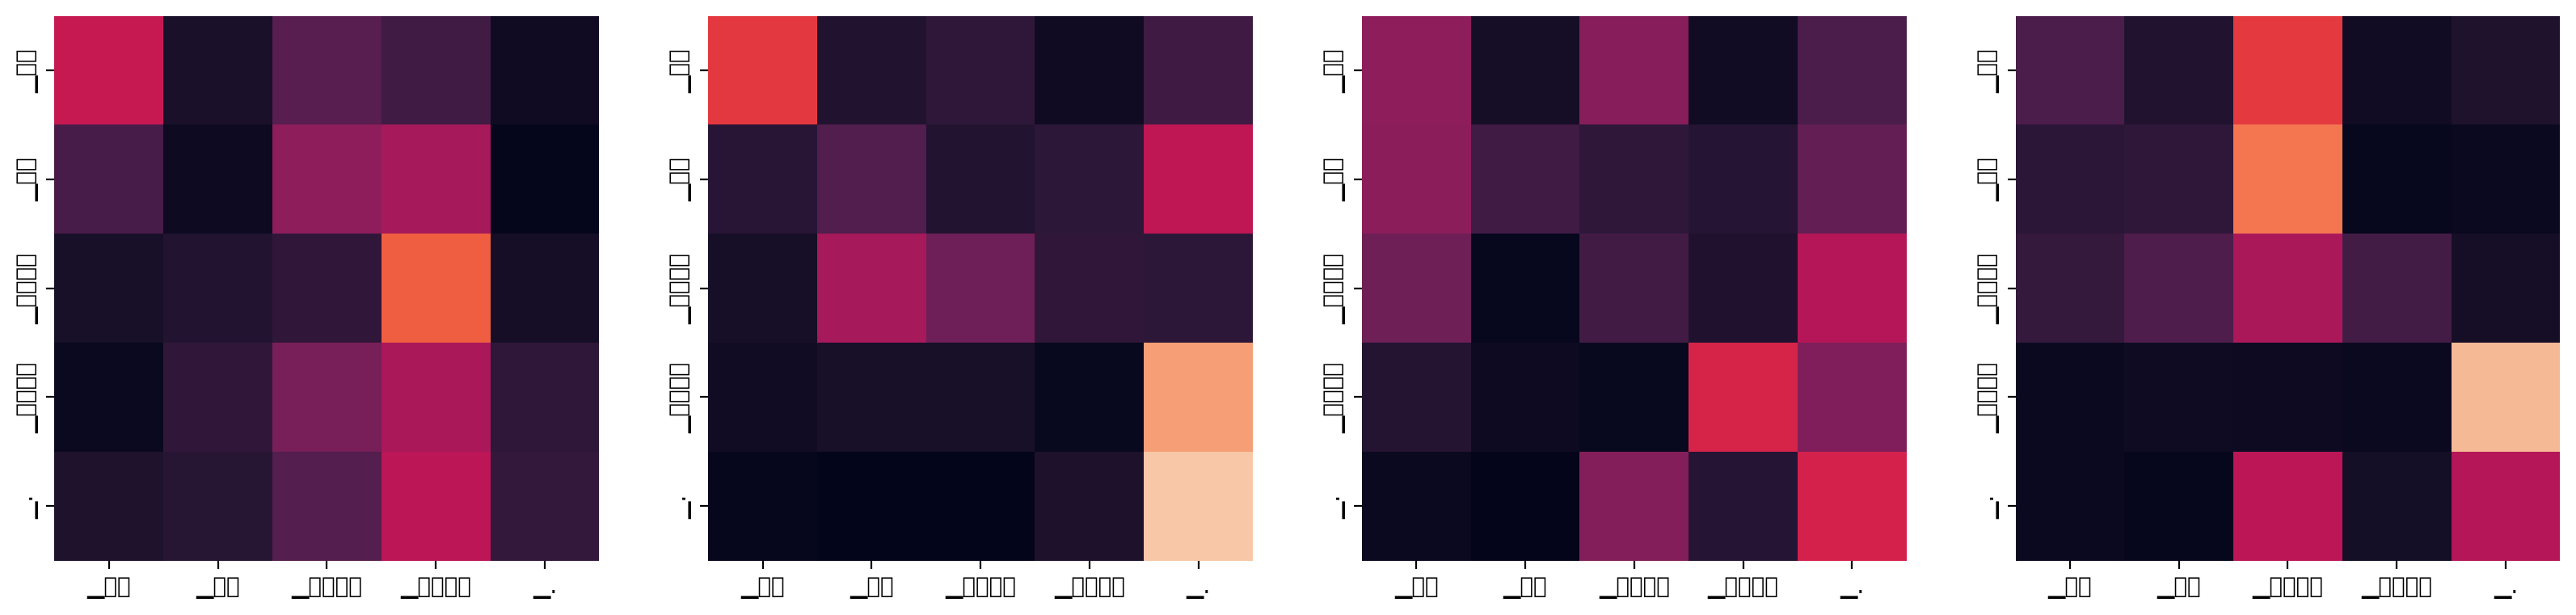

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44273 (\N{HANGUL SYLLABLE GOB}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/pyth

Encoder Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

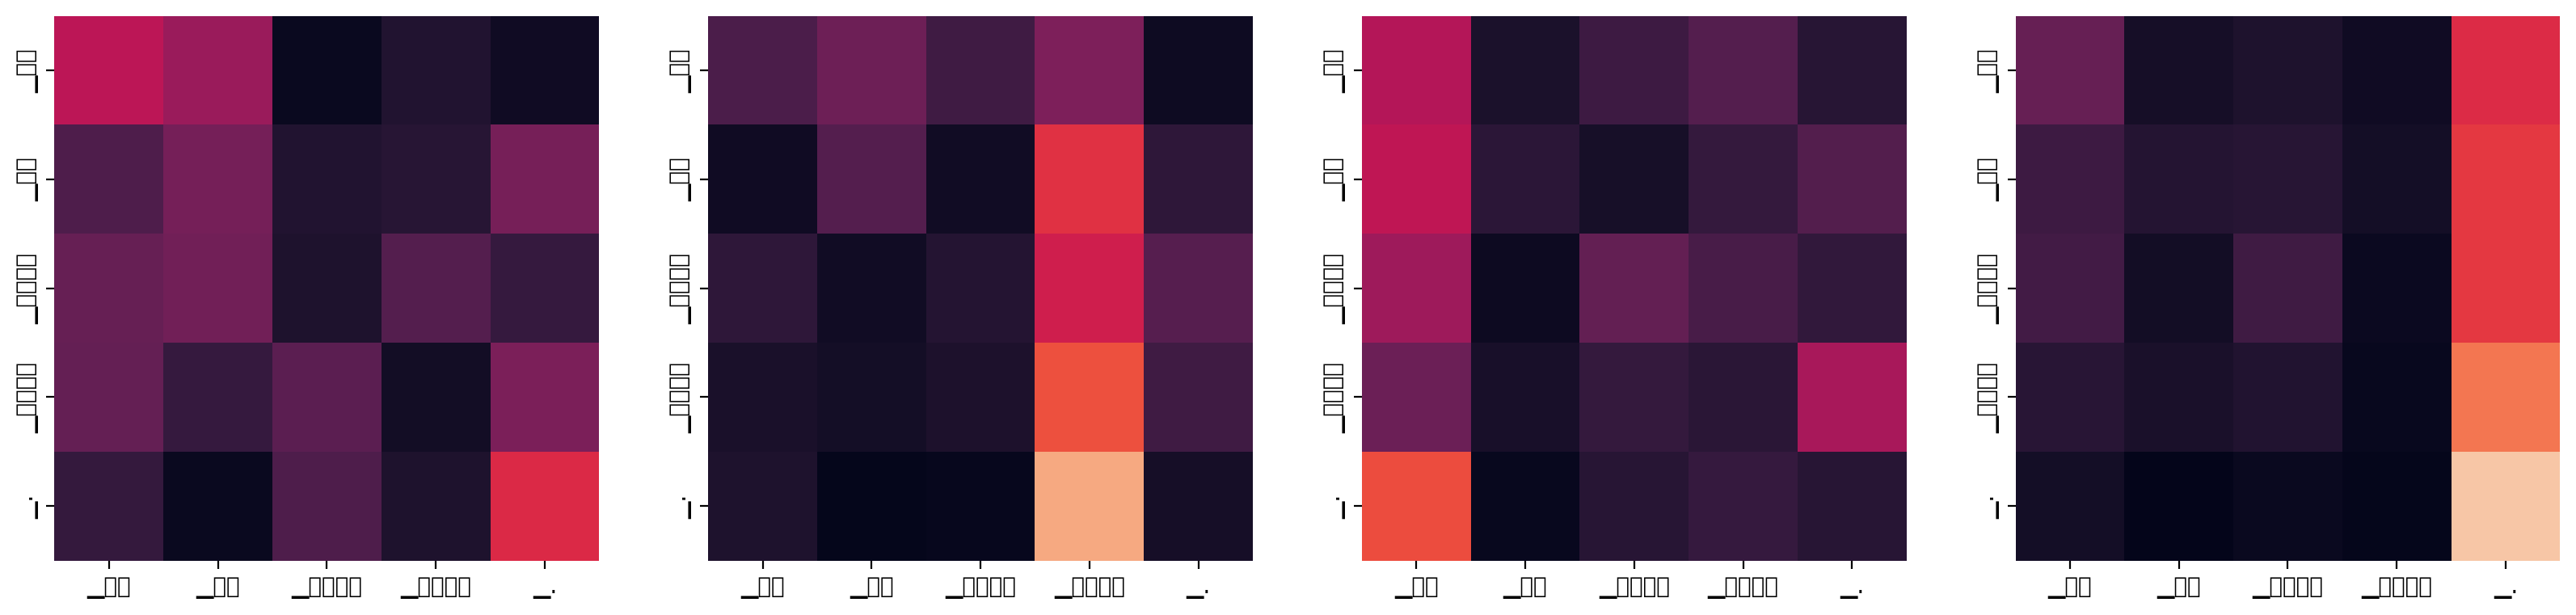

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

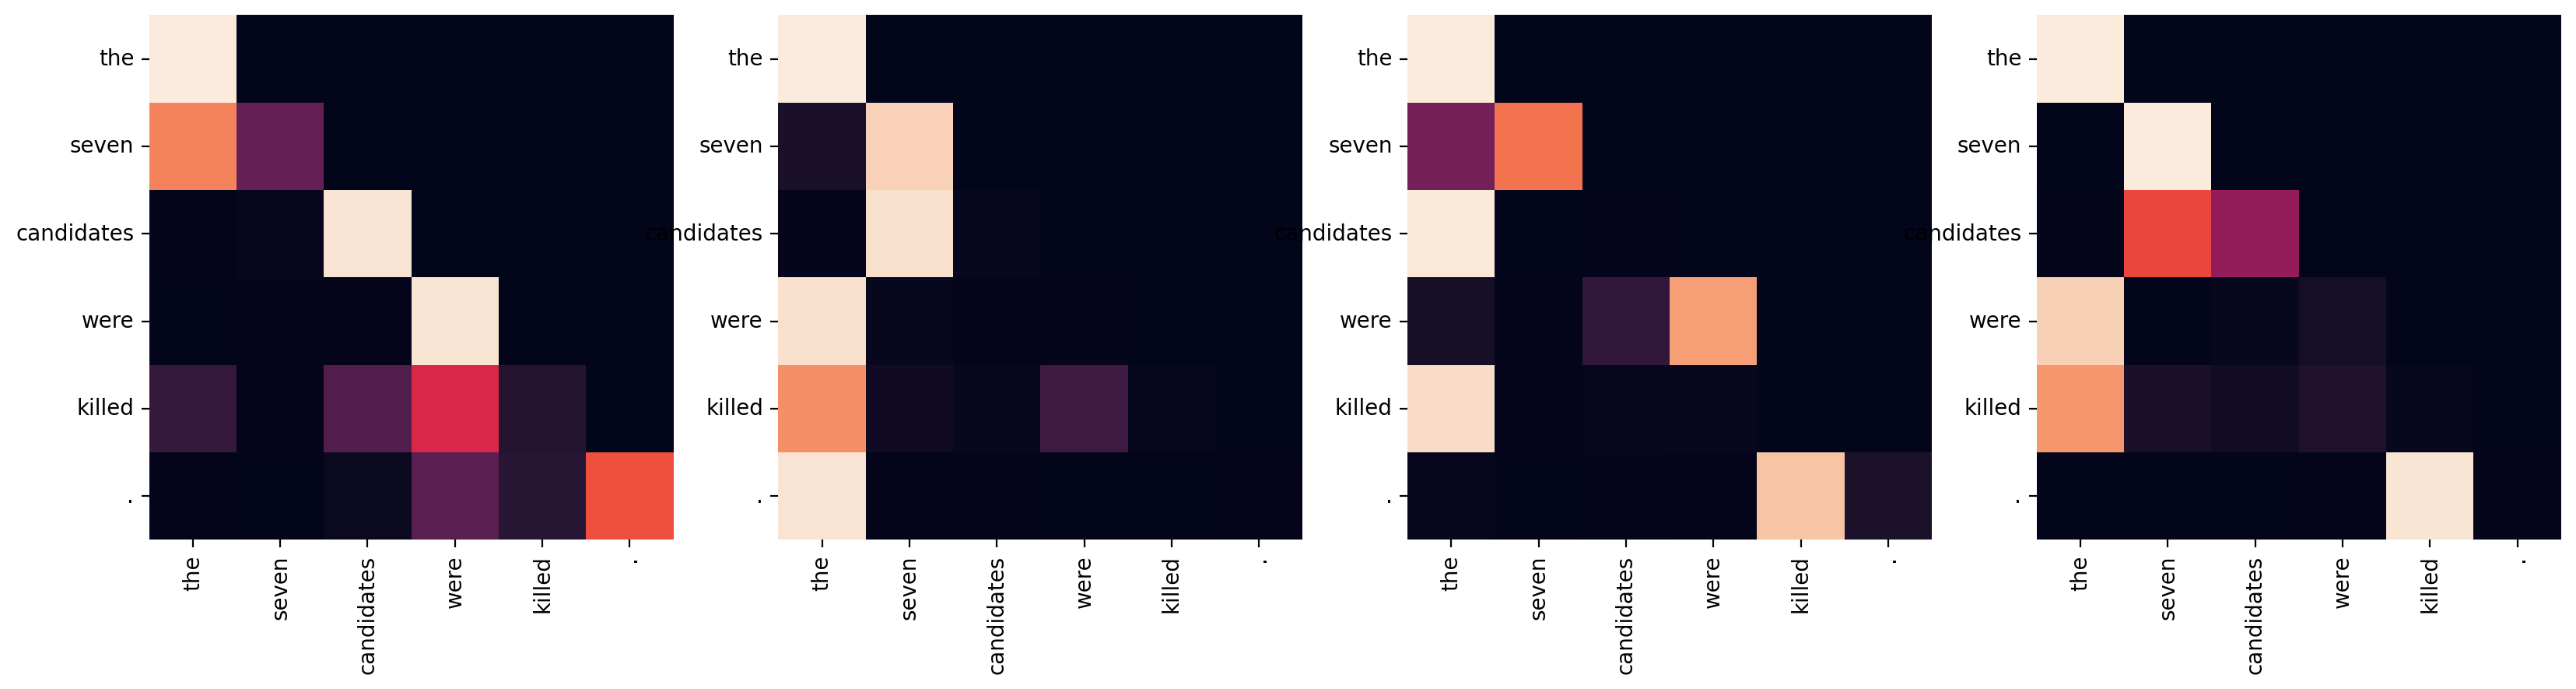

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44273 (\N{HANGUL SYLLABLE GOB}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/pyth

Decoder Src Layer 1


/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44273 (\N{HANGUL SYLLABLE GOB}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from 

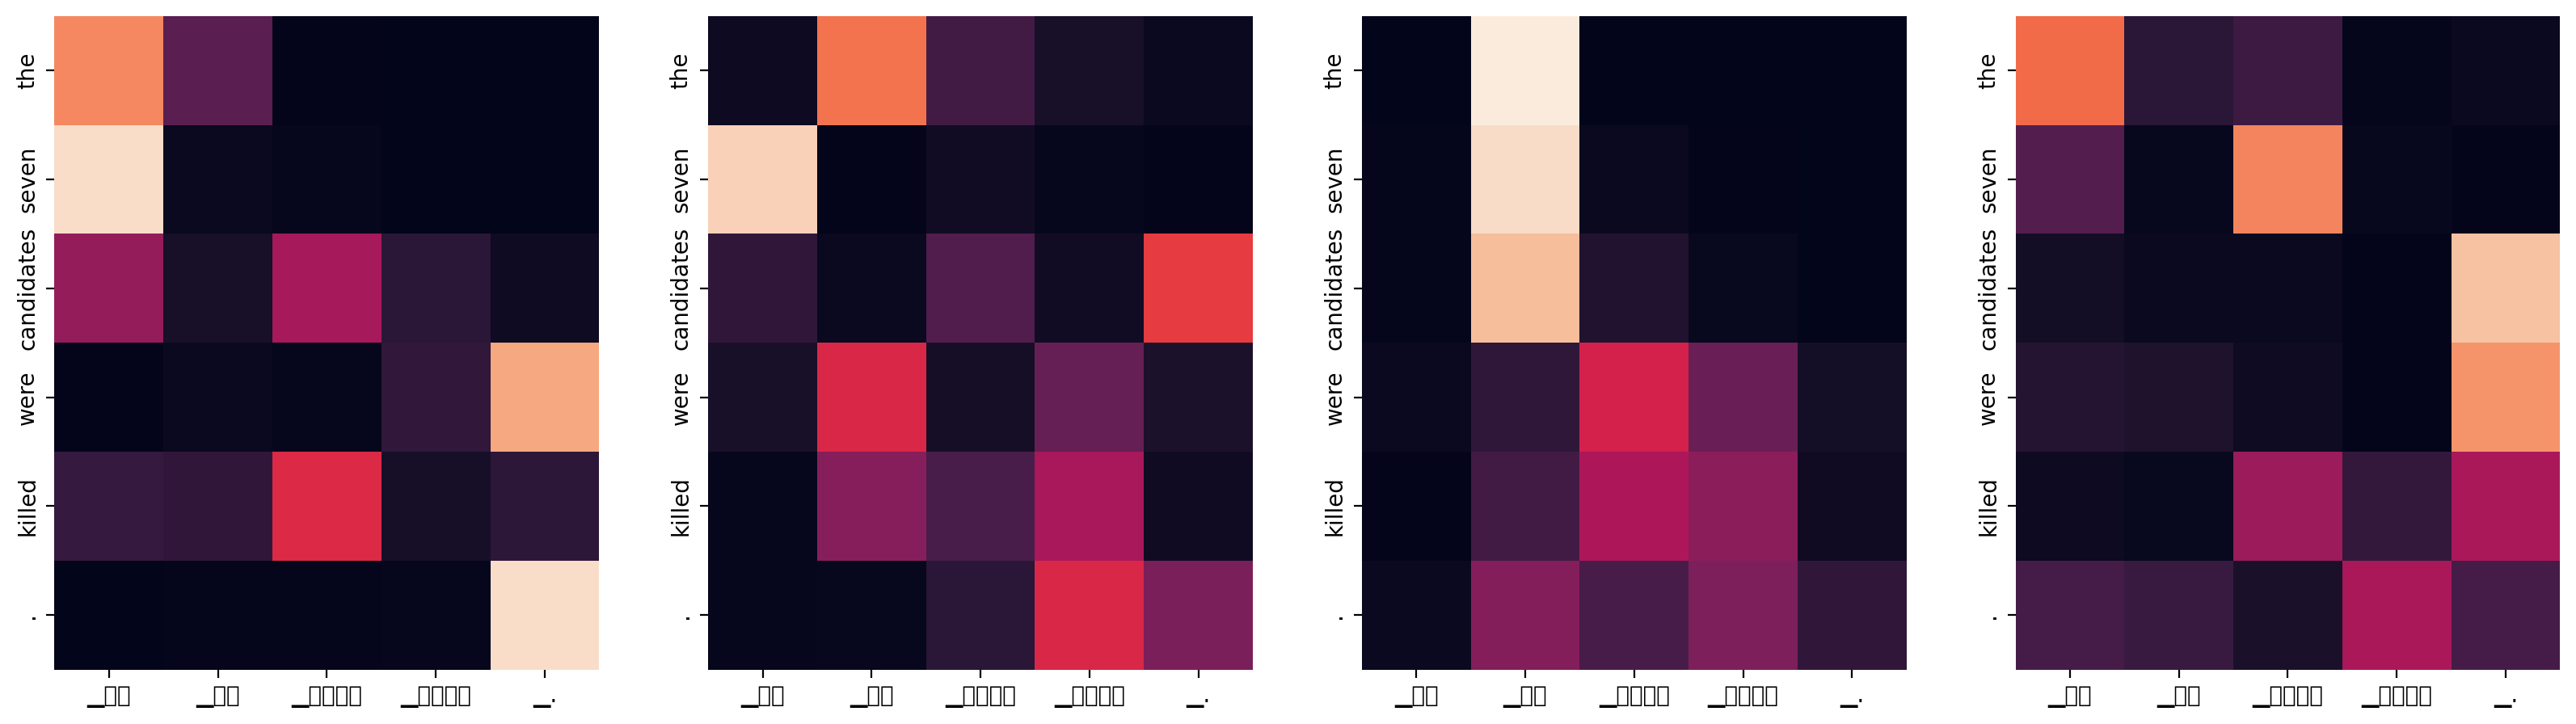

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

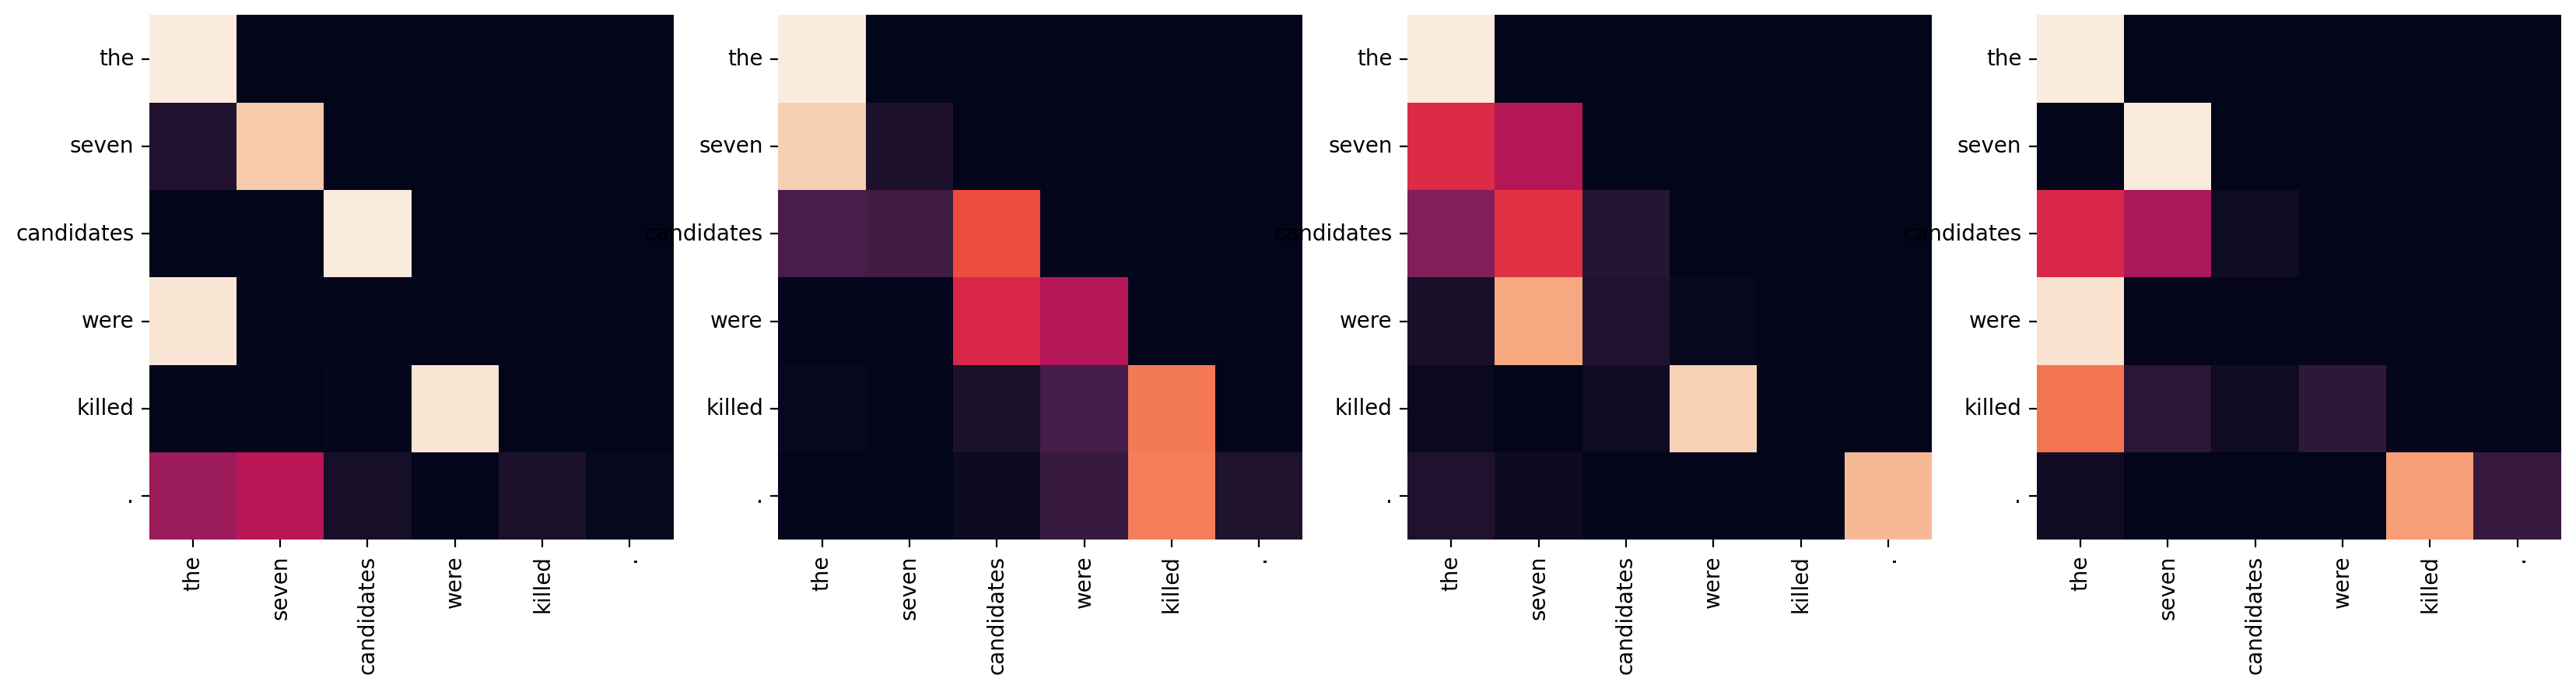

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44273 (\N{HANGUL SYLLABLE GOB}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/pyth

Decoder Src Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.draw()
/home/downtown/miniconda3/envs/fucklms/lib/python3.8/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44273 (\N{HANGUL SYLLABLE GOB}) missing from current font.
  fig.canvas.draw()
findf

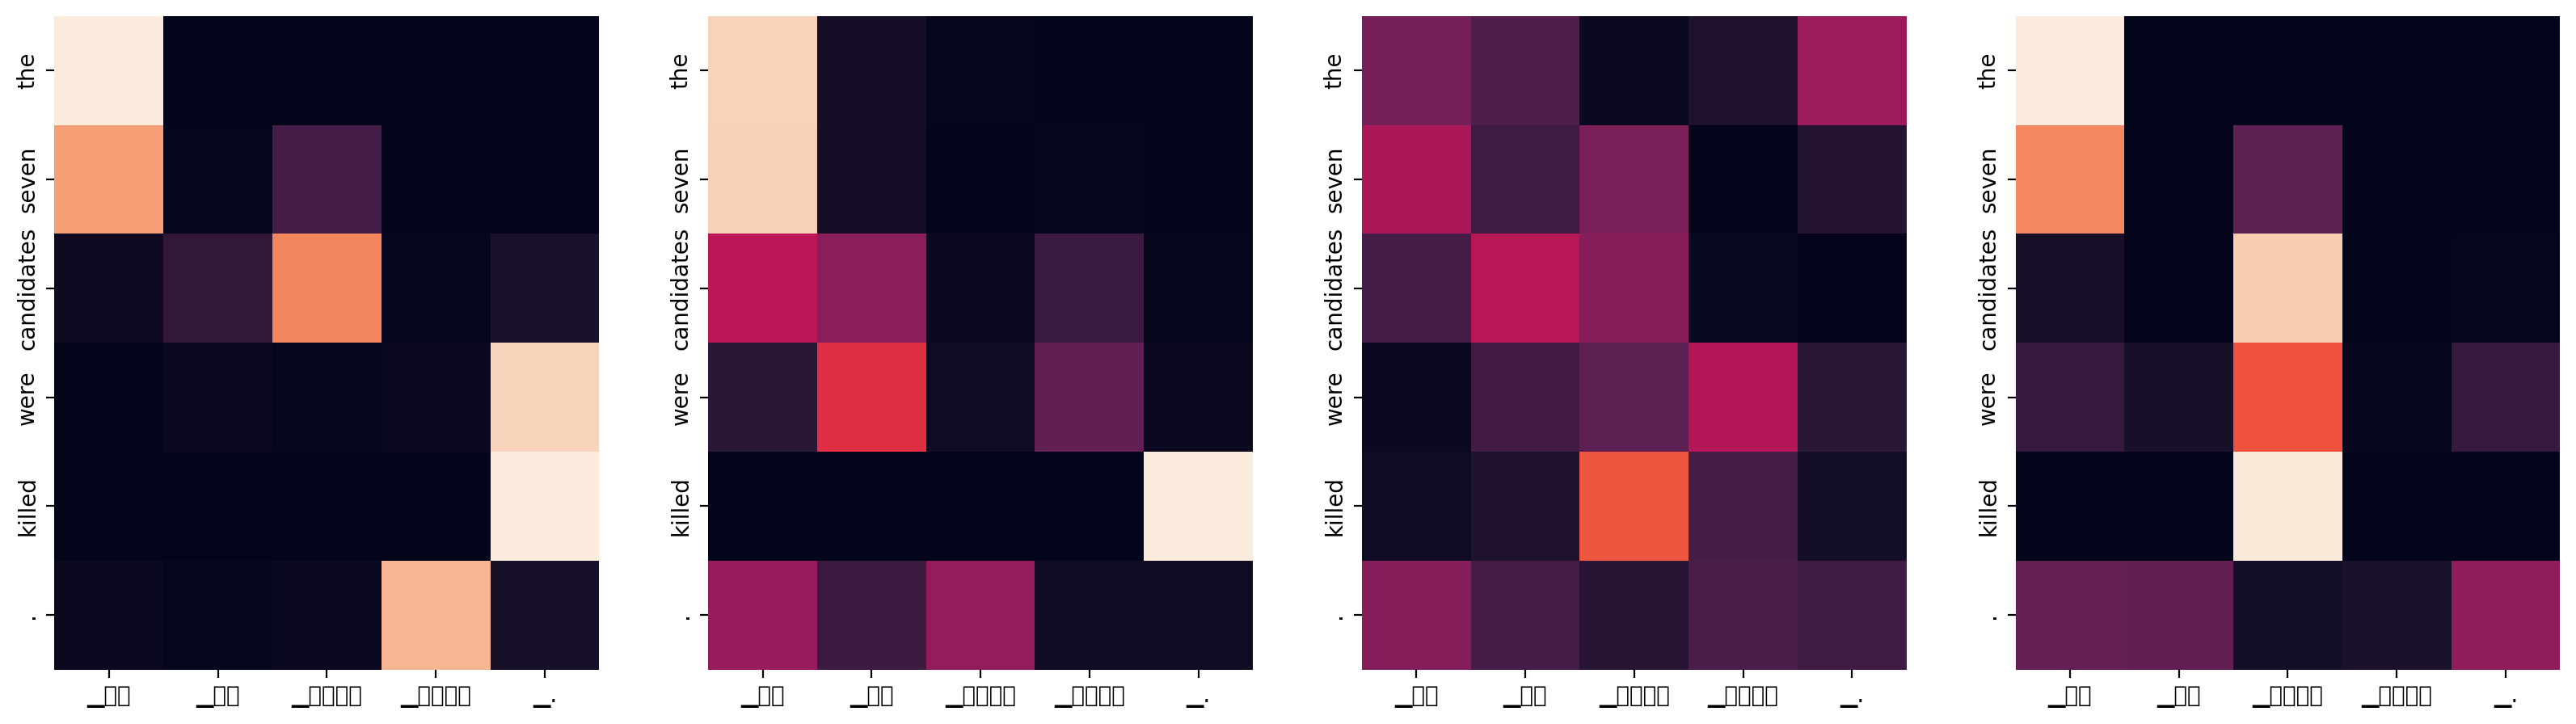

In [70]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 2

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

## 회고
일단... 할 수 있는 건 최대한 해봤습니다.   
중간중간 shape 출력하도록 해서 상태도 보고, 테스트 문장으로 시험도 해보고..  
다른 분이 해결에 성공하셨다는 코드를 보고 똑같이 따라도 해봤습니다만,   
똑같은 코드인데 어째서 저는 계속 에러가 뜨는 걸까요.  
뭐가 문제인지 모르겠어요.   
우선 오늘은 너무 졸려서 이만 마무리하지만, 이건 꼭 해결하겠습니다....  

---

그 시각화 과정에서 한국어 지원 폰트로 변경하는 코드를 추가 실행했어야 했는데 깜빡하고 빼먹었더니 AttentionMap을 제대로 확인할 수가 없다.   
그래도 번역된 결과만 확인하면 다음과 같다.   

1. "오바마는 대통령이다."
    Epoch 1 : obama is in the obama of illinois   
    Epoch 2 : the president is the president s most important step   
2. "시민들은 도시 속에 산다."
    Epoch 1 : the city s city is in the city   
    Epoch 2 : the streets of cities , cities , cities   
3. "커피는 필요 없다."
    Epoch 1 : the coffee is not enough to be   
    Epoch 2 : it is not a thing   
4. "일곱 명의 사망자가 발생했다."
    Epoch 1 : the dead were killed   
    Epoch 2 : the seven candidates were killed   

시간 관계상 2에폭 까지만 진행했는데, 에폭 수를 더 늘리면 좀 더 유의미한 결과가 나올 것 같다.  